In [1]:
%%writefile model_runner.py
import json
import os, sys
import bz2
import pickle
import numpy as np
from tqdm import tqdm

def indices_required_for_merges(keep_indices, vocab, merges):
    merges_lookup = {}
    for m in merges:
        a, b = m.split(' ') if isinstance(m, str) else m
        key = vocab[f'{a}{b}']
        if key not in merges_lookup: merges_lookup[key] = set()
        merges_lookup[key].add(vocab[a])
        merges_lookup[key].add(vocab[b])
    to_process = list(keep_indices)
    while len(to_process):
        for w in merges_lookup.get(to_process.pop(), []):
            if w not in keep_indices:
                keep_indices[w] = None
                to_process.append(w)
    return keep_indices

def remove_unused_merges(merges, vocab):
    return [f'{a} {b}' for a, b in [m.split(' ') if isinstance(m, str) else m for m in merges] if all(w in vocab for w in [a, b, a + b])]

def map_special_tokens(data, mapping=None):
    tokens = set()
    if isinstance(data, dict):
        special = data.get('special_tokens')
        if special is not None:
            for v in special.values():
                tokens.update(v['ids'])
                if mapping is not None:
                    v['ids'] = [mapping.get(i) for i in v['ids'] if i in mapping]
    for v in (data.values() if isinstance(data, dict) else data if isinstance(data, list) else []):
        tokens.update(map_special_tokens(v, mapping))
    return tokens

def remove_tokenizer_normalizer(tokenizer):
    from tokenizers import Tokenizer
    assert tokenizer.is_fast
    tokenizer_json = json.loads(tokenizer._tokenizer.to_str())
    if tokenizer_json.get('normalizer') is not None:
        tokenizer_json['normalizer'] = None
        tokenizer._tokenizer = Tokenizer.from_str(json.dumps(tokenizer_json))

def shrink_tokenizer_vocab(tokenizer, keep_indices, keep_special_tokens, keep_token_order):
    from tokenizers import Tokenizer
    assert tokenizer.is_fast
    tokenizer_json = json.loads(tokenizer._tokenizer.to_str())
    assert tokenizer_json['model']['type'] == "BPE"
    if keep_special_tokens:
        keep_indices.update({k: None for k in tokenizer.all_special_ids})
        keep_indices.update({k: None for k in map_special_tokens(tokenizer_json.get('post_processor'))})
    keep_indices = indices_required_for_merges(keep_indices, tokenizer_json['model']['vocab'], tokenizer_json['model']['merges'])
    if keep_token_order: keep_indices = sorted(keep_indices)
    mapping = {old: new for new, old in enumerate(keep_indices)}
    tokenizer_json['model']['vocab'] = {k: mapping[v] for k, v in tokenizer_json['model']['vocab'].items() if v in mapping}
    tokenizer_json['model']['merges'] = remove_unused_merges(tokenizer_json['model']['merges'], tokenizer_json['model']['vocab'])
    special_tokens_order = [t['id'] for t in tokenizer_json['added_tokens']]
    assert special_tokens_order==sorted(special_tokens_order)
    tokenizer_json['added_tokens'] = sorted([{**t, 'id': mapping[t['id']]} for t in tokenizer_json['added_tokens'] if t['id'] in mapping], key=lambda t: t['id'])
    map_special_tokens(tokenizer_json.get('post_processor'), mapping)
    tokenizer._tokenizer = Tokenizer.from_str(json.dumps(tokenizer_json))
    return mapping, keep_indices

def shrink_model_embeddings(model, keep_indices, mapping):
    import torch
    with torch.no_grad():
        row_select = torch.tensor(list(keep_indices))
        new_embed_t = torch.index_select(model.get_input_embeddings().weight.data, 0, row_select.to(model.get_input_embeddings().weight.data.device))
        new_lm_head = torch.index_select(model.get_output_embeddings().weight.data, 0, row_select.to(model.get_output_embeddings().weight.data.device))
        model.resize_token_embeddings(len(keep_indices))
        model.get_input_embeddings().weight.data[:] = new_embed_t
        model.get_output_embeddings().weight.data[:] = new_lm_head
        for config in [model.config, model.generation_config]:
            for k, v in list(config.to_dict().items()):
                if k.endswith('token_id'):
                    setattr(config, k, [mapping.get(t) for t in v] if isinstance(v, list) else mapping.get(v))

def shrink_embeddings(model, tokenizer, corpus=None, keep_token_ids=[], keep_tokens=[], remove_token_ids=[], keep_model_tokens=True, keep_special_tokens=True, keep_normalizer=False, keep_token_order=True):
    if not keep_normalizer: remove_tokenizer_normalizer(tokenizer)
    from collections import OrderedDict  # use as OrderedSet
    keep_indices = OrderedDict()
    keep_indices.update({k: None for k in keep_token_ids})
    keep_indices.update({tokenizer.vocab[t]: None for t in keep_tokens})
    if corpus is not None: keep_indices.update({k: None for k in tokenizer(corpus)['input_ids']})
    if keep_model_tokens:
        for config in [model.config, model.generation_config]:
            for k, v in config.to_dict().items():
                if k.endswith('token_id'):
                    keep_indices.update({k: None for k in (v if isinstance(v, list) else [v])})
    keep_indices.pop(None, None)
    for idx in remove_token_ids: keep_indices.pop(idx, None)
    mapping, keep_indices = shrink_tokenizer_vocab(tokenizer, keep_indices, keep_special_tokens, keep_token_order)
    shrink_model_embeddings(model, keep_indices, mapping=mapping)
    return mapping

def fix_dtypes(model, fix_weights=True, fix_quant_states=True):
    import torch
    for module in model.modules():
        weight = getattr(module, 'weight', None)
        if weight is not None:
            if torch.is_floating_point(weight):
                if fix_weights and weight.dtype!=model.dtype:
                    module.to(model.dtype)
            else:
                qs = getattr(weight, 'quant_state', None)
                if qs is not None:
                    if fix_quant_states and qs.dtype!=model.dtype:
                        qs.dtype = model.dtype
    return model

def merge_peft_into_base(model):
    print('*** Merge peft model into base model...')
    assert is_peft_model(model)
    return fix_dtypes(model.merge_and_unload())

def save_model(store_path, model=None, tokenizer=None, merge=False):
    if merge: model = merge_peft_into_base(model)
    if store_path is not None:
        assert model is not None or tokenizer is not None
        print(f"*** Saving{' merged' if merge else ''} model/tokenizer to '{store_path}'...")
        if model is not None: model.save_pretrained(store_path)
        if tokenizer is not None:
            tokenizer.save_pretrained(store_path)
            to_delete = os.path.join(store_path, 'tokenizer.model')
            if os.path.isfile(to_delete): os.remove(to_delete)
    return model

def is_unsloth_model(model):
    return model.model_tags is not None and 'unsloth' in model.model_tags

def is_peft_model(model):
    return hasattr(model, 'peft_type')

def download_model(repo_id, store_path, get_name=lambda n: os.path.join(n.replace('/', '--'), 'transformers', 'default', '1')):
    import os
    if os.path.exists(repo_id): return repo_id
    model_path = os.path.join(store_path, get_name(repo_id))
    if not os.path.exists(model_path):
        from huggingface_hub import snapshot_download
        download_path = snapshot_download(repo_id=repo_id)
        os.makedirs(os.path.split(model_path)[0], exist_ok=True)
        os.symlink(download_path, model_path, target_is_directory=True)
    return model_path

def get_and_fix_peft_weights(store):
    print(f"*** Load peft state_dict from '{store}'...")
    from peft import load_peft_weights
    state_dict = load_peft_weights(store)
    for k in list(state_dict.keys()):
        if 'modules_to_save' in k:
            del state_dict[k]
            original_module_key = k.replace('.modules_to_save.', '.original_module.')
            if original_module_key in state_dict: del state_dict[original_module_key]
            assert k.replace('.modules_to_save.', '.') in state_dict
    return state_dict

def set_peft_weights(model, state_dict):
    print(f"*** Set model state_dict...")
    from peft import set_peft_model_state_dict
    res = set_peft_model_state_dict(model, state_dict)
    assert not res.unexpected_keys

def load_peft_state(model, store):
    set_peft_weights(model, get_and_fix_peft_weights(store))

def prepare_model(model, mode, tokenizer=None, formatter=None, shrink_embedding=False, dequantize=False, peft=[], local_files_only=False, add_special_tokens={}, set_pad_token=None, keep_tokens=[], keep_normalizer=None, peft_trainable=True, device_map=None, tf_grad_cp=True, tf_use_fa2=True, **kwargs):
    if isinstance(model, str):
        assert tokenizer is None
        print(f"*** Load base model and tokenizer from '{model}'...")
        if mode=='unsloth_4bit':
            assert device_map is None, 'unsupported'
            from unsloth import FastLanguageModel
            model, tokenizer = FastLanguageModel.from_pretrained(model_name=model, dtype=None, load_in_4bit=True, local_files_only=local_files_only, **kwargs)
        elif mode in ['transformers', 'transformers_bf16', 'transformers_4bit', 'transformers_bf16_4bit', 'tokenizer_only']:
            import torch
            model_load_args = {}
            if device_map is not None: model_load_args['device_map'] = device_map
            if tf_use_fa2: model_load_args['attn_implementation'] = 'flash_attention_2'
            if mode in ['transformers_bf16', 'transformers_bf16_4bit']: model_load_args['torch_dtype'] = torch.bfloat16
            elif mode in ['transformers_4bit', 'transformers_bf16_4bit']:
                from transformers import BitsAndBytesConfig
                nf4_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type='nf4', bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.bfloat16)
                model_load_args['quantization_config'] = nf4_config
            from transformers import AutoTokenizer, AutoModelForCausalLM
            tokenizer = AutoTokenizer.from_pretrained(model, local_files_only=local_files_only, **kwargs)
            model = AutoModelForCausalLM.from_pretrained(model, **model_load_args) if mode!='tokenizer_only' else None
            if tf_grad_cp and model is not None: model.gradient_checkpointing_enable()
        else: raise NotImplementedError('Unknown mode.')
    if add_special_tokens: tokenizer.add_special_tokens(add_special_tokens)
    if set_pad_token is not None: tokenizer.pad_token = set_pad_token
    if formatter is not None and not hasattr(formatter, 'corpus'):
        formatter = formatter(tokenizer=tokenizer)
    if (shrink_embedding<len(tokenizer.vocab) if type(shrink_embedding)==int else shrink_embedding) or keep_normalizer is False:
        print('*** Shrink embedding...')
        embedding_size_before_shrink = len(tokenizer.vocab)
        mapping = shrink_embeddings(model, tokenizer, formatter.get_corpus(), keep_tokens=keep_tokens, keep_normalizer=keep_normalizer)
        print(f'*** -> Reduced embedding size from {embedding_size_before_shrink} to {len(mapping)} words.')
    if dequantize:
        print(f'*** Dequantize model...')
        model = model.dequantize()
    if len(peft):
        peft_trained = True if is_peft_model(model) else None
        for i, m in enumerate(peft):
            if peft_trained is True: model, peft_trained = merge_peft_into_base(model), None
            if isinstance(m, str):
                if peft_trained is False:
                    _, peft_trained = load_peft_state(model, m), True
                else:
                    print(f"*** Load peft model from '{m}'...")
                    # be careful when using unsloth - using PeftModel to load the model will not apply unsloth optimizations
                    from peft import PeftModel
                    model, peft_trained = PeftModel.from_pretrained(model, m, trainable=peft_trainable), True
            else:
                assert peft_trained is None
                if isinstance(m, dict):
                    print('*** Create new peft model...')
                    if is_unsloth_model(model):
                        from unsloth import FastLanguageModel
                        my_get_peft_model = FastLanguageModel.get_peft_model
                    else:
                        from peft import LoraConfig, get_peft_model
                        my_get_peft_model = lambda model, **kwargs: get_peft_model(model, LoraConfig(**kwargs))
                    model, peft_trained = my_get_peft_model(model, **m), False
                else: assert m is None
    return model, tokenizer, formatter

def training_run(model, formatter, dataset, train_args, max_seq_length, merge=False, store=None, packing=False, grad_acc_fix=False, optimizers=None):
    assert merge is False, "merge after training does not seen to work (at least with unsloth, saved merged model will cointain the untrained weights!)"
    import torch
    from datasets import Dataset
    add_train_args = {}
    if is_unsloth_model(model):
        from unsloth import FastLanguageModel
        from unsloth import UnslothTrainer as Trainer
        from unsloth import UnslothTrainingArguments as TrainingArguments
        from unsloth import is_bfloat16_supported
        FastLanguageModel.for_training(model)
        add_train_args.update(fp16=not is_bfloat16_supported(), bf16=is_bfloat16_supported())
    else:
        from trl import SFTConfig as TrainingArguments
        from trl import SFTTrainer as Trainer
        model.train()
        add_train_args.update(bf16=True)

    formatter.tokenizer.padding_side = 'right'
    if is_unsloth_model(model):
        for convert_to_float in [model.get_input_embeddings(), model.get_output_embeddings()]:
            if convert_to_float.weight.dtype!=torch.float32: convert_to_float.to(torch.float32)

    add_args = {}
    if optimizers is not None: add_args['optimizers'] = optimizers

    trainer = Trainer(
        model=model,
        tokenizer=formatter.tokenizer,
        data_collator=formatter.get_data_collator(),
        train_dataset=Dataset.from_list(dataset.as_list(formatter)),
        dataset_text_field="text",
        max_seq_length=max_seq_length,
        dataset_num_proc=None,
        packing=packing,  # Can make training 5x faster for short sequences.
        **add_args,
        args=TrainingArguments(
            **add_train_args,
            **train_args
        ),
    )

    print('*** Start training run...')
    if grad_acc_fix and is_unsloth_model(model):
        from unsloth import unsloth_train
        trainer_stats = unsloth_train(trainer)
    else:
        if is_unsloth_model(model) and train_args['gradient_accumulation_steps']>1: print('*** WARNING: using faulty unsloth gradient accumulation')
        trainer_stats = trainer.train()
    try: print(f'*** -> Training took {trainer_stats.metrics["train_runtime"]} seconds.')
    except: pass
    if store is not None: save_model(store, model, formatter.tokenizer, merge=merge)
    return model, trainer_stats

def inference_load(store, keys=True, result_dict=None, always_read_from_file=False):
    if result_dict is None: result_dict = {}
    if store is not None:
        if keys is True: keys = os.listdir(store)
        for key in keys:
            if always_read_from_file or key not in result_dict:
                try:
                    with bz2.BZ2File(os.path.join(store, key)) as f: result_dict[key] = pickle.load(f)
                except: continue
    return result_dict

def inference_save(store, key, outputs):
    if store is not None:
        os.makedirs(store, exist_ok=True)
        with bz2.BZ2File(os.path.join(store, key), 'w') as f: pickle.dump(outputs, f)

class Decoder(object):
    def __init__(self, formatter, dataset, n_guesses, max_outputs=None, frac_score=False, quiet=False, name='', additional_decoders=None, prob_baseline=None):
        self.formatter = formatter
        self.dataset = dataset
        self.n_guesses = n_guesses
        self.decoded_results = {}
        self.correct_solutions = {}
        self.keys_lim = set()
        self.keys_all = set()
        self.mult_cnt = {}
        self.keys_cnt = {}
        self.frac_score = frac_score
        self.max_outputs = max_outputs
        self.quiet = quiet
        self.input_len = [{} if formatter is not None and formatter.tokenizer is None else ds.get_lengths(formatter, name='input') for ds in [dataset, dataset.mod(np.transpose, keep_key=True)]]
        self.reply_len = [{} if formatter is not None and formatter.tokenizer is None else ds.get_lengths(formatter, name='reply') for ds in [dataset, dataset.mod(np.transpose, keep_key=True)]]
        self.additional_decoders = additional_decoders
        self.name = name
        self.prob_tracker = {}
        self.prob_tracker_best = {}
        self.prob_baseline = prob_baseline

    def score(self, *to_score):
        scores = [(sum(1/self.mult_cnt[k.split('_')[0]] for k in s) if self.frac_score else len(s)) for s in to_score]
        score_cnt = len(self.mult_cnt if self.frac_score else self.keys_cnt)
        return scores, score_cnt

    def from_store(self, store, **kwargs):
        for key, outputs in inference_load(store).items():
            self.process(key, outputs, **kwargs)
        return self

    def score_fmt(self, v):
        return f'{v:5.1f}' if self.frac_score else f'{v:3}'

    def process_single_output(self, key, output_len, decoded, print_func=print, len_info=None, device_info=None):
        import numpy as np
        inv_mod = {k: v if k.endswith('val') else self.dataset.invert_mod(v, key, inv_perm=(k.startswith('output') or k.startswith('score_all'))) for k, v in decoded.items()}
        base_key = key.split('.')[0]
        self.decoded_results[base_key] = self.decoded_results.get(base_key, {})
        self.decoded_results[base_key][key] = inv_mod
        output = inv_mod.get('output')
        score = inv_mod.get('score')

        # quick scoring
        self.keys_cnt[base_key] = self.keys_cnt.get(base_key, 0) + 1
        mult_key, mult_sub = (base_key.split('_') + ['0'])[:2]
        self.mult_cnt[mult_key] = max(self.mult_cnt.get(mult_key, 0), int(mult_sub) + 1)
        if len(self.dataset.replies):
            correct_solution = self.dataset.replies.get(base_key)
            if correct_solution is not None:
                correct_solution = correct_solution[0]
                self.correct_solutions[base_key] = correct_solution
                is_correct = correct_solution is not None and np.array_equal(correct_solution, output)
                if is_correct:
                    self.keys_all.add(base_key)
                    if self.keys_cnt[base_key] <= self.n_guesses: self.keys_lim.add(base_key)
            corr_str = 'cant_decode' if output is None else 'sol_unknown' if correct_solution is None else 'ALL_CORRECT' if is_correct else 'bad_xy_size' if np.shape(correct_solution)!=np.shape(output) else 'bad_content'
            (score_lim, score_all), score_cnt = self.score(self.keys_lim, self.keys_all)

            tp_arr = (key.count('transpose') + key.count('rot90')) % 2
            msc = None if score is None else np.sum(score)
            fsc = inv_mod.get('score_val')
            if output is not None and fsc is not None:
                pt = self.prob_tracker[base_key] = self.prob_tracker.get(base_key, {})
                hash = tuple(map(tuple, output))
                prob = pt[hash] = pt.get(hash, 0) + (np.exp(fsc) if self.prob_baseline is None else fsc - np.log(self.prob_baseline))
                current_best = self.prob_tracker_best.get(base_key)
                if current_best is None or current_best[0]<prob:
                    self.prob_tracker_best[base_key] = (prob, output)
            fmt_name = f'{self.name}: ' if self.name else ''
            msc_print = f'{min(-msc, 9.99999):7.5f}' if msc is not None else 'unknown'
            fsc_print = f'{min(-fsc, 9.99999):7.5f}' if fsc is not None else 'unknown'
            if not self.quiet: print_func(f" {fmt_name}acc: {self.score_fmt(score_lim)}/{score_cnt:3}={min(score_lim/score_cnt, 0.999):5.1%} (2-guess), {self.score_fmt(score_all)}/{score_cnt:3}={min(score_all/score_cnt, 0.999):5.1%} (any);{f' {device_info}' if device_info else ''} tok:{self.input_len[tp_arr].get(base_key, '?'):>4}+{self.reply_len[tp_arr].get(base_key, '?'):>3}>{'n/a' if output_len is None else output_len:>3} {corr_str}:{msc_print}|{fsc_print} [{key}]")

    def get_current_best(self, base_key):
        current_best = self.prob_tracker_best.get(base_key)
        return None if current_best is None else current_best[1]

    def process_single_decode(self, key, de_tokenized, print_func=print, **kwargs):
        if len(de_tokenized)==3 and not isinstance(de_tokenized[1], float):  # for backwards compatibility
            output_len, *data = de_tokenized
            score_val = None
        else: output_len, score_val, *data = de_tokenized
        if self.formatter is None:
            assert len(data) == 1
            decoded = [data[0]]
        else: decoded = self.formatter.decode_to_array(*data)
        #if len(decoded)==2:
        #    same = np.array_equal(decoded[0].get('output'), decoded[1].get('output'))
        #    print_func(f"is_identical: {same}")
        #    if not same: for i in range(2): print_func(str(decoded[i].get('output')))
        for d in decoded: d['score_val'] = score_val
        for i, dec in enumerate(decoded):
            if i==0: self.process_single_output(key, output_len, dec, print_func=print_func, **kwargs)
            elif self.additional_decoders:
                if i-1<len(self.additional_decoders): self.additional_decoders[i-1].process_single_output(key, output_len, dec, print_func=print_func, **kwargs)
                else: print_func(f'{key} no decoder available for output #{i}')
            else: self.process_single_output(f'{key}.fix{i}', output_len, dec, print_func=print_func, **kwargs)

    def process(self, key, de_tokenized, **kwargs):
        for i, d in enumerate(de_tokenized):
            if self.max_outputs is None or i<=self.max_outputs:
                self.process_single_decode(f'{key}.out{i}', d, **kwargs)

    def get_unsolved_keys(self):
        unsolved = []
        for base_key, reply in self.dataset.replies.items():
            if not any(np.array_equal(reply[0], s.get('output')) for s in self.decoded_results.get(base_key, {}).values()):
                unsolved.append(base_key)
        return unsolved

    def run_selection_algo(self, selection_algorithm):
        return {bk: (selection_algorithm({k: g for k, g in v.items() if g.get('output') is not None}) if any(g.get('output') is not None for g in v.values()) else []) for bk, v in self.decoded_results.items()}

    def benchmark_selection_algos(self, selection_algorithms, skip_failed=True):
        import numpy as np
        results = {}
        print('*** Benchmark selection algorithms...')
        for selection_algorithm in selection_algorithms:
            name = selection_algorithm.__name__
            try:
                selected = self.run_selection_algo(selection_algorithm)
                if self.formatter is not None:
                    for sols in selected.values():
                        for s in sols:
                            assert self.formatter.is_valid_solution(s), f'found invalid solutions {s}'
                correct_keys = {k for k, v in selected.items() if self.correct_solutions.get(k) is not None and any(np.array_equal(guess, self.correct_solutions[k]) for guess in v[:self.n_guesses])}
                (score,), score_cnt = self.score(correct_keys)
                results[name] = score
                print(f" acc: {score:5.1f}/{score_cnt:3}={score/score_cnt:6.2%} ('{name}')")
            except:
                print(f" {'execution failed':>21} ('{name}')")
                if not skip_failed: raise
        return results

    def calc_augmented_scores(self, model, base_keys=None, store=None, seed=0, max_len=None, make_unique=True, quiet=False, **kwargs):
        if base_keys is None: base_keys = list(self.decoded_results.keys())
        if store is not None: store = f'{store}_new'  # new format is not backwards compatible, so use new folder
        for bk in (base_keys if quiet else tqdm(base_keys, desc='calculate augmented scores', file=sys.stdout)):
            res = self.decoded_results.get(bk, {})
            known_scores = {}
            for k, v in sorted(res.items()):
                if 'output' in v:
                    k_store = None if store is None else os.path.join(store, k)
                    id = tuple(map(tuple, v['output']))
                    if not (make_unique and id in known_scores):
                        try:
                            assert k_store is not None
                            with bz2.BZ2File(k_store) as f: known_scores[id] = pickle.load(f)
                            if isinstance(known_scores[id], list): known_scores[id] = dict(score_multi=known_scores[id])  # for backwards compatibility
                            k_store = None
                        except:
                            temp_dataset = self.dataset.__class__(
                                keys=[bk],
                                queries={bk: self.dataset.queries.get(bk)},
                                replies={bk: [v['output'].tolist()]},
                            )
                            temp_decoder = self.__class__(self.formatter, temp_dataset, n_guesses=self.n_guesses, quiet=True)
                            temp_dataset = temp_dataset.augment(**kwargs, seed=(seed+hash(k)+hash(id)) % 1024**2, quiet=True)
                            if max_len is not None: temp_dataset = temp_dataset.cut_to_len(formatter=self.formatter, name='input', max_len=max_len, quiet=True)
                            for x in temp_dataset.as_list(self.formatter): calc_score(**x, formatter=self.formatter, model=model, decoder=temp_decoder)
                            known_scores[id] = dict(
                                score_multi=[np.sum(x['score']) for x in temp_decoder.decoded_results[bk].values()],
                                score_multi_nl=[x['score_val'] for x in temp_decoder.decoded_results[bk].values()],
                                score_multi_array=np.array([x['score'] for x in temp_decoder.decoded_results[bk].values()]),
                                score_multi_array_cum=np.array([x['score_cum'] for x in temp_decoder.decoded_results[bk].values()]),
                                score_multi_array_all=np.array([x['score_all'] for x in temp_decoder.decoded_results[bk].values()]),
                                score_multi_array_all_cum=np.array([x['score_all_cum'] for x in temp_decoder.decoded_results[bk].values()]),
                            )
                            if k_store is not None:
                                os.makedirs(store, exist_ok=True)
                                with bz2.BZ2File(k_store, 'w') as f: pickle.dump(known_scores[id], f)
                    v.update(known_scores[id])

def turbo_dfs(model, logits, path, eos_token_id, max_new_tokens, max_score, max_score_greedy, temperature, suppress_tokens, torch, score=0.0, pos=0, cache=None):
    logits, next_logits = logits[0], (logits[1:] if len(logits)>1 else None)
    nll = -(logits / temperature).detach().float().log_softmax(-1).cpu().numpy()
    greedy_index = nll.argmin(-1).item()
    nll = list(enumerate(nll))
    if path: nll[0], nll[path[0]], path = nll[path[0]], nll[0], path[1:]  # follow precomputed path first
    suffixes = []
    for i, s in nll:
        next_score = score + s
        allowed_max_score = max_score_greedy if i==greedy_index else max_score
        if next_score < allowed_max_score:
            if i==eos_token_id: next_suffixes = [(next_score, [], [])]
            elif max_new_tokens>1:
                if next_logits is None:
                    if pos<cache[0][0][0].shape[2]: cache[0] = tuple(tuple(c[:, :, :pos] for c in l) for l in cache[0])
                    next_logits, cache[0] = model(
                        input_ids= torch.full((1,1), i, device=model.device),
                        position_ids=torch.full((1,1), pos, device=model.device),
                        past_key_values=cache[0],
                    )[:2]
                    next_logits = next_logits[0]  # unbatch
                next_suffixes = turbo_dfs(model, logits=next_logits, path=path, eos_token_id=eos_token_id, max_new_tokens=max_new_tokens-1, max_score=max_score, max_score_greedy=allowed_max_score, temperature=temperature, suppress_tokens=suppress_tokens, torch=torch, score=next_score, pos=pos+1, cache=cache)
            else: next_suffixes = []
            for suffix in next_suffixes:
                suffix[1].append(i)
                suffix[2].append(logits)
            suffixes.extend(next_suffixes)
        next_logits = None
    return suffixes

def inference_turbo_dfs(model, input_ids, eos_token_id, max_new_tokens, min_prob, min_prob_greedy=1, temperature=1.0, suppress_tokens=[], path=[], attention_mask=None):
    import torch
    with torch.no_grad():
        assert attention_mask is None or attention_mask.all(), 'not implemented'
        input_ids = torch.as_tensor(input_ids, device=model.device, dtype=int)
        if input_ids.ndim==2: input_ids = input_ids.squeeze(0)
        assert input_ids.ndim==1, 'batching not supported'
        max_score = -np.log(min_prob)
        max_score_greedy = (-np.log(min_prob_greedy)) if min_prob_greedy>0 else float('inf')  # avoid throwing numpy error
        max_score_greedy = max(max_score, max_score_greedy)
        if path is None: path = []
        if len(path) and path[-1]==eos_token_id: path = path[:-1]
        with torch.no_grad():
            full_path = input_ids
            if len(path): full_path = torch.cat([full_path, torch.as_tensor(path, device=model.device)])
            logits, cache = model(input_ids=full_path[np.newaxis])[:2]
            logits = logits[0, len(input_ids)-1:]
        result = turbo_dfs(model, logits=logits, path=path, eos_token_id=eos_token_id, max_new_tokens=max_new_tokens, max_score=max_score, max_score_greedy=max_score_greedy, temperature=temperature, suppress_tokens=suppress_tokens, torch=torch, score=0.0, pos=len(input_ids), cache=[cache])
        return sorted([(score_val, np.array(suffix[::-1]), torch.stack(score_arr[::-1]).float().cpu().numpy()) for score_val, suffix, score_arr in result], key=lambda x:x[0])

def inference_step(tokenized, model, remove_token_type_ids=True, num_beams=1, formatter=None, min_prob=None, current_best=None, **kwargs):
    import torch
    if remove_token_type_ids: tokenized.pop('token_type_ids', None)
    if min_prob is not None:
        assert num_beams==1
        gen = inference_turbo_dfs(model, **tokenized.to(model.device), path=current_best, min_prob=min_prob, eos_token_id=formatter.tokenizer.eos_token_id, **kwargs)
        tokens_out = [[g[1] for g in gen]]
        scores_out = [[g[2] for g in gen]]
    elif is_unsloth_model(model) and num_beams > 1:
        assert False, 'unsloth does not support beam search'
    else:
        gen = model.generate(**tokenized.to(model.device), return_dict_in_generate=True, output_logits=True, use_cache=True, **kwargs)
        tokens_out = gen['sequences'][:, torch.newaxis, tokenized['input_ids'].shape[-1]:].cpu().numpy().copy()
        scores_out = torch.stack(gen['logits'], axis=-2)[:, torch.newaxis].float().cpu().numpy().copy()
    return tokens_out, scores_out

def process_inference_output(key, outputs, formatter, store=None, decoder=None, decoder_args={}):
    de_tokenized = [formatter.de_tokenize(*output) for output in zip(*outputs)]
    inference_save(store, key, de_tokenized)
    if decoder is not None: decoder.process(key, de_tokenized, **decoder_args)
    return de_tokenized

def inference_run_v2(model, formatter, dataset, decoder=None, max_new_tokens=None, max_batch_size=1, store=None, result_dict=None, rerun_empty=False, retrain=None, use_turbo=False, group_multi_output=True, **kwargs):
    import torch
    assert max_batch_size==1, 'unsupported'

    with torch.no_grad():
        print('*** Load stored data...')
        if result_dict is None: result_dict = {}
        result_dict = inference_load(store, dataset.keys, result_dict)
        by_base_key = {}
        needs_rerun = {}
        base_key_list = []
        for key in dataset.keys:
            base_key = key.split('.')[0]
            if group_multi_output: base_key = base_key.split('_')[0]
            if base_key not in by_base_key: base_key_list.append(base_key)
            bk_list = by_base_key[base_key] = by_base_key.get(base_key, [])
            bk_list.append(key)
        for base_key, keys in by_base_key.items():
            for key in keys:
                de_tokenized = result_dict.get(key)
                if de_tokenized is None or (rerun_empty and not de_tokenized):
                    bk_list = needs_rerun[base_key] = needs_rerun.get(base_key, [])
                    bk_list.append(key)
                elif decoder is not None: decoder.process(key, de_tokenized)

        formatter.tokenizer.padding_side = 'left'
        if max_new_tokens is None: max_new_tokens = formatter.max_new_tokens()
        if is_unsloth_model(model):
            from unsloth import FastLanguageModel
            FastLanguageModel.for_inference(model)
        else: model.eval()

        print('*** Start inference run...')
    try:
        with tqdm(base_key_list, file=sys.stdout) as pbar:
            for base_key in pbar:
                run_keys = needs_rerun.get(base_key)
                if run_keys:
                    if retrain is not None:
                        retrain_dataset = dataset.keep_key_startswith(base_key)
                        print(f"retraining model for key '{base_key}' (retrain_dataset_size={len(retrain_dataset.keys)})")
                        retrain(model, retrain_dataset)
                        if is_unsloth_model(model): FastLanguageModel.for_inference(model)
                    with torch.no_grad():
                        for key in run_keys:
                            input_text = dataset.get(key, formatter)['input']
                            batch = formatter.tokenizer([input_text], return_tensors='pt')
                            current_best = decoder.get_current_best(key.split('.')[0]) if use_turbo else None
                            if current_best is not None:
                                current_best = dataset.forward_mod(current_best, key)
                                current_best = formatter.fmt_reply([current_best])
                                current_best = formatter.tokenizer(input_text+current_best)['input_ids'][batch['input_ids'].shape[-1]:]
                            batch_out = inference_step(batch, model, formatter=formatter, max_new_tokens=max_new_tokens, current_best=current_best, **kwargs)
                            outputs = [x[0] for x in batch_out]
                            result_dict[key] = process_inference_output(key, outputs, formatter, store=store, decoder=decoder, decoder_args=dict(print_func=pbar.write))
        print('*** Completed inference run.')
    except KeyboardInterrupt: print('*** Ctrl+C pressed, stopping inference run.')
    return result_dict

class Retrainer(object):
    def __init__(self, n, aug_opts, reload_state_dict=None, **kwargs):
        self.n = n
        self.aug_opts = aug_opts
        self.reload_state_dict = reload_state_dict
        self.kwargs = kwargs

    def preprocess(self, dataset):
        ds = [dataset.augment(quiet=True, shfl_keys=True, **self.aug_opts) for _ in range((self.n-1)//dataset.length()+1)]
        ds = ds[0] if len(ds)==1 else ds[0].append(*ds[1:])
        ds, _ = ds.split_at_pos(self.n)
        return ds

    def __call__(self, model, dataset):
        if self.reload_state_dict is not None: set_peft_weights(model, self.reload_state_dict)
        assert is_unsloth_model(model), 'not implemented'
        if is_unsloth_model(model):
            from unsloth import FastLanguageModel
            FastLanguageModel.for_training(model)
        else: model.train()
        training_run(model, dataset=self.preprocess(dataset), **self.kwargs)

def calc_score(key, input, reply, formatter, model, store=None, decoder=None, **_):
    import torch
    with torch.no_grad():
        input_len = len(formatter.tokenizer(input)['input_ids'])
        tokenized = formatter.tokenizer([input+reply], return_tensors='pt')
        reply_tok = tokenized['input_ids'][0][input_len:].cpu().numpy().copy()
        reply_log = model.forward(**tokenized.to(model.device))['logits'][0, input_len-1: -1].float().cpu().numpy().copy()
        process_inference_output(key, (reply_tok[torch.newaxis], reply_log[torch.newaxis]), formatter, store=store, decoder=decoder)

def mem_info(gpu_id=0):
    import torch
    try:
        gpu_stats = torch.cuda.get_device_properties(gpu_id)
        usage = torch.cuda.max_memory_reserved() / 1024**3
        avail = gpu_stats.total_memory / 1024**3
        print(f"*** GPU: {gpu_stats.name}, used {usage:.3} / {avail:.3} GB.")
    except: print('*** Exception occured when getting memory stats.')

Overwriting model_runner.py


In [13]:
%%writefile arc_loader.py
import json
import numpy as np
import hashlib
import os, sys
from tqdm import tqdm
from glob import glob
import itertools
import random

def cut_at_token(output, token_id):
    eos_positions = (output==token_id).nonzero()[0]
    return output[:eos_positions[0]] if len(eos_positions) else output

def shuffled(data_list):
    return np.random.permutation(data_list).tolist()

def permute_mod(a, descriptor, invert=False):
    permutation = [int(i) for i in descriptor if str(i).isdigit()]
    assert sorted(permutation)==list(range(10))
    a = np.asarray(a)
    if a.ndim==3:
        if not invert: permutation = np.argsort(permutation)
        a = a[..., permutation]
    else:
        assert a.ndim==2
        if invert: permutation = np.argsort(permutation)
        a = np.asarray(permutation)[a]
    return a

def permute_rnd_col_(query):
    permutation = [0]+(1+np.random.permutation(9)).tolist()
    return 'permute' + ''.join(map(str, permutation))

def permute_rnd_all_(query):
    permutation = np.random.permutation(10).tolist()
    return 'permute' + ''.join(map(str, permutation))

def permute_cnt_col_(query):
    elements, frequency = np.unique(np.concatenate([list(range(10))]+[np.array(x['input']).ravel() for x in query['train']]), return_counts=True)
    permutation = [0]+sorted(np.random.permutation(9)+1, key=lambda i: frequency[i], reverse=True)  # randomness as tie breaker
    return 'permute' + ''.join(map(str, permutation))

def permute_cnt_all_(query):
    elements, frequency = np.unique(np.concatenate([list(range(10))]+[np.array(x['input']).ravel() for x in query['train']]), return_counts=True)
    permutation = sorted(np.random.permutation(10), key=lambda i: frequency[i], reverse=True)  # randomness as tie breaker
    return 'permute' + ''.join(map(str, permutation))

permute_rnd_col = (permute_mod, permute_rnd_col_)
permute_rnd_all = (permute_mod, permute_rnd_all_)
permute_cnt_col = (permute_mod, permute_cnt_col_)
permute_cnt_all = (permute_mod, permute_cnt_all_)
permute_None = (np.copy, None)

class ArcDataset(object):
    @staticmethod
    def forward_mod(a, key, use_perm=True, is_output=True):
        if a is None: return a
        for op in key.split('.')[1:]:
            if op.startswith('I'):
                if is_output: continue
                op = op[1:]
            if   op=='rot90':              a = np.rot90(a)
            elif op=='transpose':          a = np.swapaxes(a, 0, 1)
            elif op.startswith('permute'): a = permute_mod(a, op, invert=False) if use_perm else a
            elif op.startswith('copy'):    a = np.copy(a)
            elif op.startswith('out'):     a = a
            elif op.startswith('ex'):      a = a
            elif op.startswith('fix'):     a = a
            elif op.startswith('ice'):     a = a  # for adding icecuber solutions
            else: raise NotImplementedError(f"Inversion of operation '{op}' unknown.")
        return a

    @staticmethod
    def invert_mod(a, key, inv_perm=True, is_output=True):
        if a is None: return a
        for op in key.split('.')[1:][::-1]:
            if op.startswith('I'):
                if is_output: continue
                op = op[1:]
            if   op=='rot90':              a = np.rot90(np.rot90(np.rot90(a)))
            elif op=='transpose':          a = np.swapaxes(a, 0, 1)
            elif op.startswith('permute'): a = permute_mod(a, op, invert=True) if inv_perm else a
            elif op.startswith('copy'):    a = np.copy(a)
            elif op.startswith('out'):     a = a
            elif op.startswith('ex'):      a = a
            elif op.startswith('fix'):     a = a
            elif op.startswith('ice'):     a = a  # for adding icecuber solutions
            else: raise NotImplementedError(f"Inversion of operation '{op}' unknown.")
        return a

    def __init__(self, queries, replies={}, keys=None, is_orig=False, is_fake=False):
        if keys is not None: keys = [k for k in keys if k is not None]
        self.queries = queries if keys is None else {k: queries[k] for k in keys}
        self.replies = replies if keys is None else {k: replies[k] for k in keys if k in replies}
        self.is_orig = is_orig
        self.is_fake = is_fake
        self.keys = sorted(queries.keys()) if keys is None else keys
        self.faulty = {}
        self.transposed_dataset = None

    @classmethod
    def empty(cls):
        return cls(queries={}, replies={}, keys=[])

    def change_keys(self, keys, keep_flags=False):
        flags = dict(is_fake=self.is_fake, is_orig=self.is_orig) if keep_flags else {}
        return self.__class__(queries=self.queries, replies=self.replies, keys=keys, **flags)

    @classmethod
    def from_file(cls, queries_file):
        print(f"*** Load challanges from '{queries_file}'...")
        with open(queries_file) as f: queries = f.read()
        is_fake = hashlib.md5(queries.encode('utf-8')).hexdigest().lower()=='a6b7dac3cab03abf2eb333e16610d6dc'
        if is_fake: print("*** -> Fake test set detected, setting flag 'is_fake' to True.")
        return cls(
            queries=json.loads(queries),
            is_fake=is_fake,
            is_orig=True,
        )

    def load_replies(self, replies_file):
        print(f"*** Load solutions from '{replies_file}'...")
        with open(replies_file) as f: replies = f.read()
        replies_parsed = json.loads(replies)
        self.replies = {k: replies_parsed[k] for k in self.keys}
        return self

    def split_multi_replies(self):
        key_indices = [(k, i) for k in self.keys for i in range(len(self.queries[k]['test']))]
        return self.__class__(
            keys=[f'{k}_{i}' for k, i in key_indices],
            queries={f'{k}_{i}': {'train': self.queries[k]['train'], 'test': [self.queries[k]['test'][i]]} for k, i in key_indices},
            replies={f'{k}_{i}': [self.replies[k][i]] for k, i in key_indices if k in self.replies},
        )

    def move_test_to_train(self):
        new_queries = {k: {'train': self.queries[k]['train'] + [{**t, 'output': self.replies[k][i]} for i, t in enumerate(self.queries[k]['test'])], 'test': []} for k in self.keys}
        return self.__class__(queries=new_queries, keys=[k for k in self.keys])

    def last_train_ex_for_test(self):
        assert not self.replies
        new_queries = {k: {'train': self.queries[k]['train'][:-1], 'test': [{'input': self.queries[k]['train'][-1]['input']}]} for k in self.keys}
        new_replies = {k: [self.queries[k]['train'][-1]['output']] for k in self.keys}
        return self.__class__(queries=new_queries, replies=new_replies, keys=[k for k in self.keys])

    def length(self):
        return len(self.keys)

    def shuffled(self, seed=None):
        if seed is not None: np.random.seed(seed)
        return self.__class__(queries=self.queries, replies=self.replies, keys=shuffled(self.keys))

    def sorted(self, **kwargs):
        return self.__class__(queries=self.queries, replies=self.replies, keys=sorted(self.keys, **kwargs))

    def append(*datasets):
        return datasets[0].__class__(
            queries={k: v for d in datasets for k, v in d.queries.items()},
            replies={k: v for d in datasets for k, v in d.replies.items()},
            keys   =[k    for d in datasets for k    in d.keys           ],
        )

    def sort_ex_by_input_size(self, seed=42, reverse=False):
        np.random.seed(seed)
        sort_key = lambda ex: np.prod(np.shape(ex['input']))
        new_queries = {k2: {k: (sorted(np.random.permutation(np.array(v, dtype=object)), key=sort_key, reverse=reverse) if k=='train' else v) for k, v in v2.items()} for k2, v2 in self.queries.items()}
        return self.__class__(queries=new_queries, replies=self.replies, keys=[k for k in self.keys])

    def interleave(self, block_size, num_gpus=None):
        keys = np.reshape(self.keys, (-1, block_size)).T
        if num_gpus is None: return self.change_keys(keys.ravel().tolist())
        ret, num_gpus = (None, num_gpus) if isinstance(num_gpus, int) else num_gpus
        keys = np.concatenate([keys, np.full((-keys.shape[0]%num_gpus, keys.shape[1]), None)])
        keys = np.reshape(keys, (keys.shape[0]//num_gpus, num_gpus, -1)).swapaxes(0, 1).reshape(num_gpus, -1)
        new_datasets = [self.change_keys(gpu_keys.tolist()) for gpu_keys in keys]
        return new_datasets if ret is None else new_datasets[ret]

    def remove(self, *datasets):
        remove_keys = {k for d in datasets for k in d.keys}
        new_keys = [k for k in self.keys if k not in remove_keys]
        return self.change_keys(new_keys)

    def keep_key_startswith(self, key_start):
        new_keys = [k for k in self.keys if k.startswith(key_start)]
        return self.change_keys(new_keys)

    def mod_single(self, mod_func, descriptor, i, keep_key, inputs_only):
        queries = {}
        replies = {}
        keys    = []
        for k0 in self.keys:
            desc = (('copy{i}' if mod_func is np.copy else mod_func.__name__) if descriptor is None else descriptor if isinstance(descriptor, str) else descriptor(self.queries[k0])).format(i=i)
            func = lambda a, d: np.asarray(mod_func(a) if descriptor is None else mod_func(a, d)).tolist()
            k1 = k0 if keep_key else f"{k0}.{'I' if inputs_only else ''}{desc}"
            keys.append(k1)
            queries[k1] = {m: [{t: (func(a, desc) if t=='input' or not inputs_only else a) for t, a in x.items()} for x in e] for m, e in self.queries[k0].items()}
            if k0 in self.replies:
                replies[k1] = [func(a, desc) for a in self.replies[k0]]
        ret = self.__class__(queries=queries, replies=replies, keys=keys)
        return ret

    def mod(self, mod_func, descriptor=None, n=1, stack=None, keep=False, keep_key=False, shuffle=False, join=True, inputs_only=False):
        assert not (keep and keep_key)
        cur = self
        ret = [cur.shuffled() if shuffle else cur] if keep else []
        if stack is None: stack = mod_func.__name__.startswith('rot')
        for i in range(n):
            cur = (cur if stack else self).mod_single(mod_func, descriptor, i=i, keep_key=keep_key, inputs_only=inputs_only)
            ret.append(cur.shuffled() if shuffle else cur)
        return self.__class__.append(*ret) if join else ret

    def get(self, key, formatter):
        assert formatter.out2_token is None or key in self.replies
        train = formatter.fmt_train(self.queries[key]['train'])
        query = formatter.fmt_query(self.queries[key]['test'], i=len(self.queries[key]['train']))
        reply = formatter.fmt_reply(self.replies[key], self.faulty.get(key)) if key in self.replies else ''
        text = train+query+reply if reply else formatter.fmt_train(self.queries[key]['train'], last_is_challenge=True)
        return dict(key=key, train=train, query=query, reply=reply, input=train+query, text=text)

    def as_list(self, formatter):
        return [self.get(key, formatter) for key in self.keys]

    def as_dataset(self):
        from datasets import Dataset
        return Dataset.from_list([{'key': k, 'query': self.queries[k], 'reply': self.replies[k]} for k in self.keys])

    def get_length(self, key, formatter, name, max_of_transposed=False):
        if formatter is None:
            if   name=='input': return sum(np.prod(np.shape(v)) for v3 in self.queries[key].values() for v2 in v3 for v in v2.values())
            elif name=='reply': return sum(np.prod(np.shape(v)) for v in self.replies[key])
            else: assert False
        else:
            datasets = [self]
            if max_of_transposed:
                if self.transposed_dataset is None: self.transposed_dataset = self.mod(np.transpose, keep=False, keep_key=True)
                datasets.append(self.transposed_dataset)
            return max(len(formatter.tokenizer(ds.get(key, formatter=formatter)[name])['input_ids']) for ds in datasets)

    def get_lengths(self, formatter, name, max_of_transposed=False):
        return {key: self.get_length(key, formatter=formatter, name=name, max_of_transposed=max_of_transposed) for key in self.keys}

    def sorted_by_len(self, reverse=False, **kwargs):
        new_keys = [key for _, key in sorted([(v, k) for k, v in self.get_lengths(**kwargs).items()], reverse=reverse)]
        return self.change_keys(new_keys)

    def filter_by_len(self, min_len=0, max_len=float('inf'), **kwargs):
        new_keys = [k for k, v in self.get_lengths(**kwargs).items() if min_len<=v<=max_len]
        return self.change_keys(new_keys)

    def cut_to_query_count(self, max_count, from_end=False):
        new_queries = {}
        for k in self.keys:
            new_queries[k] = q = self.queries[k]
            while len(q['train'])>max_count: q['train'] = q['train'][:-1] if from_end else q['train'][1:]
        return self.__class__(queries=new_queries, replies=self.replies, keys=[k for k in self.keys])

    def cut_to_len(self, formatter, name, max_len, max_new_tokens='auto', from_end=False, quiet=False, **kwargs):
        if max_new_tokens:
            if max_new_tokens=='auto': max_new_tokens = formatter.max_new_tokens()
            max_len_old, max_len = max_len, max_len - max_new_tokens
            if not quiet: print(f'*** Reducing task size to max. {max_len_old} tokens ({max_len} input + {max_new_tokens} generated)...')
        elif not quiet: print(f'*** Reducing task size to max. {max_len} tokens...')
        temp_ds = self.change_keys(self.keys)
        new_keys = []
        new_queries = {}
        new_replies = {}
        for key in (self.keys if quiet else tqdm(self.keys, file=sys.stdout)):
            reply = temp_ds.replies.get(key)
            while max_len<temp_ds.get_length(key, formatter=formatter, name=name, **kwargs):
                query = temp_ds.queries[key]
                if not key.split('.')[-1].startswith('ex'): key = f"{key}.ex{''.join(map(str, range(len(query['train']))))}"
                key_split = key.split('.')
                assert key_split[-1].startswith('ex')
                key = '.'.join(key_split[:-1] + [f'ex{key_split[-1][2:-1] if from_end else key_split[-1][3:]}'])
                temp_ds.queries[key] = {k: ((v[:-1] if from_end else v[1:]) if k=='train' else v) for k, v in query.items()}
                if reply is not None: temp_ds.replies[key] = reply
            new_keys.append(key)
            new_queries[key] = temp_ds.queries[key]
            if reply is not None: new_replies[key] = reply
        return self.__class__(keys=new_keys, queries=new_queries, replies=new_replies)

    def shuffle_ex(self, perm=None, keep_max=None):
        new_keys = []
        new_queries = {}
        new_replies = {}
        for key in self.keys:
            n = len(self.queries[key]['train'])
            p = np.random.permutation(n) if perm is None else perm
            if keep_max is not None: p = p[:keep_max]
            new_key = f'{key}.ex' + ('-' if (p.max()>9) else '').join(map(str, p.tolist()))
            new_keys.append(new_key)
            new_queries[new_key] = {k: (np.array(v, dtype=object)[p].tolist() if k=='train' else v) for k, v in self.queries[key].items()}
            if key in self.replies: new_replies[new_key] = self.replies[key]
        return self.__class__(queries=new_queries, replies=new_replies, keys=new_keys)

    def shuffle_rp(self, keep_max=None):
        new_keys = []
        new_queries = {}
        new_replies = {}
        for key in self.keys:
            n = len(self.queries[key]['test'])
            p = np.random.permutation(n)
            if keep_max is not None: p = p[:keep_max]
            new_key = f'{key}.rp' + ('-' if (p.max()>9) else '').join(map(str, p.tolist()))
            new_keys.append(new_key)
            new_queries[new_key] = {k: (np.array(v, dtype=object)[p].tolist() if k=='test' else v) for k, v in self.queries[key].items()}
            if key in self.replies: new_replies[new_key] = np.array(self.replies[key], dtype=object)[p].tolist()
        return self.__class__(queries=new_queries, replies=new_replies, keys=new_keys)

    def append_to_keys(self, test):
        return self.change_keys([f'{k}{text}' for k in self.keys])

    def random_select(self, n):
        keys = np.array(self.keys).reshape(n, -1).T
        choice = np.random.randint(0, n, size=[len(keys)])
        return self.change_keys(keys[np.arange(len(keys)), choice])

    def augment(self, tp=False, rot=False, n=1, perm=None, perm_append=False, shfl_keys=False, shfl_ex=False, seed=None, quiet=False, inputs_only=False):
        if not quiet: print(f"*** Augment dataset{' (inputs only)' if inputs_only else ''}...")
        np.random.seed(seed)
        d = self
        if tp: d = d.mod(np.transpose, keep=True, inputs_only=inputs_only)
        if tp=='rand': d = d.random_select(n=2)
        if rot: d = d.mod(np.rot90, n=3, keep=True, inputs_only=inputs_only)
        if rot=='rand': d = d.random_select(n=4)
        if perm is None and n<=1: d = d.shuffled() if shfl_keys else d
        else: d = d.mod(*([np.copy] if perm is None else globals()[f"permute_{perm}"]), n=n, shuffle=shfl_keys, keep=perm_append, inputs_only=inputs_only)
        np.random.seed(seed)
        if shfl_ex: d = d.shuffle_ex()
        return d

    def remove_replies(self):
        return self.__class__(queries=self.queries, replies={}, keys=[k for k in self.keys])

    def split_at_pos(self, pos, random_seed=None):
        keys = self.keys
        if random_seed is not None:
            np.random.seed(random_seed)
            keys = np.random.permutation(keys)
        if isinstance(pos, float): pos = int(pos * len(self.keys) + 0.5)
        keys_split = [keys[:pos], keys[pos:]]
        return tuple(self.change_keys(new_keys, keep_flags=True) for new_keys in keys_split)

    def get_submission(self, results=None):
        assert self.is_orig==True, 'Must be run on original dataset.'
        final_results = {k: [{f'attempt_{i+1}': [[0]] for i in range(2)} for _ in range(len(self.queries[k]['test']))] for k in self.keys}
        if results is not None: self.fill_final_results(results, final_results)
        return final_results

    @staticmethod
    def fill_final_results(results, final_results):
        print(f'*** Generating final_results for {len(results)} outputs...')
        for k, v in results.items():
            base_id, base_nr = k.split('_')
            target_dict = final_results[base_id][int(base_nr)]
            for i, g in enumerate(v[:len(target_dict)]):
                target_dict[f'attempt_{i+1}'] = g.tolist()

    def validate_submission(self, final_results):
        assert self.is_orig==True, 'Must be run on original dataset.'
        score = 0
        for k, v in self.replies.items():
            for i, r in enumerate(v):
                for attempt in ['attempt_1', 'attempt_2']:
                    if np.array_equal(r, final_results[k][i][attempt]):
                        score += 1 / len(v)
                        break
        return score
def get_class_MyDataCollator(cache=[]):
    if not cache:
        from trl import DataCollatorForCompletionOnlyLM
        class MyDataCollator(DataCollatorForCompletionOnlyLM):
            def setup(self, out2_token_id=None, fault_token_id=None, fault_freq=0, sample_tries=8, mask_first_output=False):
                self.out2_token_id = out2_token_id
                self.fault_token_id = fault_token_id
                self.fault_freq = fault_freq
                self.sample_tries = sample_tries
                self.mask_first_output = mask_first_output
                return self

            def torch_call(self, examples):
                batch = super().torch_call(examples)
                if self.out2_token_id is not None:
                    assert not self.fault_freq
                    for i in range(len(batch['input_ids'])):
                        end_pos = ((batch['labels'][i] != -100              ).nonzero().max()).item() + 1
                        mid_pos = ((batch['labels'][i] == self.out2_token_id).nonzero().max()).item() + 1
                        beg_pos = mid_pos - (end_pos - mid_pos)
                        batch['labels'][i][beg_pos:mid_pos] = batch['labels'][i][mid_pos:end_pos]
                elif self.fault_freq:
                    for i in range(len(batch['input_ids'])):
                        end_pos = ((batch['labels'][i] != -100).nonzero().max()).item() + 1
                        if not isinstance(self.fault_freq, float):
                            eos_token_id = batch['labels'][i][end_pos - 1]
                            num_examples = (batch['labels'][i] == eos_token_id).sum().item() - 1
                            fault_freq = self.fault_freq[num_examples]
                        else: fault_freq = self.fault_freq
                        if random.random() < fault_freq:
                            beg_pos = ((batch['labels'][i][:end_pos]==-100).nonzero().max()).item() + 1
                            fault_pos = random.randint(beg_pos, end_pos-2)
                            fault_tok = batch['labels'][i][fault_pos].item()
                            for t in range(self.sample_tries):
                                new_tok = batch['labels'][i][random.randint(beg_pos, end_pos-2)].item()
                                if fault_tok!=new_tok:
                                    batch['input_ids'][i][fault_pos] = new_tok
                                    batch['labels'][i][fault_pos+1:end_pos] = self.fault_token_id
                                    break
                for i in range(len(batch['labels'])):
                    for _ in range(self.mask_first_output):
                        beg_pos = ((batch['labels'][i] != -100).nonzero().min()).item()
                        mid_pos = ((batch['labels'][i][beg_pos:] == -100).nonzero().min()).item() + beg_pos
                        end_pos = ((batch['labels'][i] != -100).nonzero().max()).item() + 1
                        if mid_pos<end_pos: batch['labels'][i][beg_pos:mid_pos] = -100
                return batch
        cache.append(MyDataCollator)
    return cache[0]

class ArcFormatter(object):
    def __init__(self, inp_prefix, out_prefix, arr_sep, out2_use=False, out2_token=None, arr_beg='', arr_end='', pretext='', pre_out=None, exa_sep='', exa_end='', qry_prefix=None, rpl_prefix=None, rpl_sep=None, dec_sep=None, min_wid=0, min_pad='', pretext_corpus_split='', masking=0, tokenizer=None, collator_kwargs={}, repeat_input_aug=None, repeat_input_pre=None):
        self.tokenizer = tokenizer
        self.inp_prefix = inp_prefix
        self.out_prefix = out_prefix
        self.out2_token = out2_token
        self.out2_use = out2_use
        assert not out2_use or out2_token is not None
        assert not out2_use or masking in [1, 2]
        assert masking!=2 or out2_use or rpl_prefix is not None
        self.qry_prefix = qry_prefix if qry_prefix is not None else inp_prefix
        self.rpl_prefix = rpl_prefix if rpl_prefix is not None else out_prefix
        self.rpl_sep = rpl_sep if rpl_sep is not None else self.rpl_prefix
        self.arr_sep = arr_sep
        self.arr_beg = arr_beg
        self.arr_end = arr_end
        self.pretext = pretext
        self.pre_out = pre_out
        self.pre_out_empty = ['']*99
        self.pretext_corpus_split = pretext_corpus_split
        self.exa_sep = exa_sep
        self.exa_end = exa_end
        self.dec_sep = arr_sep if dec_sep is None else dec_sep
        self.min_wid = min_wid
        self.min_pad = min_pad
        self.masking = masking
        self.collator_kwargs = collator_kwargs
        self.repeat_input_aug = repeat_input_aug
        self.repeat_input_pre = repeat_input_pre

    def fmt_array(self, array):
        return self.arr_beg + self.arr_sep.join(str(row).replace(' ', '').replace(',', '').replace('[', '').replace(']', '')+self.min_pad*max(0, self.min_wid-len(row)) for row in array) + self.arr_end

    def get_pre_out(self, pretext_split):
        if self.pre_out is None: return self.pre_out_empty
        if pretext_split: return [self.pretext_corpus_split.join(list(p) + ['']) for p in self.pre_out]
        return self.pre_out

    def fmt_train(self, train, last_is_challenge=False, pretext_split=False):
        po = self.get_pre_out(pretext_split=pretext_split)
        ex = [(f"{self.fmt_query([x], i, pretext_split=pretext_split)}{self.fmt_reply([x['output']])}" if last_is_challenge and i+1==len(train) else
               f"{self.inp_prefix}{self.fmt_array(x['input'])}{self.repeat_input(x, no_aug=pretext_split)}{po[i]}{self.out_prefix}{self.fmt_array(x['output'])}") for i, x in enumerate(train)]
        pre = self.pretext_corpus_split.join(list(self.pretext)+['']) if pretext_split else self.pretext
        end = '' if last_is_challenge else (self.exa_end + self.tokenizer.eos_token)
        return pre + (self.exa_end + self.tokenizer.eos_token + self.exa_sep).join(ex) + end

    def fmt_query(self, query, i, pretext_split=False):
        po = self.get_pre_out(pretext_split=pretext_split)
        return ''.join(f"{self.qry_prefix}{self.fmt_array(x['input'])}{self.repeat_input(x, no_aug=pretext_split)}{po[i]}{self.rpl_prefix}" for x in query[:1])

    def repeat_input(self, x, no_aug=False):
        if self.repeat_input_aug is None: return ''
        return f"{self.repeat_input_pre}{self.fmt_array(((lambda x: x) if no_aug else self.repeat_input_aug)(x['input']))}"

    def fmt_reply(self, reply, fault=None):
        ids = self.fmt_array(reply[0]) + self.exa_end + self.tokenizer.eos_token
        if self.out2_use:
            if fault is None: fault = reply
            ids = self.fmt_array(fault[0]) + self.exa_end + self.out2_token + ids
        return ids

    def quick_test(self, decoded, done):
        sp = decoded.split(self.tokenizer.eos_token)[0].split(self.dec_sep)
        sl = len(sp[0])
        is_prefix = sl>0 and len(sp[-1])<=sl and (len(sp)==1 or len(sp[-2])==sl) and all(x.isdigit() for x in sp[-1])
        return is_prefix and (not done or len(sp[-1])==0 or len(sp[-1])==sl)

    @staticmethod
    def is_valid_solution(guess):
        return isinstance(guess, np.ndarray) and guess.ndim == 2 and all(0 < x <= 30 for x in guess.shape)

    def max_new_tokens(self, safety_margin=1):
        max_sized_reply = np.zeros([30, 30], dtype=int)
        tokenized = self.tokenizer(self.fmt_reply([max_sized_reply]))['input_ids']
        max_new_tokens = len(tokenized)
        if tokenized[0]==self.tokenizer.bos_token_id: max_new_tokens -= 1
        return max_new_tokens + safety_margin

    def de_tokenize(self, tokens, scores=None):
        import torch
        tokens_cut = cut_at_token(tokens, self.tokenizer.eos_token_id)
        de_tokenized = self.tokenizer.batch_decode([tokens_cut])[0]
        score_val = None
        if scores is not None:
            tokens_with_eos = tokens[:len(tokens_cut)+1]
            score_val = torch.nn.functional.log_softmax(torch.tensor(scores), dim=-1).numpy().copy()[np.arange(len(tokens_with_eos)), tokens_with_eos].sum()
            number_token_ids = [self.tokenizer.vocab[k] for k in map(str, range(10))]
            fault_token_id = self.collator_kwargs.get('fault_token_id')
            if fault_token_id is not None: number_token_ids.append(fault_token_id)
            number_token_ids = np.array(number_token_ids)
            number_positions = (tokens_cut[..., np.newaxis] == number_token_ids).any(-1)
            scores = scores[:len(tokens_cut), number_token_ids][number_positions]
            scores = torch.nn.functional.log_softmax(torch.tensor(scores), dim=-1)[:, :10].numpy().copy()
        return max(len(tokens)+1, len(tokens_cut)), score_val, de_tokenized, scores

    def decode_to_array_single(self, text, score=None, limit_rows=30):
        try:
            by_rows = [row for row in [[int(x) for x in line if x.isdigit()] for line in text.split(self.dec_sep)] if len(row)]
            if limit_rows and len(by_rows) > limit_rows:
                by_rows = by_rows[:limit_rows]
                limited = True
            else: limited = False
            decoded = np.array(by_rows, dtype=int)
            if self.is_valid_solution(decoded):
                try:
                    assert score is not None
                    decoded_flat = decoded.ravel()
                    if limited: score = score[:len(decoded_flat)]
                    score_all = score.reshape(decoded.shape + score.shape[1:])
                    score_result = score[range(len(decoded_flat)), decoded_flat]
                    score_reshaped = score_result.reshape(decoded.shape)
                    score_cum_reshaped = score_result.cumsum().reshape(score_reshaped.shape)
                    score_all_cum = score_cum_reshaped[..., np.newaxis] - score_reshaped[..., np.newaxis] + score_all
                except: score_reshaped = score_cum_reshaped = np.full(decoded.shape, -float('inf'))
                return {'output': decoded, 'score': score_reshaped, 'score_cum': score_cum_reshaped, 'score_all': score_all, 'score_all_cum': score_all_cum}
        except: pass
        return {}

    def decode_to_array(self, text, score=None, limit_rows=30):
        if not self.out2_use: text, score = [text], [score]
        else:
            text = text.split(self.out2_token)
            if score is None: score = [None]*len(text)
            else:
                lengths = np.cumsum([len(list(filter(str.isdigit, t))) for t in text])
                score = [score[s:e] for s, e in zip([0]+lengths[:-1].tolist(), lengths)]
        return [self.decode_to_array_single(t, s) for t, s in zip(text, score)]

    def get_corpus(self):
        try:
            old_min_wid, self.min_wid = self.min_wid, min(self.min_wid, 2)
            return self.fmt_train([{'input': [[i] for i in range(10)], 'output': [[i] for i in range(10)]}]*3, last_is_challenge=True, pretext_split=True)
        finally: self.min_wid = old_min_wid

    def get_data_collator(self):
        if not self.masking: return None
        from transformers import DataCollatorForLanguageModeling
        collator_params = dict(tokenizer=self.tokenizer, mlm=False)
        pass_out2_token = self.tokenizer.vocab[self.out2_token] if self.out2_use and self.masking==1 else None
        if self.masking:
            assert not self.collator_kwargs.get('mask_first_output') or self.masking==1
            data_collator = get_class_MyDataCollator()(
                **collator_params,
                instruction_template=[self.inp_prefix, self.tokenizer.bos_token][self.masking - 1],
                response_template=[self.out_prefix, (self.out2_token if self.out2_use else self.rpl_sep)][self.masking - 1],
            ).setup(out2_token_id=pass_out2_token, **self.collator_kwargs)
        else:
            assert not self.collator_kwargs, 'only supported with masking on'
            data_collator = DataCollatorForLanguageModeling(**collator_params)
        return data_collator

    def get_output_token_ids(self):
        assert not self.out2_use
        num_tokens = [self.tokenizer.vocab[str(i)] for i in range(10)]
        sep_tokens = [tok for txt in [self.arr_beg, self.arr_sep, self.arr_end, self.exa_sep] if txt for tok in self.tokenizer(txt)['input_ids'][1:]]
        sep_tokens.append(self.tokenizer.eos_token_id)
        return num_tokens + sorted(set(sep_tokens))

ArcFormatter_pretext2 = lambda **kwargs: ArcFormatter(masking=1, inp_prefix='I', out_prefix='O', arr_sep='\n', arr_end='\n', pretext='ABCDEFGHJKLMNPQRSTUVWXYZ', pretext_corpus_split='\n', **kwargs)
ArcFormatter_pretext3 = lambda **kwargs: ArcFormatter(masking=1, inp_prefix='I', out_prefix='O', arr_sep='\n', arr_end='\n', pretext='ABCDEFGHJKLMNPQRSTUVWXYZabcdefghjklmnpqrstuvwxyz', pretext_corpus_split='\n', **kwargs)
ArcFormatter_premix_2 = lambda **kwargs: ArcFormatter(masking=1, inp_prefix='I', out_prefix='O', arr_sep='\n', arr_end='\n', pretext='ABCDEFGHJKLMNPQRSTUVWXYZ', pre_out=['+/-=']*99, pretext_corpus_split='\n', **kwargs)
ArcFormatter_premix_3 = lambda **kwargs: ArcFormatter(masking=1, inp_prefix='I', out_prefix='O', arr_sep='\n', arr_end='\n', pretext='ABCDEFGHJKLMNPQRSTUVWXYZabcdefghjklmnpqrstuvwxyz', pre_out=['+/-=']*99, pretext_corpus_split='\n', **kwargs)

available_formatters = dict(
    ArcFormatter_pretext2=ArcFormatter_pretext2,
    ArcFormatter_pretext3=ArcFormatter_pretext3,
    ArcFormatter_premix_2=ArcFormatter_premix_2,
    ArcFormatter_premix_3=ArcFormatter_premix_3,
)

Overwriting arc_loader.py


In [3]:
%%writefile selection.py
import numpy as np

def hashable(guess):
    return tuple(map(tuple, guess))

def make_unique(guess_list, indices=None):
    used = set()
    out = []
    out_ind = []
    for i, g in enumerate(guess_list):
        h = hashable(g)
        if h not in used:
            used.add(h)
            out.append(np.array(g))
            if indices is not None: out_ind.append(indices[i])
    return out if indices is None else (out, out_ind)

def first_only(guesses):
    return [g['output'] for g in guesses.values()][:1]

def keep_order(guesses):
    return [g['output'] for g in guesses.values()]

def keep_order_unique(guesses):
    return make_unique(keep_order(guesses))

def get_best_shape_by_score(guess_list, getter, once_per_result=True):
    seen_outputs = set()
    shape_scores = {}
    for i, g in enumerate(guess_list):
        shape = tuple(g['output'].shape)
        scores = shape_scores[shape] = shape_scores.get(shape, [[], []])
        scores[1].append(i)
        h = hashable(g['output'])
        if h in seen_outputs: continue
        if once_per_result: seen_outputs.add(h)
        scores[0].append(g)
    shape_scores = [(getter(scores), shape, indices) for shape, (scores, indices) in shape_scores.items()]
    shape_scores = sorted(shape_scores, key=(lambda x: x[0]), reverse=True)
    return shape_scores[0]

def score_sum(guesses, getter, shape_getter=None, prefer_common_shape=True):
    if shape_getter is None: shape_getter = getter
    guess_list = list(guesses.values())
    common_shape_indices = set(get_best_shape_by_score(guess_list, shape_getter)[2]) if prefer_common_shape else []
    scores = {}
    for i, g in enumerate(guess_list):
        h = hashable(g['output'])
        x = scores[h] = scores.get(h, [i in common_shape_indices, [], g['output']])
        x[1].append(g)
    scores = [(cs, getter(sc), o) for cs, sc, o in scores.values()]
    scores = sorted(scores, key=(lambda x: x[:2]), reverse=True)
    ordered_outputs = [x[-1] for x in scores]
    return ordered_outputs

getter_all_probsum = lambda guesses: sum(np.exp(g['score_val']) for g in guesses)
def score_all_probsum(guesses): return score_sum(guesses, getter_all_probsum)

def getter_full_probmul(p):
    def _getter(guesses, baseline=p):
        inf_score = sum([g['score_val']+baseline for g in guesses])
        aug_score = np.mean([sum(s+baseline for s in g['score_multi_nl']) for g in guesses])
        return inf_score + aug_score
    return _getter

def score_full_probmul_3(guesses): return score_sum(guesses, getter_full_probmul(3), prefer_common_shape=False)

selection_algorithms = [
    first_only,
    keep_order,
    keep_order_unique,
    score_all_probsum,
    score_full_probmul_3,
]

Overwriting selection.py


In [4]:
%%writefile async_tools.py
import sys
import asyncio

async def stream_reader(stream, id, to):
    id = '' if id is None else f'{id}. '
    data = b''
    while True:
        read = await stream.read(n=4096)
        if not read: break
        if to is not None:
            *complete_lines, data = (data + read + b'X').splitlines()
            data = data[:-1]
            for line in complete_lines:
                line = line.rstrip()
                if line: print(f"{id}{line.decode('utf-8')}", file=to, end='\n', flush=True)

async def wait_for_subprocess(subprocess, print_output=False, id=None):
    await asyncio.gather(
            stream_reader(subprocess.stdout, id, (sys.stdout if print_output else None)),
            stream_reader(subprocess.stderr, id, (sys.stderr if print_output else None)),
        )
    return await subprocess.wait()

async def wait_for_subprocesses(*processes, print_output=False):
    return await asyncio.gather(*[wait_for_subprocess(p, print_output=print_output, id=i if len(processes)>1 else None) for i, p in enumerate(processes)])

Overwriting async_tools.py


In [5]:
%%writefile common_stuff.py
# common configuration for training and evaluation
from arc_loader import *
from model_runner import *
from selection import *
from async_tools import *
import time

# paths
tmp_dir = '/kaggle/temp'
arc_challenge_file = '/kaggle/input/arc-agi/arc-agi_test_challenges.json'
arc_solutions_file = '/kaggle/input/arc-agi/arc-agi_training_solutions.json'
model_temp_storage = os.path.join(tmp_dir, 'finetuned_model')
infer_temp_storage = os.path.join(tmp_dir, 'inference_outputs')
score_temp_storage = os.path.join(tmp_dir, 'inference_scoring')

# load datasets
arc_test_set = ArcDataset.from_file(arc_challenge_file)
if arc_test_set.is_fake: arc_test_set.load_replies(arc_solutions_file)
#arc_test_set.is_fake = False  # force full run
#arc_train_set = ArcDataset.from_file('/kaggle/input/arc-agi/arc-agi_training_challenges.json')

# models
base_model, MyFormatter, perm_aug, max_seq_length_train, mask_first = '/kaggle/input/wb55l_nemomini_fulleval/transformers/default/1', ArcFormatter_premix_3, 'rnd_all', 4224, 0

# training & inference
train_epochs = 4
multi_gpu_train = True
multi_gpu_random_split = True
max_seq_length_infer = 8192
prime_on_single_task = False
infer_params = dict(min_prob=0.17, store=infer_temp_storage, use_turbo=True)

# scoring
use_aug_score = True
aug_score_params = dict(tp=True, rot=True, perm=perm_aug, shfl_ex=True, make_unique=True, max_len=max_seq_length_infer)
final_results_select_algo = score_full_probmul_3 if use_aug_score else score_all_probsum

def prepare_run(model_path, load_lora=None, train=False, gpu=None, **kwargs):
    if gpu is not None:
        os.environ["CUDA_DEVICE_ORDER"   ] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)

    model, tokenizer, formatter = prepare_model(  # base model configuration
        model=model_path,
        local_files_only=True,
        mode='unsloth_4bit',
        #shrink_embedding=8000,
        max_seq_length=max_seq_length_train,
        formatter=MyFormatter,
        peft=([dict(
            r=64,  # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
            target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'embed_tokens', 'lm_head'],
            lora_alpha=16,
            lora_dropout=0,  # Supports any, but = 0 is optimized
            bias="none",  # Supports any, but = "none" is optimized
            use_gradient_checkpointing=True,  # True or "unsloth" for very long context
            random_state=42,
            use_rslora=True,  # We support rank stabilized LoRA
            loftq_config=None,  # And LoftQ
        )] if train or load_lora else []) + ([load_lora] if load_lora else []),
        **kwargs
    )
    
    if train and mask_first: formatter.collator_kwargs.update(mask_first_output=mask_first)

    return model, formatter

def prepare_dataset(formatter, train, gpu=None):
    ds = arc_test_set
    if multi_gpu_train and gpu is not None:
        if multi_gpu_random_split:
            ds = ds.shuffled(seed=123)
            ds = ds.split_at_pos(len(ds.keys)//2)[gpu]
        else:
            ds = ds.sorted_by_len(formatter=formatter, name='input', max_of_transposed=True)
            assignment = ([0,1,1,0]*ds.length())[:ds.length()][::-1]
            ds = ds.change_keys((np.array(ds.keys)[np.array(assignment)==gpu]).tolist())
    if train:
        ds = ds.remove_replies()
        ds = ds.augment(tp=True, rot=True, perm=perm_aug, n=(2 if arc_test_set.is_fake else train_epochs), shfl_ex=True, shfl_keys=True)
        ds = ds.cut_to_len(formatter=formatter, name='text', max_len=max_seq_length_train, max_new_tokens=0)
        if arc_test_set.is_fake: ds = ds.sorted_by_len(formatter=formatter, name='text', reverse=True)
    else:
        ds = ds.sorted_by_len(formatter=formatter, name='input', max_of_transposed=True)
        ds = ds.split_multi_replies()
        ds = ds.augment(tp=True, rot=True, n=2, seed=42, perm=perm_aug, shfl_ex=True).interleave(ds.length())
        ds = ds.cut_to_len(formatter=formatter, name='input', max_len=max_seq_length_infer)
        if arc_test_set.is_fake: ds.keys = ds.keys[:128] #ds.keys[::-1][::5][::-1]
    return ds

def start_training(gpu):
    try:
        storage_path = f'{model_temp_storage}_gpu{gpu}'
        if (gpu==0 or multi_gpu_train) and not os.path.exists(storage_path):
            with RemapCudaOOM():
                model, formatter = prepare_run(base_model, train=True, gpu=gpu)
                dataset = prepare_dataset(formatter, train=True, gpu=gpu if multi_gpu_train else None)
                model, trainer_stats = training_run(
                    model, formatter, dataset, store=storage_path,
                    max_seq_length=max_seq_length_train,
                    grad_acc_fix=False,
                    train_args=dict(
                        per_device_train_batch_size=2,
                        gradient_accumulation_steps=2,
                        warmup_steps=100,
                        num_train_epochs=1,
                        max_steps=20 if arc_test_set.is_fake else -1,
                        learning_rate=1e-4,
                        embedding_learning_rate=1e-5,
                        logging_steps=10,
                        optim="adamw_8bit",
                        weight_decay=0.01,  # 0.01,
                        lr_scheduler_type='cosine',  # "linear", "cosine",
                        seed=42,
                        output_dir=os.path.join(tmp_dir, 'checkpoints'),
                        save_strategy="no",
                        report_to='none',
                    ),
                )
                mem_info()
    finally: os.makedirs(f'{storage_path}_done', exist_ok=True)

def start_inference(gpu):
    storage_path = f'{model_temp_storage}_gpu{gpu if multi_gpu_train else 0}'
    while not os.path.exists(f'{storage_path}_done'): time.sleep(15)
    with RemapCudaOOM():
        model, formatter = prepare_run(storage_path, gpu=gpu)
        dataset = prepare_dataset(formatter, train=False, gpu=gpu)
        retrainer = None if not prime_on_single_task else Retrainer(
            n=32,
            aug_opts=dict(perm=perm_aug, shfl_ex=True),
            reload_state_dict=get_and_fix_peft_weights(storage_path),
            formatter=formatter,
            max_seq_length=max_seq_length_infer,
            grad_acc_fix=False,
            train_args=dict(
                per_device_train_batch_size=2,
                gradient_accumulation_steps=2,
                warmup_steps=4,
                num_train_epochs=1,
                learning_rate=1e-4,
                embedding_learning_rate=0,
                logging_steps=8,
                optim="adamw_8bit",
                weight_decay=0.00,  # 0.01,
                lr_scheduler_type='constant',  # "linear", "cosine",
                seed=42,
                output_dir='tmp_output',
                save_strategy='no',
                report_to='none',
            ),
        )
        decoder = Decoder(formatter, arc_test_set.split_multi_replies(), n_guesses=2, prob_baseline=0.05)
        inference_run_v2(model, formatter, dataset, decoder, retrain=retrainer, **infer_params)
        if use_aug_score or arc_test_set.is_fake: decoder.calc_augmented_scores(model=model, store=score_temp_storage, **aug_score_params)
        mem_info()

class RemapCudaOOM:
    def __enter__(self): pass
    def __exit__(self, exc_type, exc_value, traceback):
        oom_errors = ["CUDA out of memory", "Make sure you have enough GPU RAM", "does not fit any GPU's remaining memory"]
        if exc_value and any(x in str(exc_value) for x in oom_errors):
            with open('final_results.json', 'w') as f: f.write('cause final_results scoring error')


Overwriting common_stuff.py


In [6]:
from common_stuff import *
import os
os.environ["WANDB_DISABLED"] = "true"

if not os.path.exists(os.path.join(tmp_dir, 'unsloth_installed')):  # unsloth offline install - https://stackoverflow.com/a/51646354
    !pip uninstall --yes torch accelerate
    !pip install --no-index --find-links=/kaggle/input/unsloth-2024-9-post4/wheelhouse unsloth
    #!pip uninstall --yes accelerate fastai torch torchaudio transformers
    #!pip install --no-index --find-links=/kaggle/input/unsloth-2024-10-7/wheelhouse unsloth  # do not use grad_acc_fix - trains very slow
    #!sed -i 's/if ((post_check - pre_check) >= 1).sum() > 1:/if False:/g' /opt/conda/lib/python3.10/site-packages/unsloth/models/llama.py
    # fix delay bug in get_statistics()
    !sed -i 's/^def get_statistics():/def get_statistics():\n if False:/g' /opt/conda/lib/python3.10/site-packages/unsloth/models/_utils.py
    # fix faulty unsloth multi-gpu detection
    !sed -i "s/raise RuntimeError('Unsloth currently does not support multi GPU setups - but we are working on it!')/pass/g" /opt/conda/lib/python3.10/site-packages/unsloth/tokenizer_utils.py /opt/conda/lib/python3.10/site-packages/unsloth/models/llama.py /opt/conda/lib/python3.10/site-packages/unsloth/models/vision.py
    os.makedirs(os.path.join(tmp_dir, 'unsloth_installed'), exist_ok=True)
    print('Unsloth installed & patched.')

for gpu in [0, 1]: 
    signal_path = f'{model_temp_storage}_gpu{gpu}_done'
    if os.path.exists(signal_path): os.rmdir(signal_path)

if arc_test_set.is_fake:  # cleanup? (for debugging)
    #!rm -R /kaggle/temp/finetuned_model*
    #!rm -R /kaggle/temp/inference_outputs
    #!rm -R /kaggle/temp/inference_scoring
    #!ls /kaggle/temp
    pass

*** Load challanges from '/kaggle/input/arc-agi/arc-agi_test_challenges.json'...
*** -> Fake test set detected, setting flag 'is_fake' to True.
*** Load solutions from '/kaggle/input/arc-agi/arc-agi_training_solutions.json'...
Found existing installation: torch 2.4.0
Uninstalling torch-2.4.0:
  Successfully uninstalled torch-2.4.0
Found existing installation: accelerate 0.33.0
Uninstalling accelerate-0.33.0:
  Successfully uninstalled accelerate-0.33.0
Looking in links: /kaggle/input/unsloth-2024-9-post4/wheelhouse
Processing /kaggle/input/unsloth-2024-9-post4/wheelhouse/unsloth-2024.9.post4-py3-none-any.whl
Processing /kaggle/input/unsloth-2024-9-post4/wheelhouse/torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl (from unsloth)
Processing /kaggle/input/unsloth-2024-9-post4/wheelhouse/xformers-0.0.28.post1-cp310-cp310-manylinux_2_28_x86_64.whl (from unsloth)
Processing /kaggle/input/unsloth-2024-9-post4/wheelhouse/bitsandbytes-0.44.0-py3-none-manylinux_2_24_x86_64.whl (from unsloth)
Process

In [7]:
%%python --bg --proc train_proc0
from common_stuff import *
start_training(gpu=0)

In [8]:
%%python --bg --proc train_proc1
from common_stuff import *
start_training(gpu=1)

In [9]:
%%python --bg --proc infer_proc0
from common_stuff import *
start_inference(gpu=0)

In [10]:
%%python --bg --proc infer_proc1
from common_stuff import *
start_inference(gpu=1)

In [11]:
proc_exit_codes = await wait_for_subprocesses(train_proc0, train_proc1, infer_proc0, infer_proc1, print_output=True or arc_test_set.is_fake)
print(f'*** Subprocesses exit codes: {proc_exit_codes}')
assert all(x==0 for x in proc_exit_codes)

1. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
0. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
1. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
0. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
0. Unsloth 2024.9.post4 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.
1. Unsloth 2024.9.post4 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


0. *** Load challanges from '/kaggle/input/arc-agi/arc-agi_test_challenges.json'...
0. *** -> Fake test set detected, setting flag 'is_fake' to True.
0. *** Load solutions from '/kaggle/input/arc-agi/arc-agi_training_solutions.json'...
0. *** Load base model and tokenizer from '/kaggle/input/wb55l_nemomini_fulleval/transformers/default/1'...
0. 🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
0. ==((====))==  Unsloth 2024.9.post4: Fast Mistral patching. Transformers = 4.44.0.
0.    \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform = Linux.
0. O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
0. \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post1. FA2 = False]
0.  "-____-"     Free Apache license: http://github.com/unslothai/unsloth
0. Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
0. *** Create new peft model...
0. Unsloth: Casting embed_tokens to float32
0. Unsloth: Casting lm_head to flo

0. Map: 100%|██████████| 800/800 [00:01<00:00, 630.66 examples/s]
1. max_steps is given, it will override any value given in num_train_epochs
0. max_steps is given, it will override any value given in num_train_epochs
0. ==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
0.    \\   /|    Num examples = 800 | Num Epochs = 1
0. O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 2
0. \        /    Total batch size = 4 | Total steps = 20
0.  "-____-"     Number of trainable parameters = 188,760,064
1. ==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
1.    \\   /|    Num examples = 800 | Num Epochs = 1
1. O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 2
1. \        /    Total batch size = 4 | Total steps = 20
1.  "-____-"     Number of trainable parameters = 188,760,064


1. *** Start training run...
1. *** WARNING: using faulty unsloth gradient accumulation
1. Unsloth: Setting lr = 1.00e-05 instead of 1.00e-04 for embed_tokens.
1. Unsloth: Setting lr = 1.00e-05 instead of 1.00e-04 for lm_head.
0. *** Start training run...
0. *** WARNING: using faulty unsloth gradient accumulation
0. Unsloth: Setting lr = 1.00e-05 instead of 1.00e-04 for embed_tokens.
0. Unsloth: Setting lr = 1.00e-05 instead of 1.00e-04 for lm_head.


1.   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
1.   with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
0.   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
0.   with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
1. /opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
1.   with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocas

1. {'loss': 0.0888, 'grad_norm': 1.1244661808013916, 'learning_rate': 9e-06, 'epoch': 0.05}
1. {'loss': 0.1244, 'grad_norm': 0.703859269618988, 'learning_rate': 1.8e-05, 'epoch': 0.1}
1. {'train_runtime': 239.9825, 'train_samples_per_second': 0.333, 'train_steps_per_second': 0.083, 'train_loss': 0.10662433505058289, 'epoch': 0.1}
1. *** -> Training took 239.9825 seconds.
1. *** Saving model/tokenizer to '/kaggle/temp/finetuned_model_gpu1'...
1. *** GPU: Tesla T4, used 9.91 / 14.7 GB.


0.  75%|███████▌  | 15/20 [03:56<01:28, 17.70s/it]
3. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
3. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
0.  80%|████████  | 16/20 [04:10<01:05, 16.37s/it]
3. Unsloth 2024.9.post4 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


3. *** Load challanges from '/kaggle/input/arc-agi/arc-agi_test_challenges.json'...
3. *** -> Fake test set detected, setting flag 'is_fake' to True.
3. *** Load solutions from '/kaggle/input/arc-agi/arc-agi_training_solutions.json'...
3. *** Load base model and tokenizer from '/kaggle/temp/finetuned_model_gpu1'...
3. 🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
3. ==((====))==  Unsloth 2024.9.post4: Fast Mistral patching. Transformers = 4.44.0.
3.    \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform = Linux.
3. O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
3. \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post1. FA2 = False]
3.  "-____-"     Free Apache license: http://github.com/unslothai/unsloth
3. Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
3. *** Augment dataset...
3. *** Reducing task size to max. 8192 tokens (7260 input + 932 generated)...
3. 100%|██████████| 880/880 [00:0

0.  85%|████████▌ | 17/20 [04:31<00:53, 17.91s/it]


3.  20%|██        | 1/5 [00:16<00:49, 12.41s/it]
3.  acc:   2/  2=99.9% (2-guess),   2/  2=99.9% (any); tok: 191+ 14> 14 ALL_CORRECT:0.06366|0.06368 [25d8a9c8_0.transpose.rot90.permute7981642503.ex0321.out0]
3.  20%|██        | 1/5 [00:17<00:49, 12.41s/it]
3.  acc:   2/  2=99.9% (2-guess),   2/  2=99.9% (any); tok: 191+ 14> 14 ALL_CORRECT:0.00124|0.00124 [25d8a9c8_0.rot90.rot90.permute0294781653.ex1203.out0]
3.  20%|██        | 1/5 [00:18<00:49, 12.41s/it]
3.  acc:   2/  2=99.9% (2-guess),   2/  2=99.9% (any); tok: 191+ 14> 14 bad_content:0.51021|0.51088 [25d8a9c8_0.transpose.rot90.rot90.permute0756982341.ex3012.out0]
3.  20%|██        | 1/5 [00:19<00:49, 12.41s/it]
3.  acc:   2/  2=99.9% (2-guess),   2/  2=99.9% (any); tok: 191+ 14> 14 ALL_CORRECT:1.73677|1.73745 [25d8a9c8_0.transpose.rot90.rot90.permute0756982341.ex3012.out1]
3.  20%|██        | 1/5 [00:19<00:49, 12.41s/it]
3.  acc:   2/  2=99.9% (2-guess),   2/  2=99.9% (any); tok: 191+ 14> 14 bad_content:0.19925|0.19948 [25d8a9c8_0

0.  90%|█████████ | 18/20 [04:55<00:39, 19.72s/it]


3.  40%|████      | 2/5 [00:40<00:42, 14.25s/it]
3.  acc:   4/  4=99.9% (2-guess),   4/  4=99.9% (any); tok: 191+ 14> 14 ALL_CORRECT:0.59996|0.60001 [25ff71a9_1.transpose.rot90.rot90.rot90.permute1680392475.ex2310.out0]
3.  40%|████      | 2/5 [00:41<00:42, 14.25s/it]
3.  acc:   4/  4=99.9% (2-guess),   4/  4=99.9% (any); tok: 191+ 14> 14 bad_content:0.90257|0.90346 [25ff71a9_1.transpose.rot90.rot90.rot90.permute1680392475.ex2310.out1]
3.  40%|████      | 2/5 [00:41<00:42, 14.25s/it]
3.  acc:   4/  4=99.9% (2-guess),   4/  4=99.9% (any); tok: 191+ 14> 14 bad_content:0.60866|0.60870 [25ff71a9_1.permute2054891763.ex0321.out0]
3.  40%|████      | 2/5 [00:42<00:42, 14.25s/it]
3.  acc:   4/  4=99.9% (2-guess),   4/  4=99.9% (any); tok: 191+ 14> 14 bad_content:1.03864|1.03868 [25ff71a9_1.permute2054891763.ex0321.out1]
3.  40%|████      | 2/5 [00:42<00:42, 14.25s/it]
3.  acc:   4/  4=99.9% (2-guess),   4/  4=99.9% (any); tok: 191+ 14> 14 ALL_CORRECT:0.00844|0.00845 [25ff71a9_1.transpose.permu

0. 100%|██████████| 20/20 [05:33<00:00, 16.69s/it]


3.  80%|████████  | 4/5 [00:55<00:12, 12.47s/it]
3.  acc:   6/  6=99.9% (2-guess),   6/  6=99.9% (any); tok: 214+  4>  4 ALL_CORRECT:0.72038|0.72042 [27a28665_0.transpose.rot90.rot90.permute6019845237.ex2564031.out0]
3.  80%|████████  | 4/5 [00:56<00:12, 12.47s/it]
3.  acc:   6/  6=99.9% (2-guess),   6/  6=99.9% (any); tok: 214+  4>  4 bad_content:0.74382|0.74385 [27a28665_0.transpose.rot90.rot90.permute6019845237.ex2564031.out1]
3.  80%|████████  | 4/5 [00:56<00:12, 12.47s/it]
3.  acc:   6/  6=99.9% (2-guess),   6/  6=99.9% (any); tok: 214+  4>  4 bad_content:0.68020|0.68025 [27a28665_0.rot90.rot90.rot90.permute8452731960.ex3421506.out0]
3.  80%|████████  | 4/5 [00:57<00:12, 12.47s/it]
3.  acc:   6/  6=99.9% (2-guess),   6/  6=99.9% (any); tok: 214+  4>  4 ALL_CORRECT:1.35598|1.35603 [27a28665_0.rot90.rot90.rot90.permute8452731960.ex3421506.out1]
3.  80%|████████  | 4/5 [00:57<00:12, 12.47s/it]
3.  acc:   6/  6=99.9% (2-guess),   6/  6=99.9% (any); tok: 214+  4>  4 bad_content:0.04975

2. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
2. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


3.  80%|████████  | 4/5 [01:15<00:12, 12.47s/it]
3.  acc:   7/  8=87.5% (2-guess),   8/  8=99.9% (any); tok: 214+  4>  4 bad_content:1.01810|1.01827 [27a28665_2.rot90.rot90.rot90.permute2893741065.ex5134062.out0]
3.  80%|████████  | 4/5 [01:16<00:12, 12.47s/it]
3.  acc:   7/  8=87.5% (2-guess),   8/  8=99.9% (any); tok: 214+  4>  4 bad_content:1.65515|1.65530 [27a28665_2.transpose.rot90.rot90.rot90.permute6894501327.ex3240651.out0]
3.  80%|████████  | 4/5 [01:16<00:12, 12.47s/it]
3.  acc:   7/  8=87.5% (2-guess),   8/  8=99.9% (any); tok: 214+  4>  4 bad_content:1.74890|1.74906 [27a28665_2.transpose.rot90.rot90.rot90.permute6894501327.ex3240651.out1]
3.  80%|████████  | 4/5 [01:16<00:12, 12.47s/it]
3.  acc:   7/  8=87.5% (2-guess),   8/  8=99.9% (any); tok: 214+  4>  4 bad_content:1.13558|1.13578 [27a28665_2.permute8705426193.ex0326154.out0]
3.  80%|████████  | 4/5 [01:17<00:12, 12.47s/it]
3.  acc:   7/  8=87.5% (2-guess),   8/  8=99.9% (any); tok: 214+  4>  4 bad_content:1.76986|1.770

2. Unsloth 2024.9.post4 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


2. *** Load challanges from '/kaggle/input/arc-agi/arc-agi_test_challenges.json'...
2. *** -> Fake test set detected, setting flag 'is_fake' to True.
2. *** Load solutions from '/kaggle/input/arc-agi/arc-agi_training_solutions.json'...
2. *** Load base model and tokenizer from '/kaggle/temp/finetuned_model_gpu0'...
2. 🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
2. ==((====))==  Unsloth 2024.9.post4: Fast Mistral patching. Transformers = 4.44.0.
2.    \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform = Linux.
2. O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
2. \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post1. FA2 = False]
2.  "-____-"     Free Apache license: http://github.com/unslothai/unsloth
2. Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
2. *** Augment dataset...
2. *** Reducing task size to max. 8192 tokens (7260 input + 932 generated)...
2. 100%|██████████| 800/800 [00:0

In [16]:
# Final Output Results
from common_stuff import *
with RemapCudaOOM():
    model, formatter, dataset = None, MyFormatter(), None
    decoder = Decoder(formatter, arc_test_set.split_multi_replies(), n_guesses=2, frac_score=True).from_store(infer_params['store'])
    if use_aug_score or arc_test_set.is_fake: decoder.calc_augmented_scores(model=model, store=score_temp_storage, **aug_score_params)
    final_results = arc_test_set.get_submission(decoder.run_selection_algo(final_results_select_algo))
    with open('final_results.json', 'w') as f: json.dump(final_results, f)
    if arc_test_set.is_fake:
        decoder.benchmark_selection_algos(selection_algorithms)
        with open('final_results.json') as f: reload_final_results = json.load(f)
        print('*** Reload score:', arc_test_set.validate_submission(reload_final_results))

 acc:   1.0/  1=99.9% (2-guess),   1.0/  1=99.9% (any); tok:   ?+  ?> 14 ALL_CORRECT:0.00001|0.00001 [0520fde7_0.transpose.permute4156892370.ex120.out0]
 acc:   2.0/  2=99.9% (2-guess),   2.0/  2=99.9% (any); tok:   ?+  ?> 26 ALL_CORRECT:0.00000|0.00001 [28bf18c6_0.transpose.permute4890675321.ex012.out0]
 acc:   3.0/  3=99.9% (2-guess),   3.0/  3=99.9% (any); tok:   ?+  ?> 14 ALL_CORRECT:0.00037|0.00037 [3c9b0459_0.rot90.rot90.permute7054189263.ex0231.out0]
 acc:   4.0/  4=99.9% (2-guess),   4.0/  4=99.9% (any); tok:   ?+  ?> 14 ALL_CORRECT:0.07091|0.07093 [25ff71a9_0.transpose.rot90.rot90.rot90.permute6370481259.ex2103.out0]
 acc:   5.0/  5=99.9% (2-guess),   5.0/  5=99.9% (any); tok:   ?+  ?> 14 ALL_CORRECT:0.87792|0.87803 [2013d3e2_0.transpose.rot90.rot90.rot90.permute5630492718.ex10.out0]
 acc:   5.0/  5=99.9% (2-guess),   5.0/  5=99.9% (any); tok:   ?+  ?> 14 bad_content:0.98293|1.49659 [2013d3e2_0.transpose.rot90.rot90.rot90.permute5630492718.ex10.out1]
 acc:   5.0/  5=99.9% (2-g

[✘] Skipped Task 00576224 (invalid output)
[✘] Skipped Task 009d5c81 (invalid output)
[✘] Skipped Task 00dbd492 (invalid output)
[✘] Skipped Task 03560426 (invalid output)
[✘] Skipped Task 05a7bcf2 (invalid output)
[✘] Skipped Task 0607ce86 (invalid output)
[✘] Skipped Task 0692e18c (invalid output)
[✘] Skipped Task 070dd51e (invalid output)
[✘] Skipped Task 08573cc6 (invalid output)
[✘] Skipped Task 0934a4d8 (invalid output)
[✘] Skipped Task 09c534e7 (invalid output)
[✘] Skipped Task 0a1d4ef5 (invalid output)
[✘] Skipped Task 0a2355a6 (invalid output)
[✘] Skipped Task 0b17323b (invalid output)


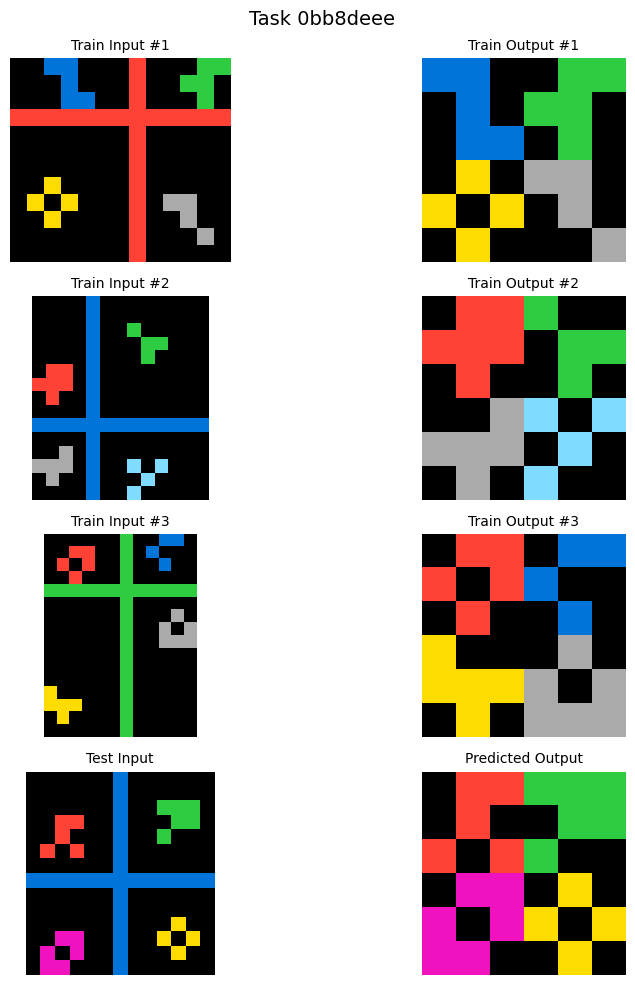

[✔] Displayed Task 0bb8deee


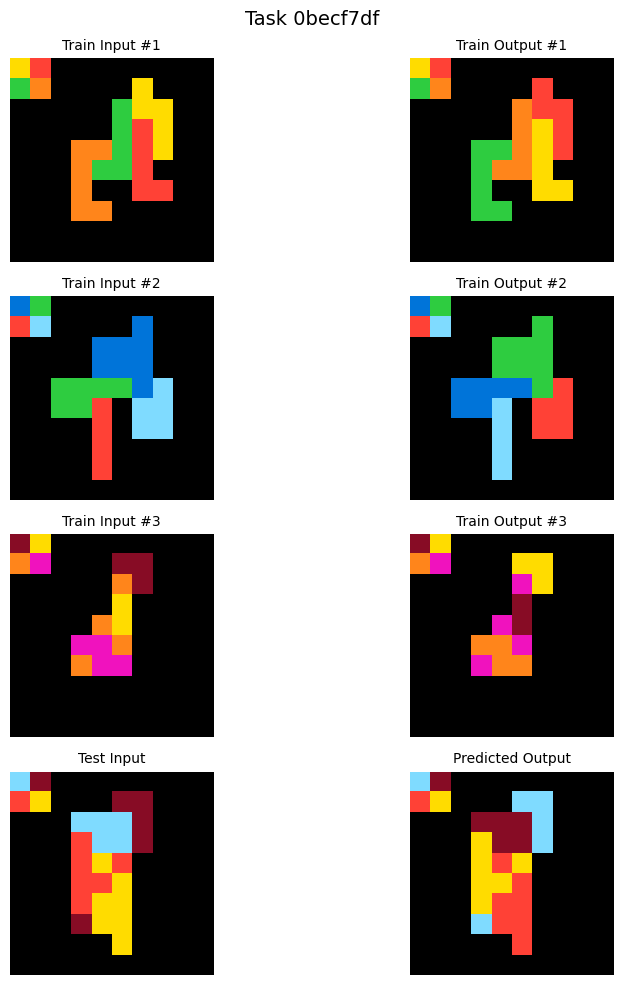

[✔] Displayed Task 0becf7df


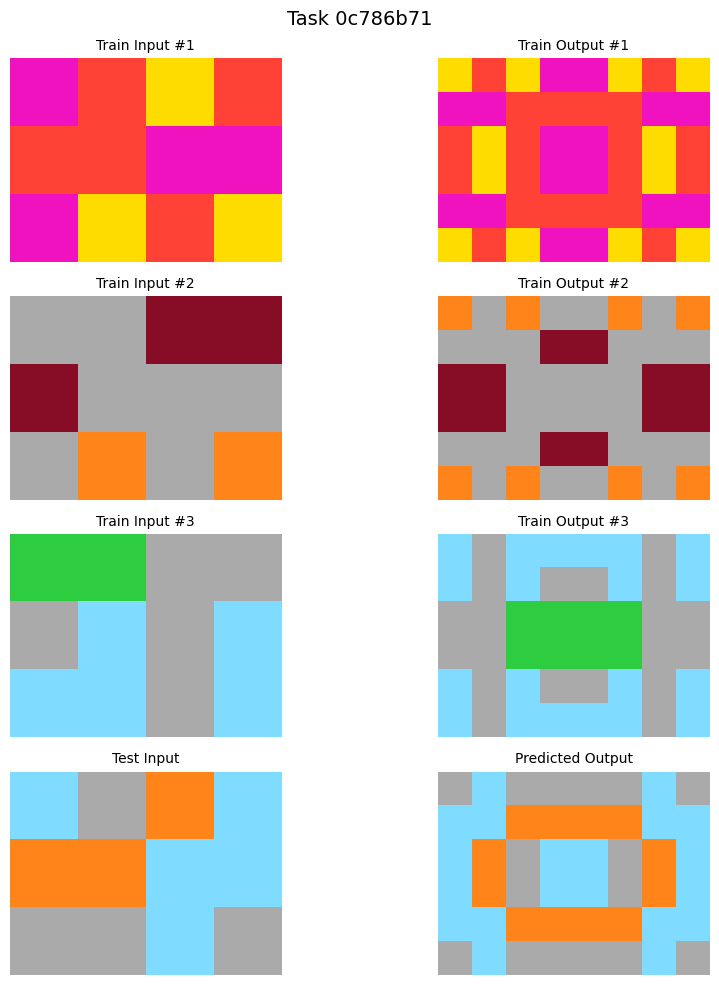

[✔] Displayed Task 0c786b71


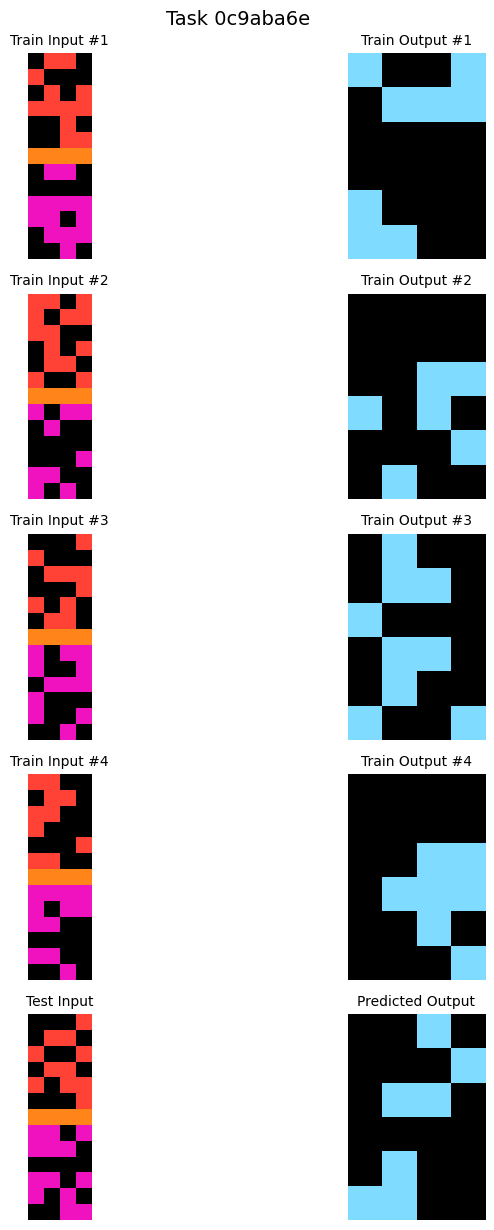

[✔] Displayed Task 0c9aba6e
[✘] Skipped Task 0d87d2a6 (invalid output)


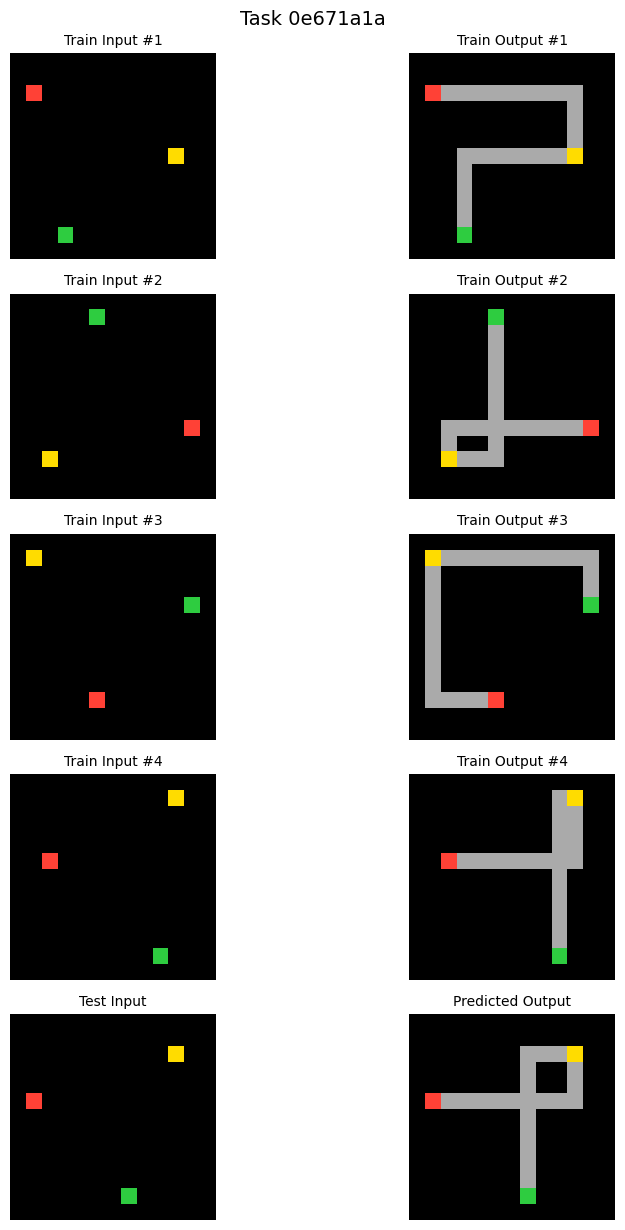

[✔] Displayed Task 0e671a1a


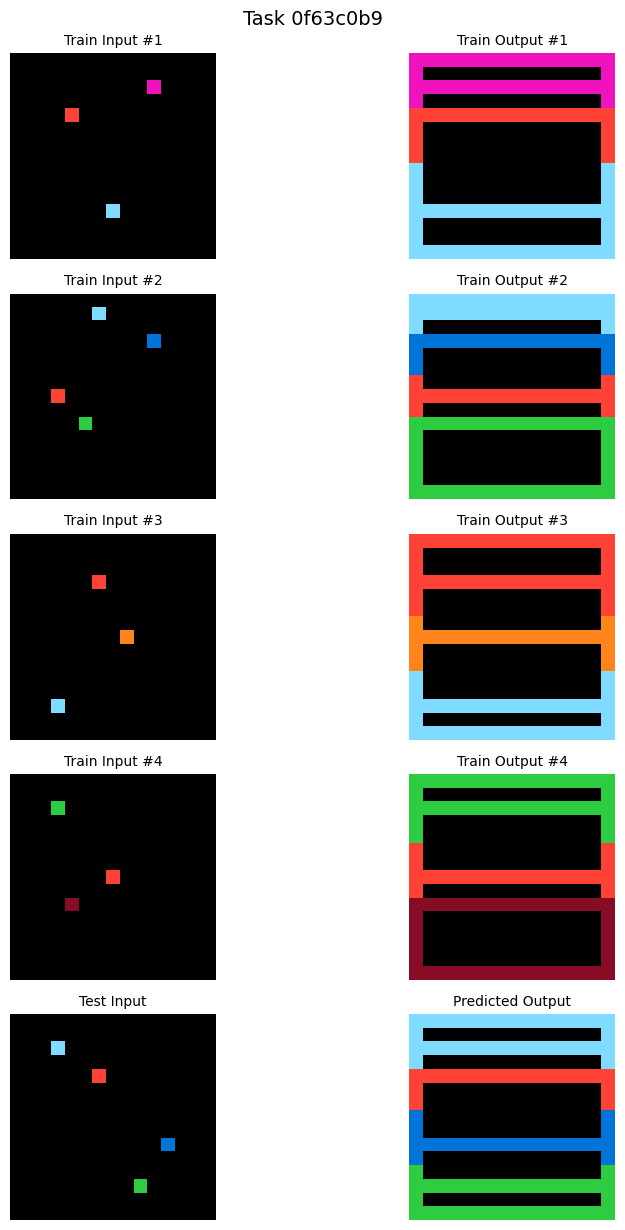

[✔] Displayed Task 0f63c0b9


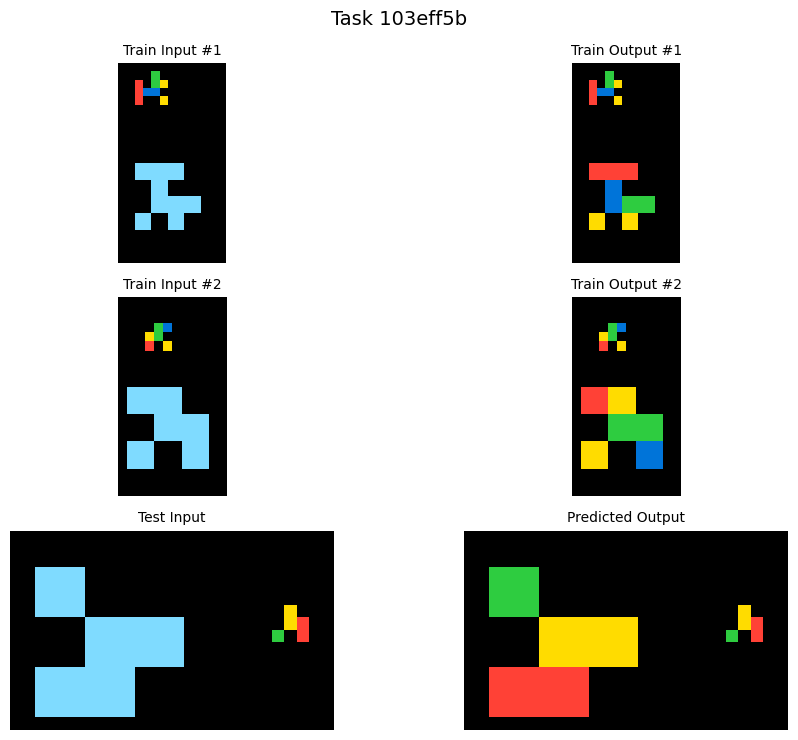

[✔] Displayed Task 103eff5b
[✘] Skipped Task 11e1fe23 (invalid output)


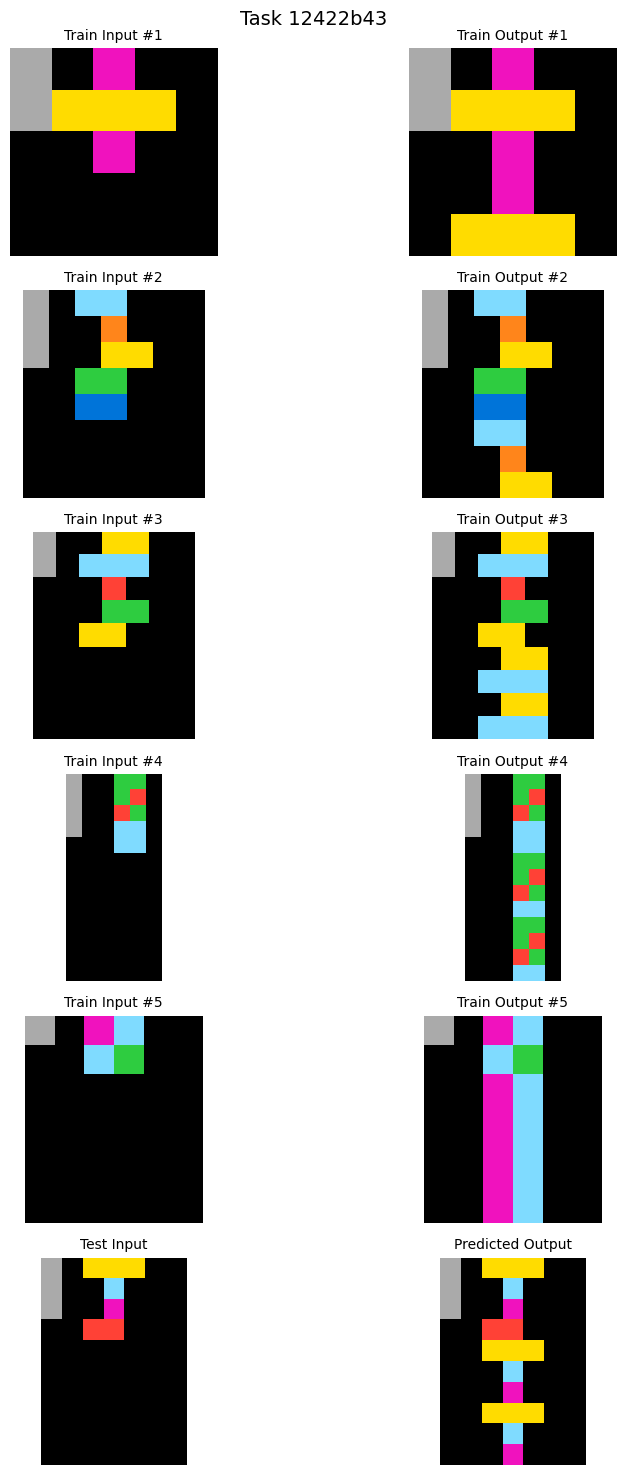

[✔] Displayed Task 12422b43


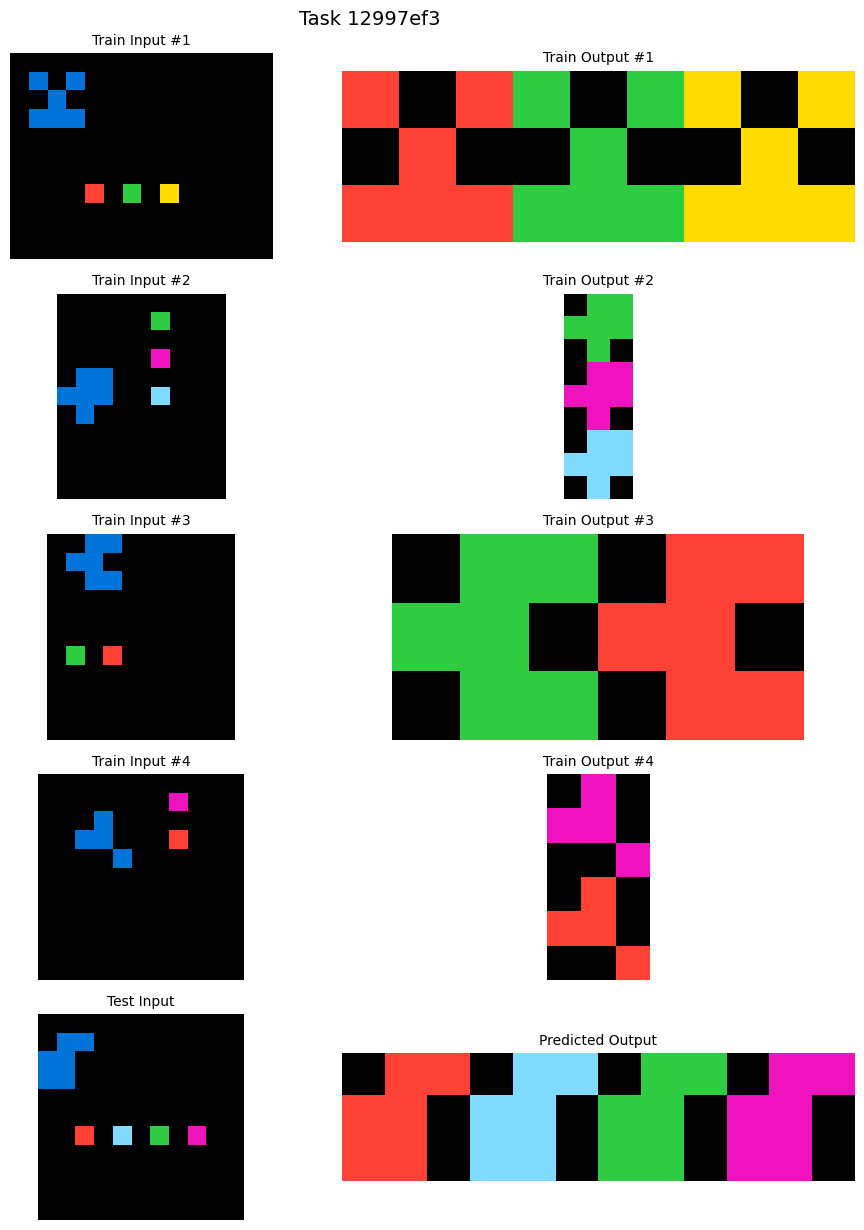

[✔] Displayed Task 12997ef3


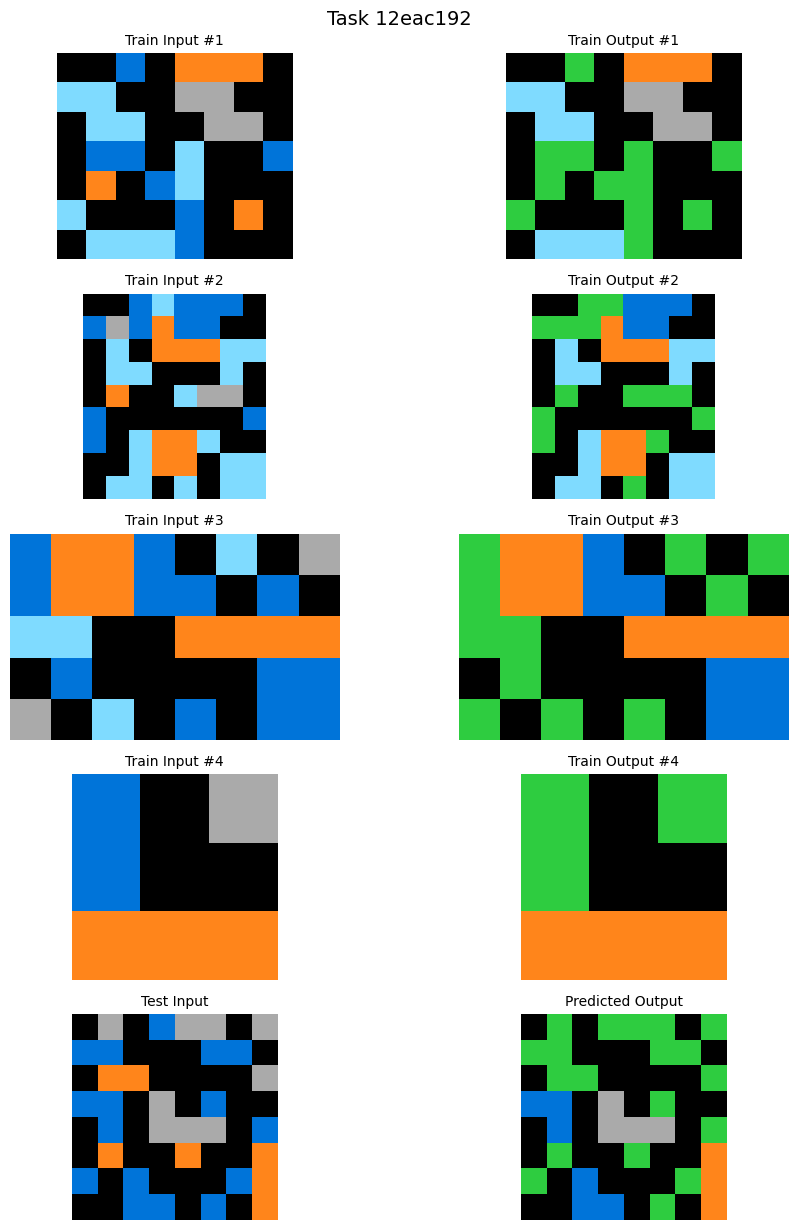

[✔] Displayed Task 12eac192


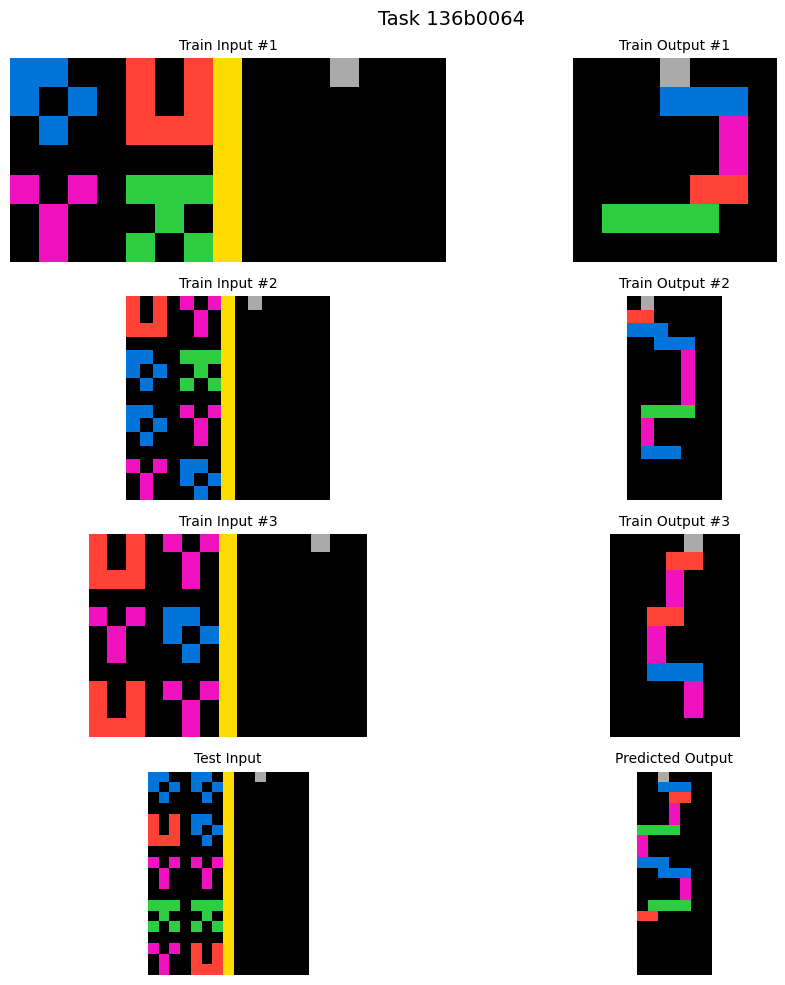

[✔] Displayed Task 136b0064


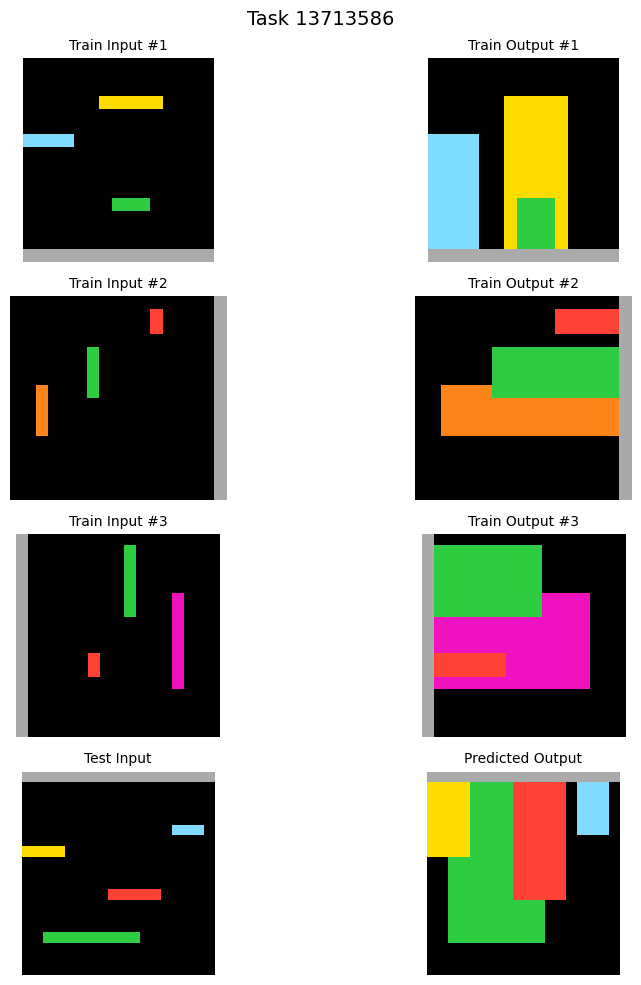

[✔] Displayed Task 13713586


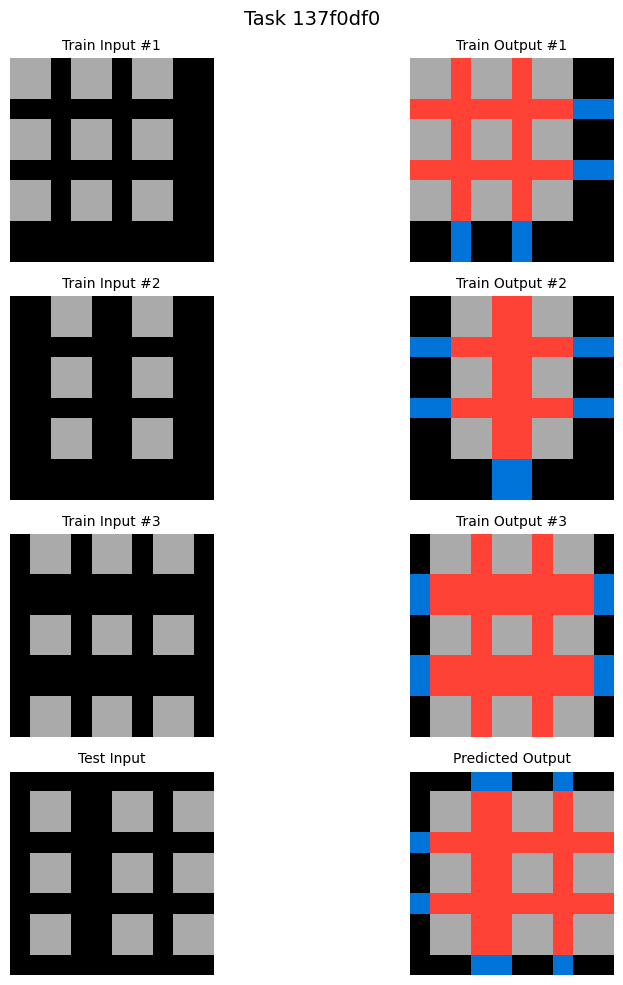

[✔] Displayed Task 137f0df0


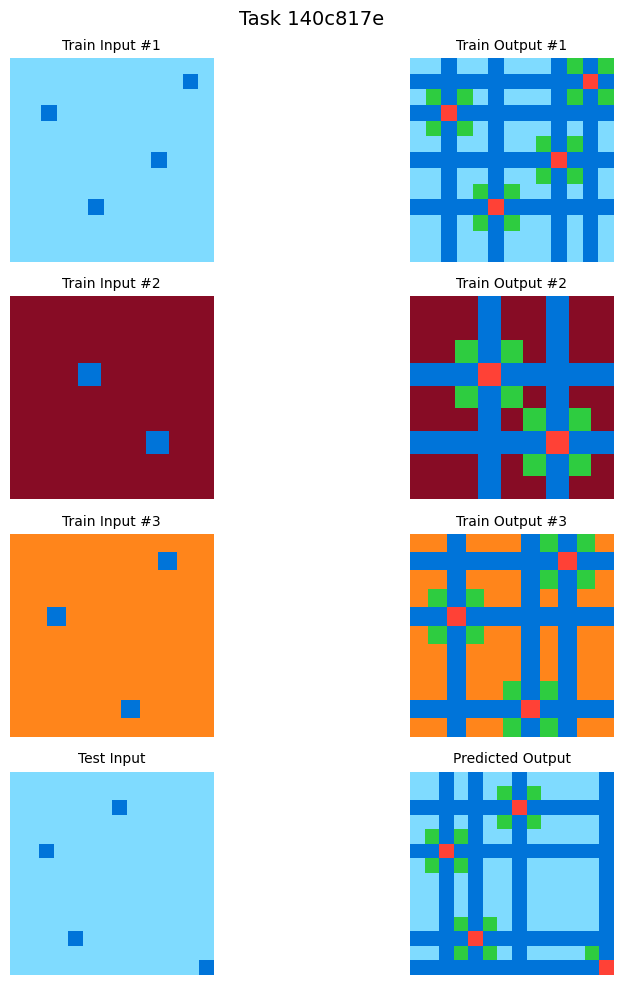

[✔] Displayed Task 140c817e


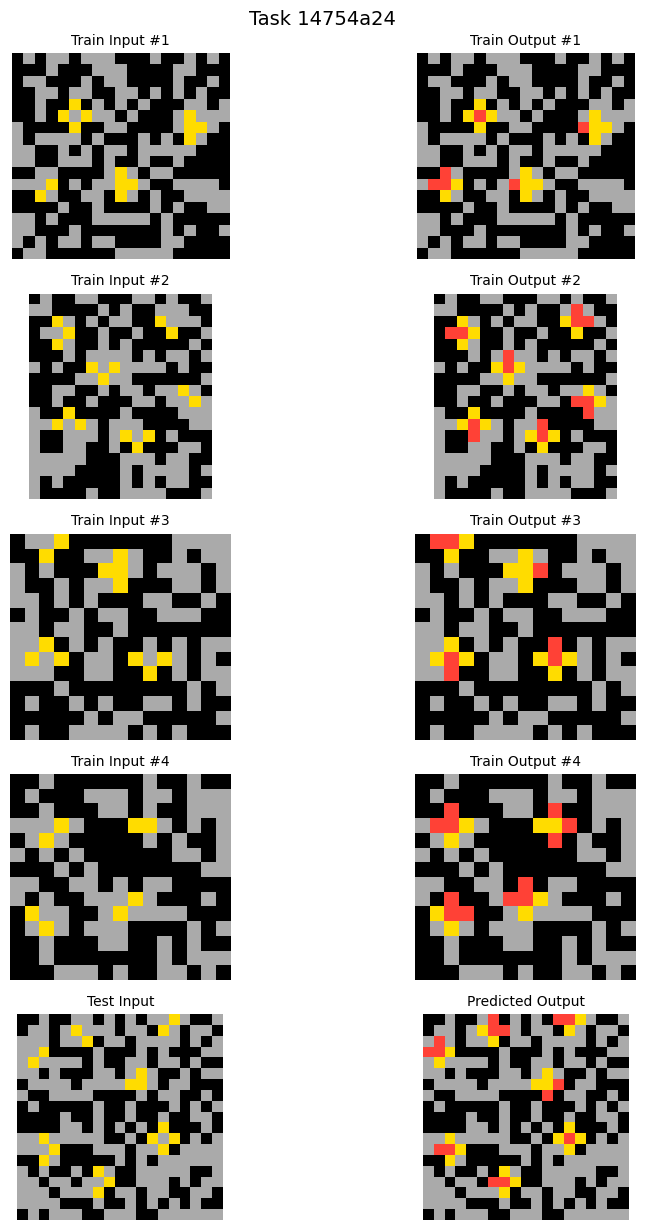

[✔] Displayed Task 14754a24


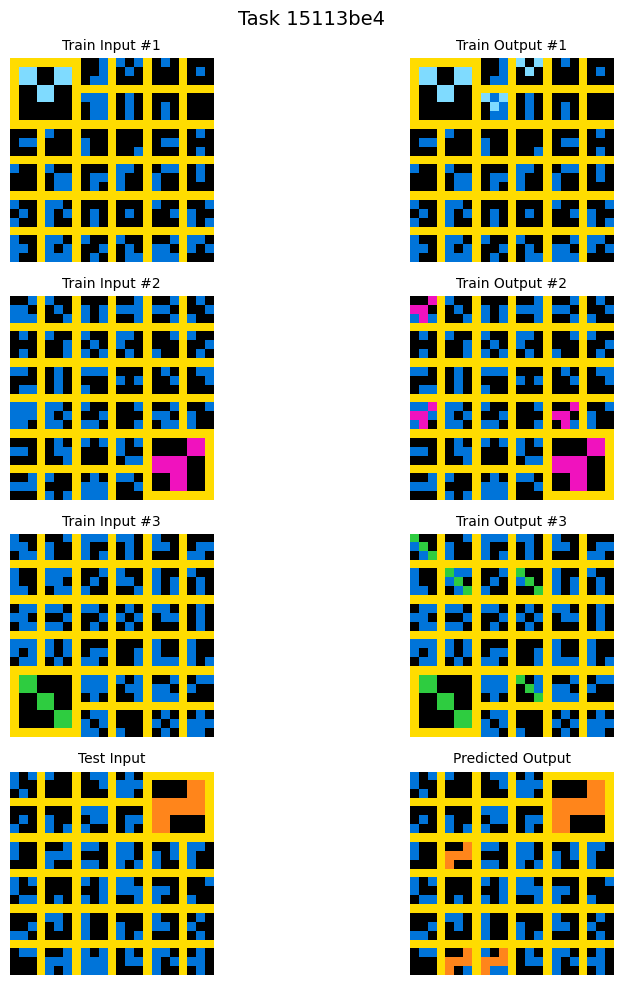

[✔] Displayed Task 15113be4


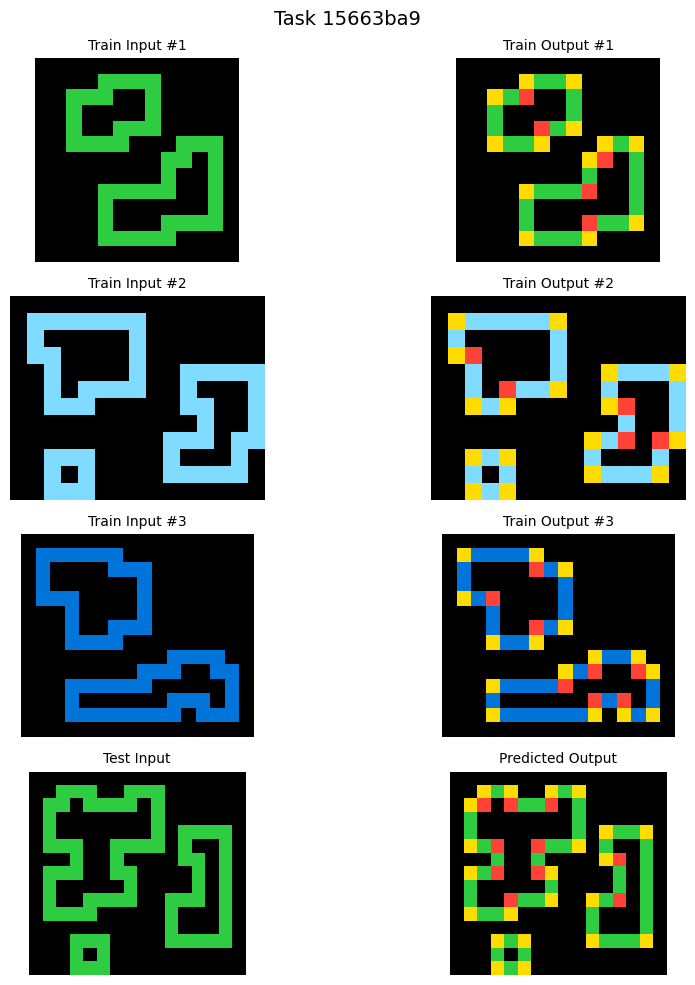

[✔] Displayed Task 15663ba9


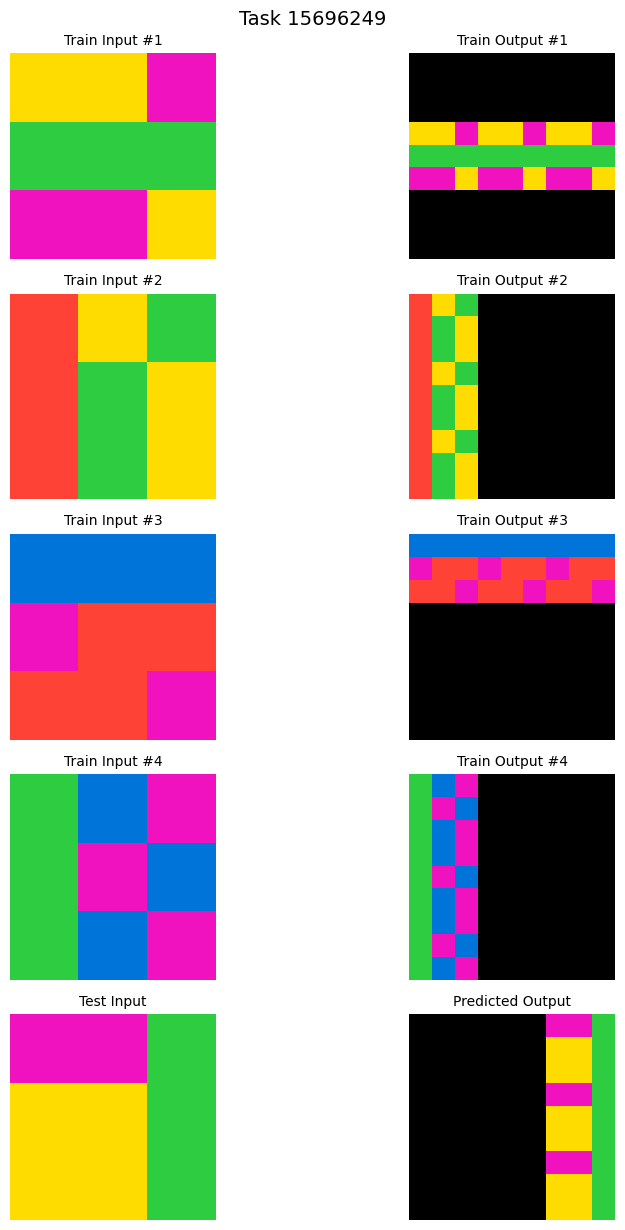

[✔] Displayed Task 15696249


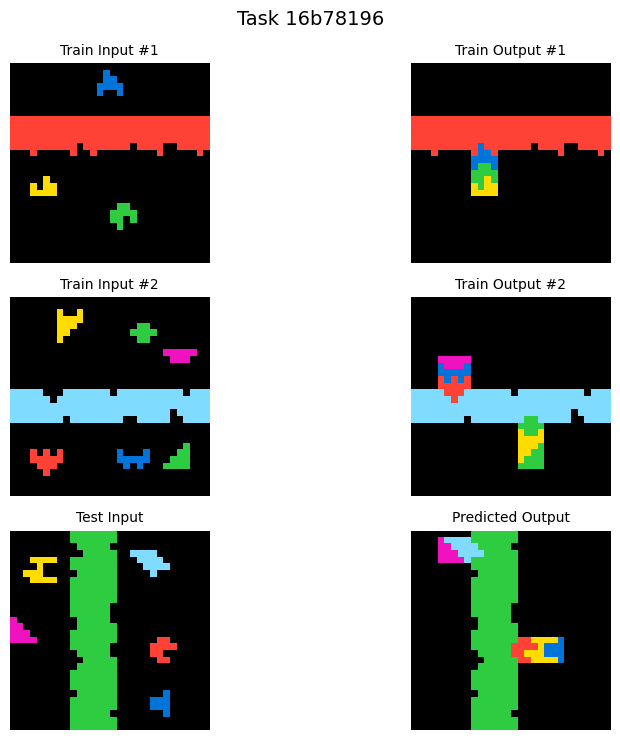

[✔] Displayed Task 16b78196


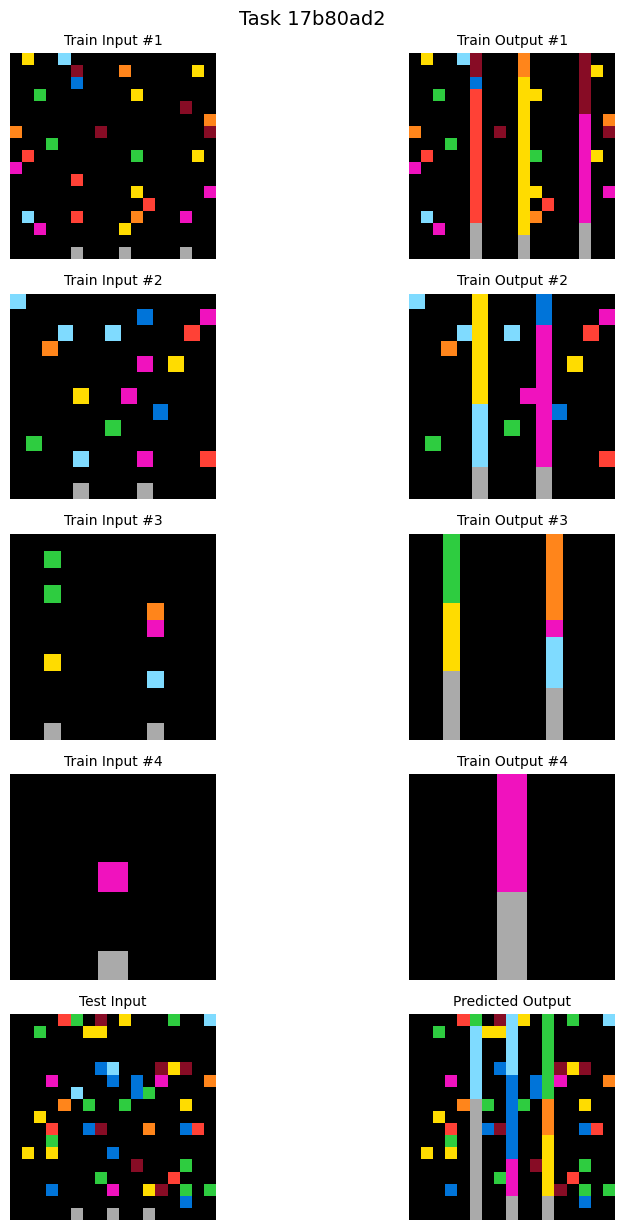

[✔] Displayed Task 17b80ad2


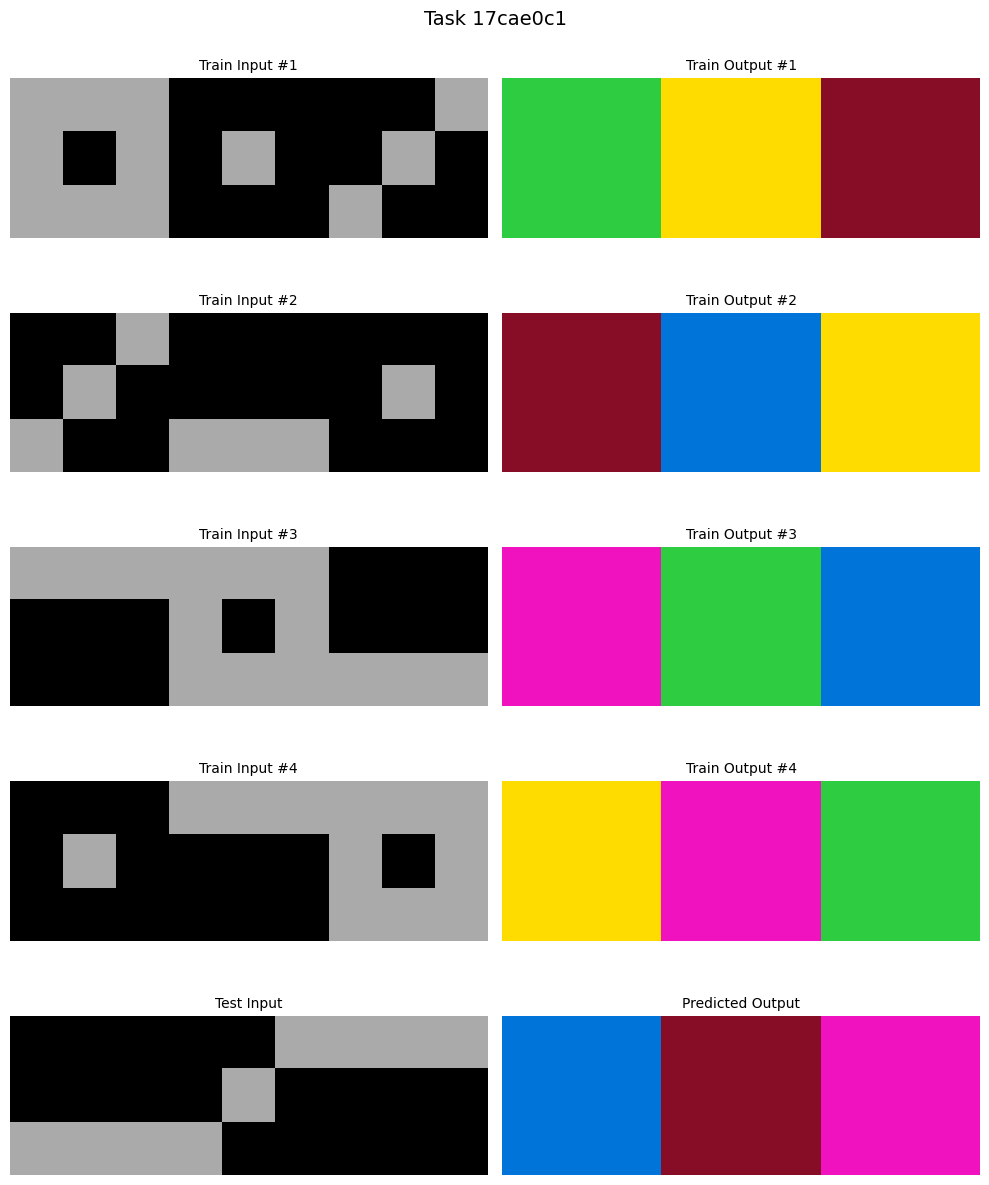

[✔] Displayed Task 17cae0c1


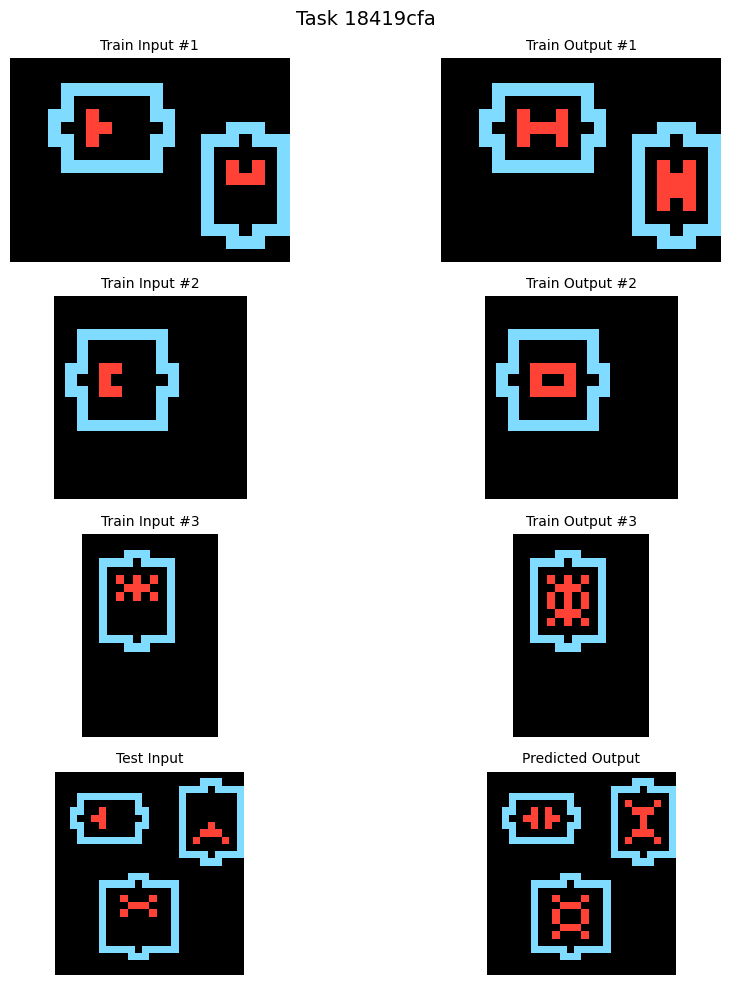

[✔] Displayed Task 18419cfa


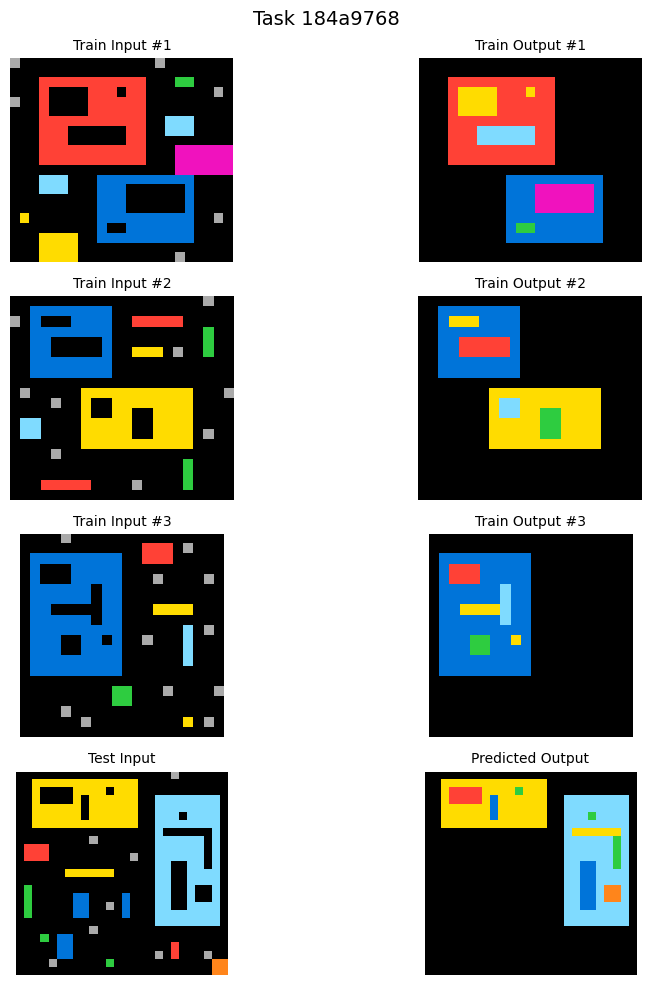

[✔] Displayed Task 184a9768


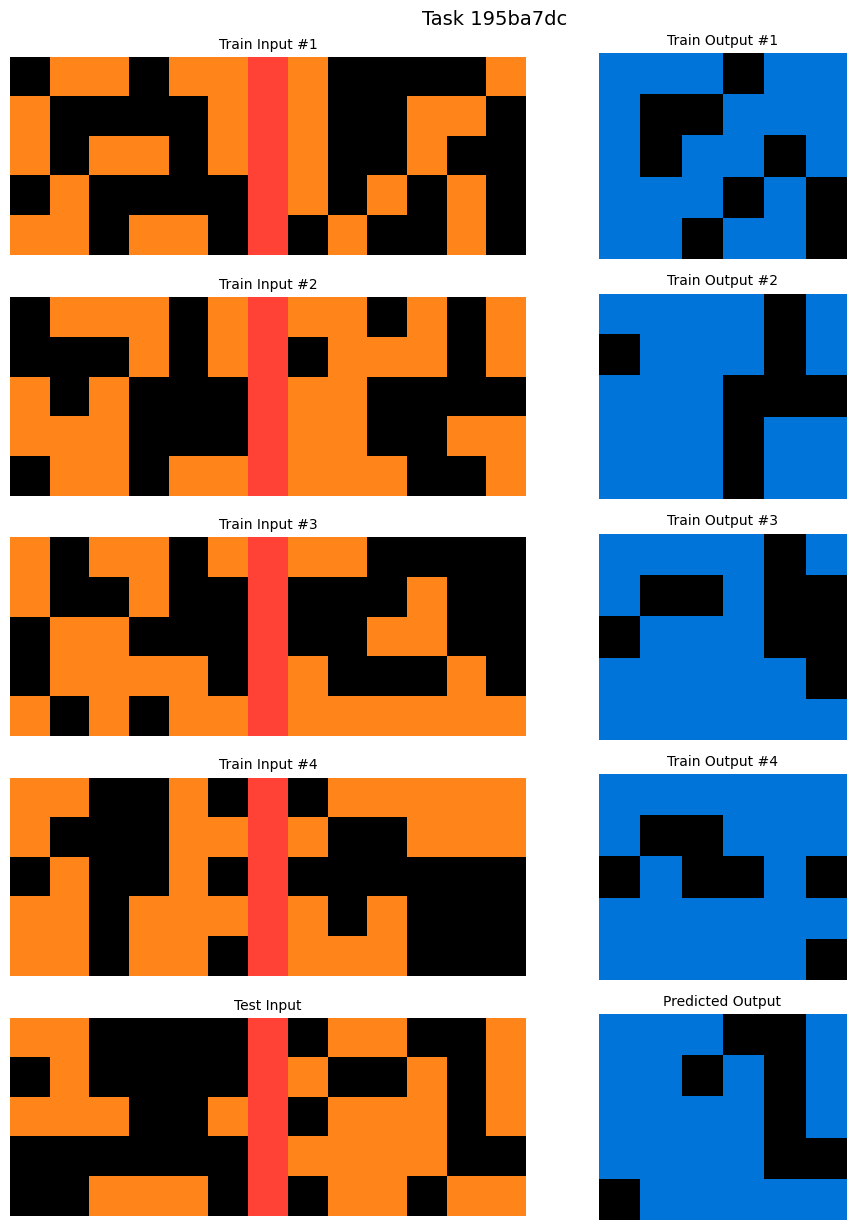

[✔] Displayed Task 195ba7dc


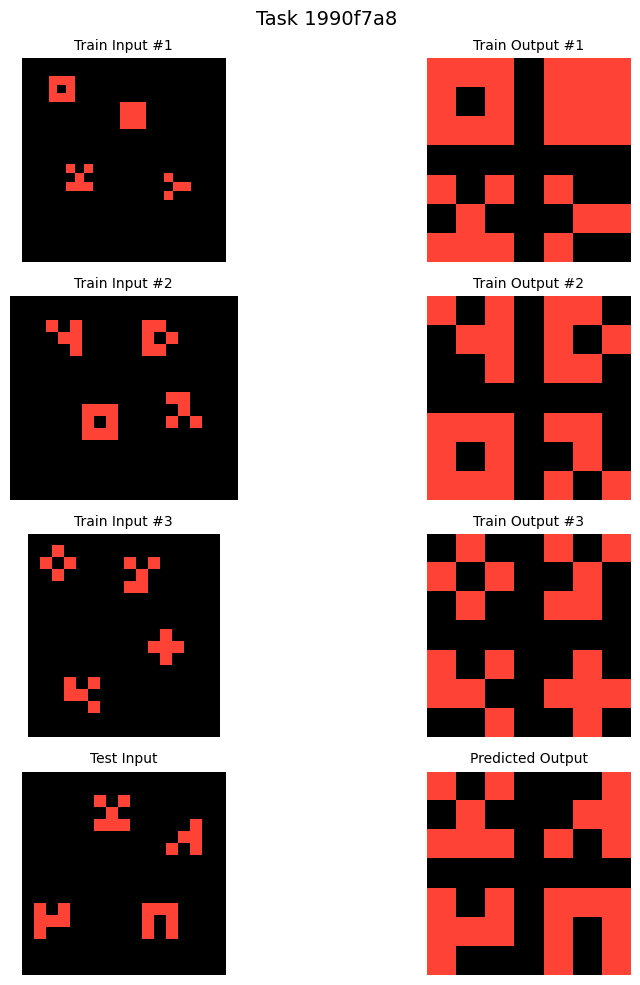

[✔] Displayed Task 1990f7a8


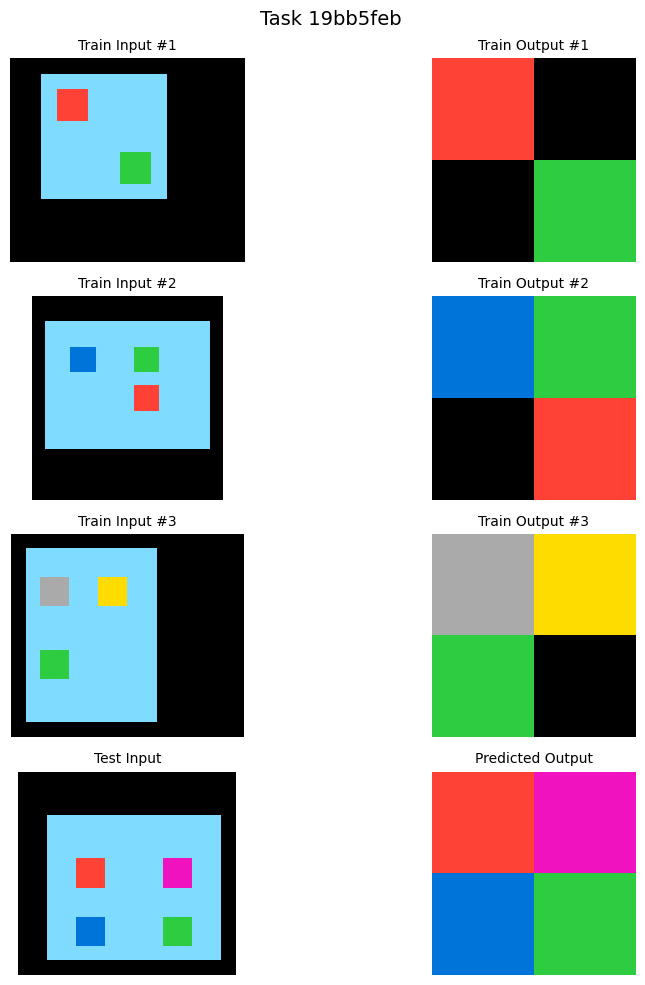

[✔] Displayed Task 19bb5feb
[✘] Skipped Task 1a2e2828 (predicted output is not 2D: shape ())
[✘] Skipped Task 1a2e2828 (missing data)


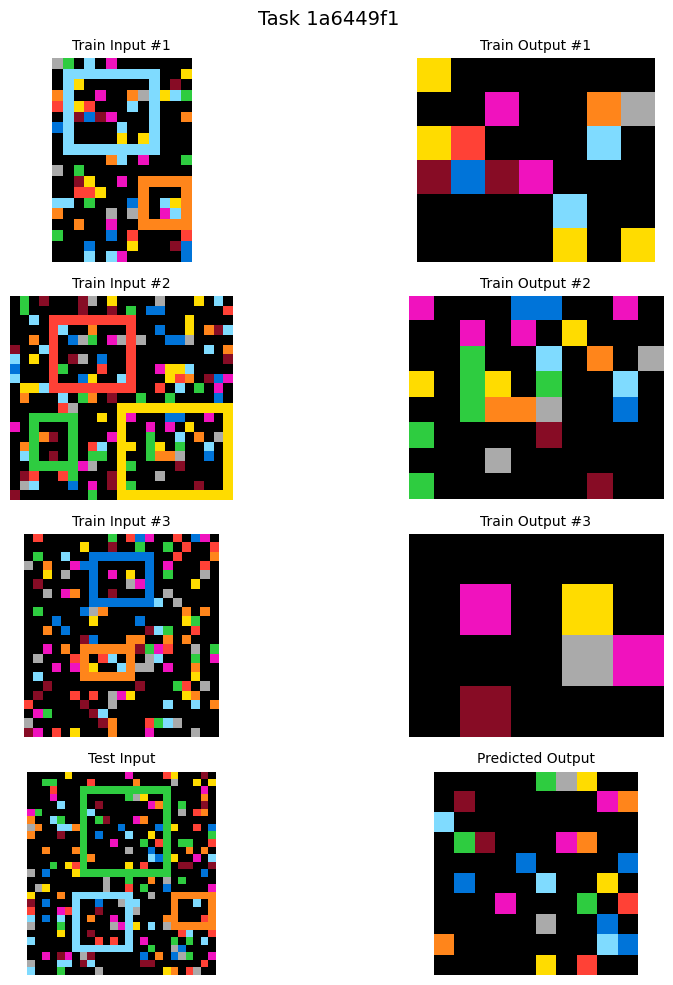

[✔] Displayed Task 1a6449f1


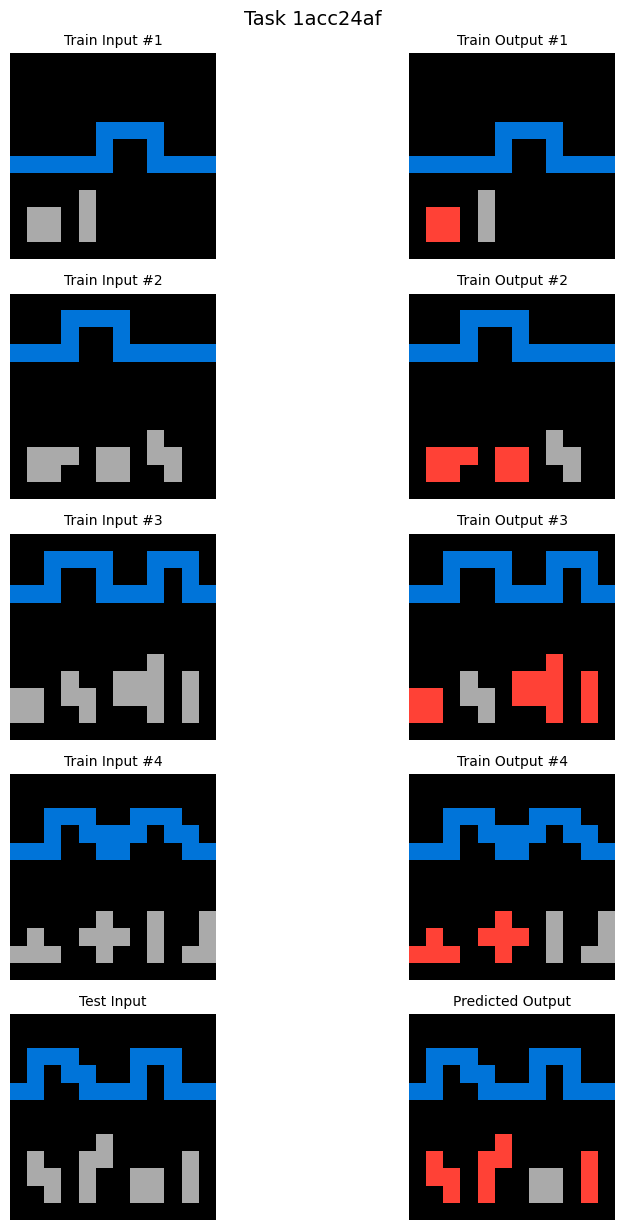

[✔] Displayed Task 1acc24af


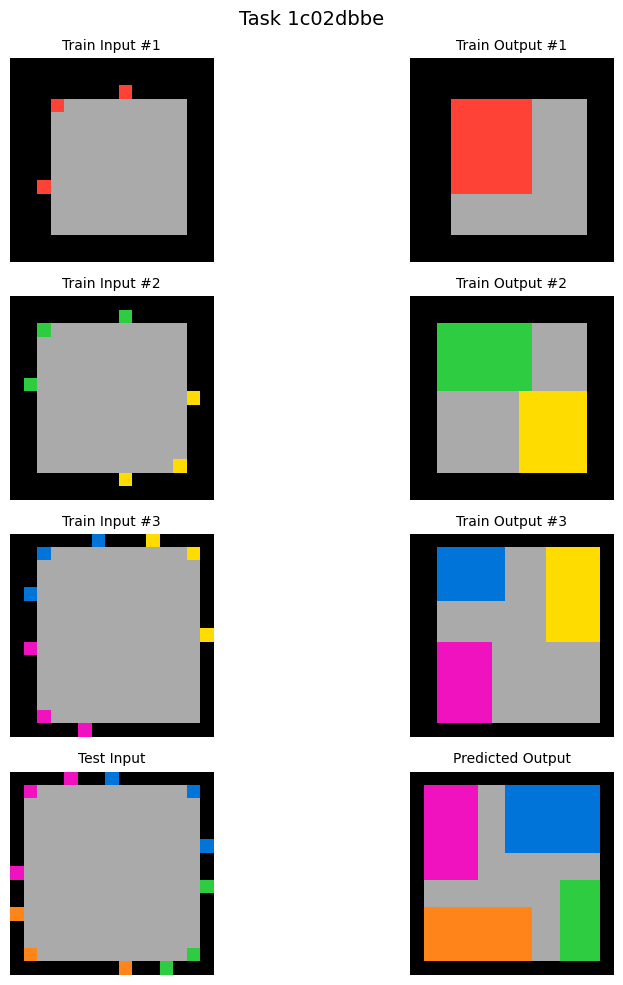

[✔] Displayed Task 1c02dbbe
[✘] Skipped Task 1c0d0a4b (invalid output)


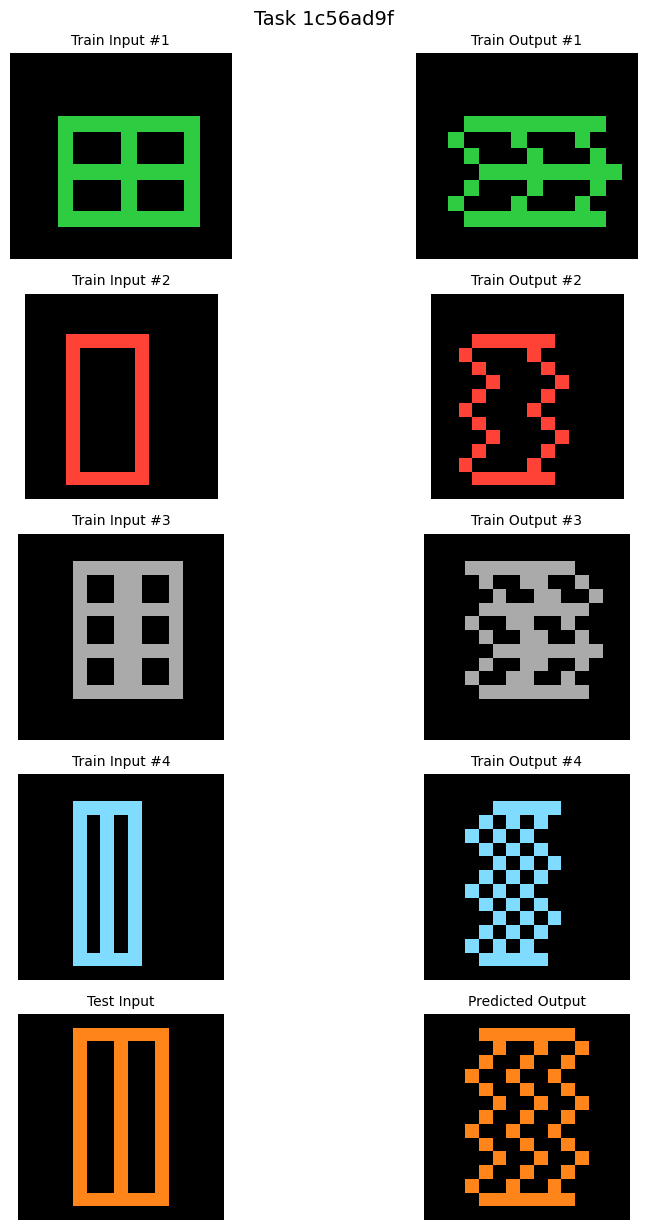

[✔] Displayed Task 1c56ad9f
[✘] Skipped Task 1d0a4b61 (invalid output)


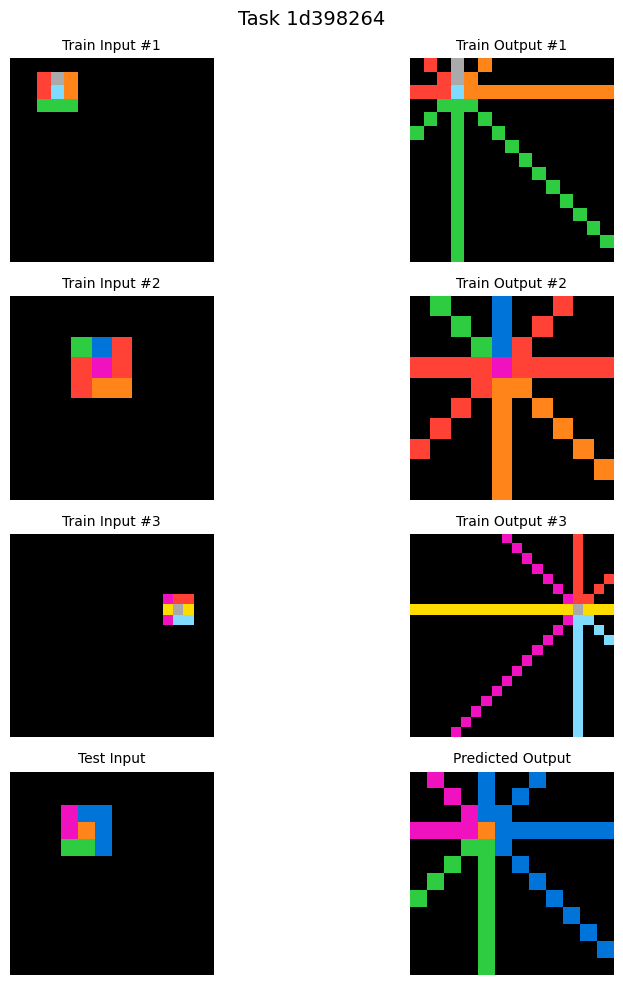

[✔] Displayed Task 1d398264
[✘] Skipped Task 1da012fc (invalid output)


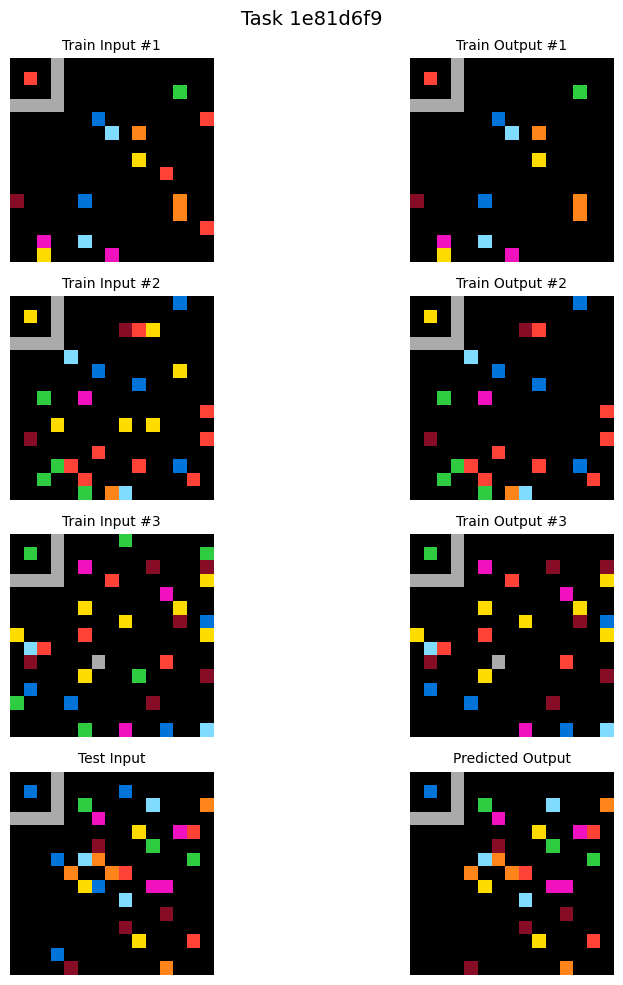

[✔] Displayed Task 1e81d6f9
[✘] Skipped Task 1e97544e (invalid output)


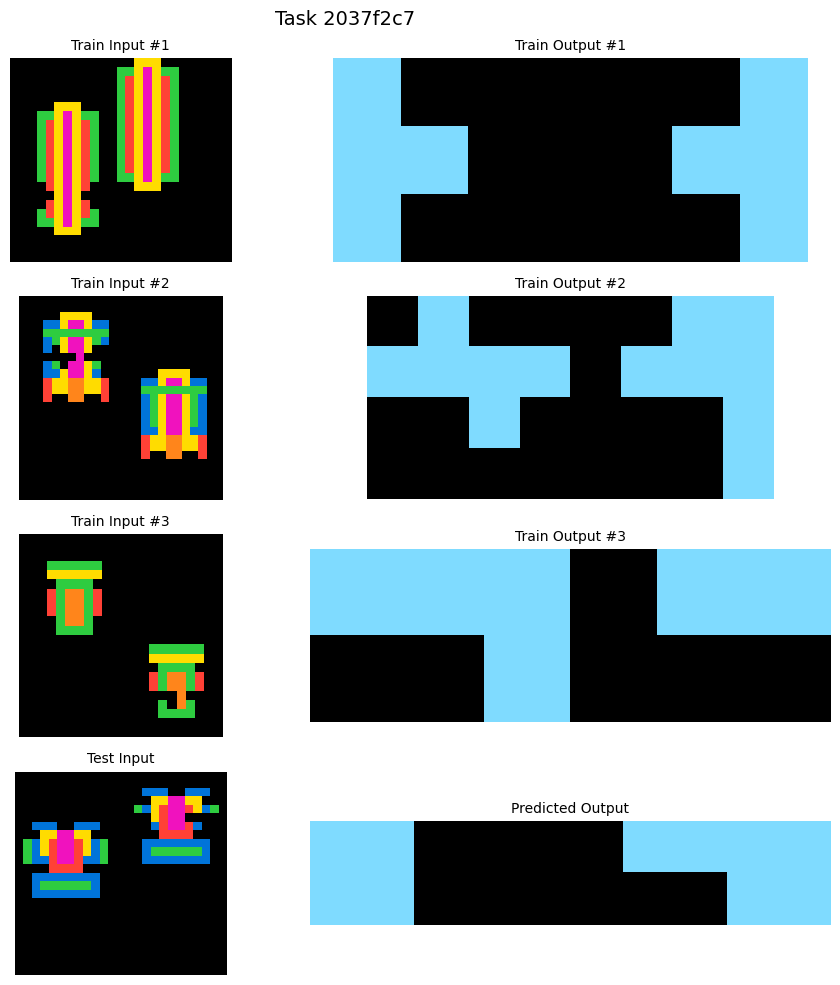

[✔] Displayed Task 2037f2c7


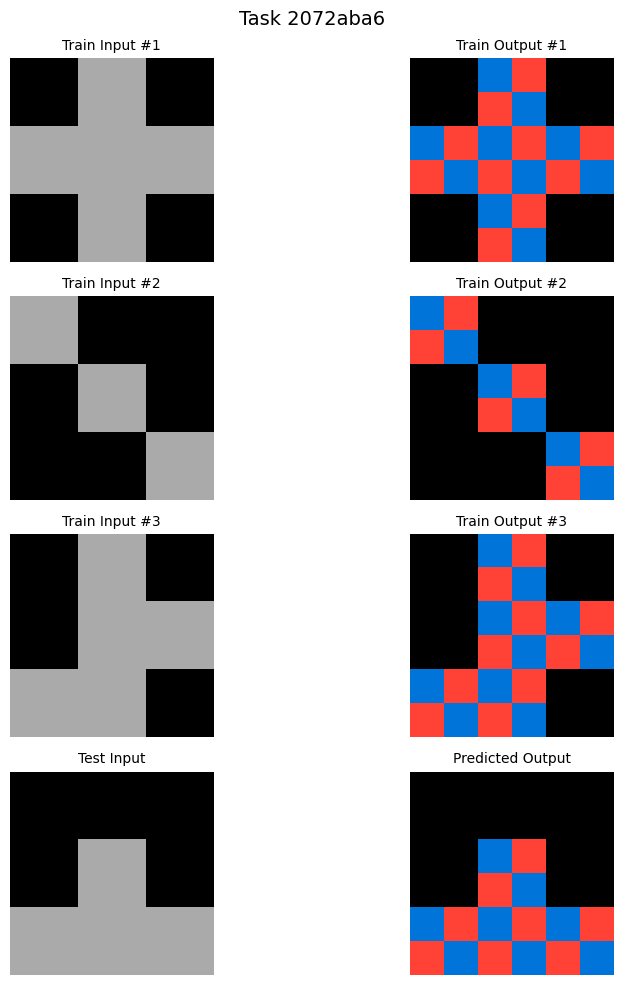

[✔] Displayed Task 2072aba6


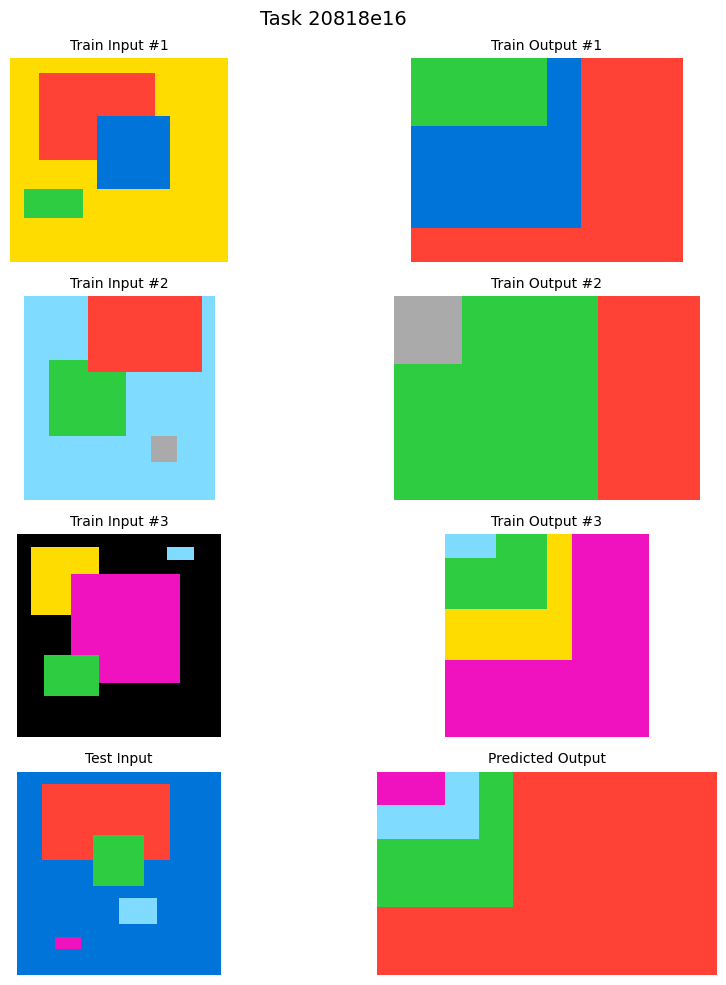

[✔] Displayed Task 20818e16


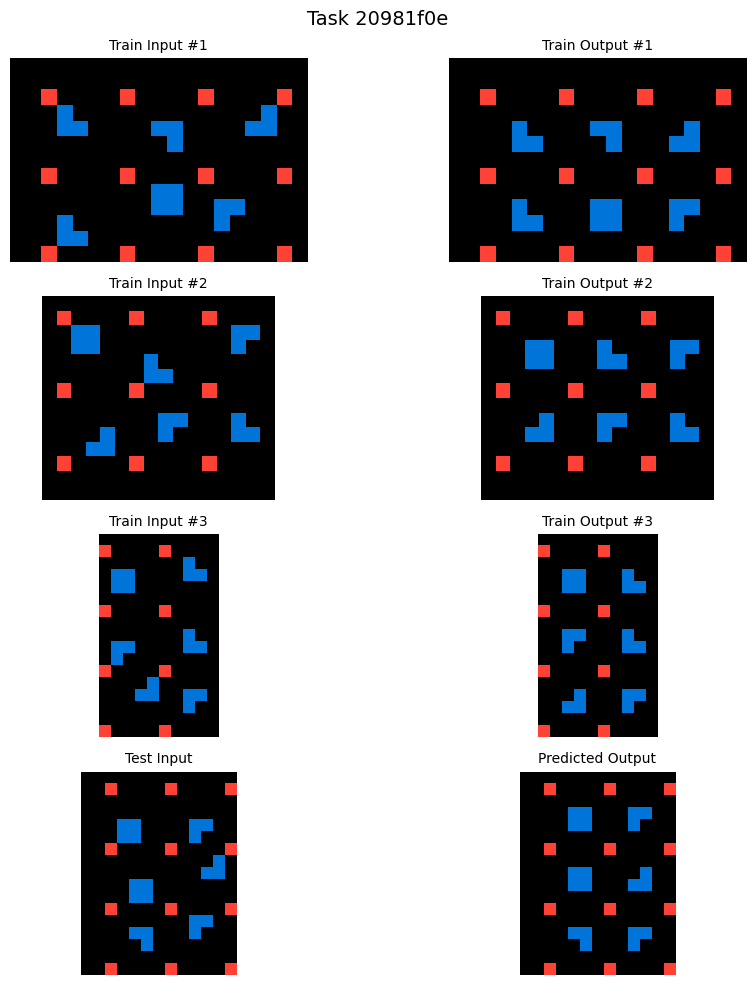

[✔] Displayed Task 20981f0e
[✘] Skipped Task 212895b5 (invalid output)


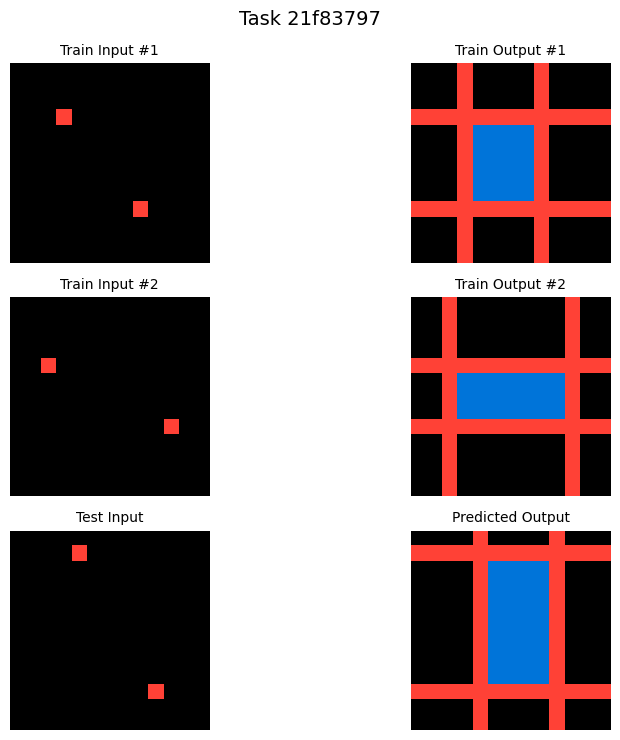

[✔] Displayed Task 21f83797


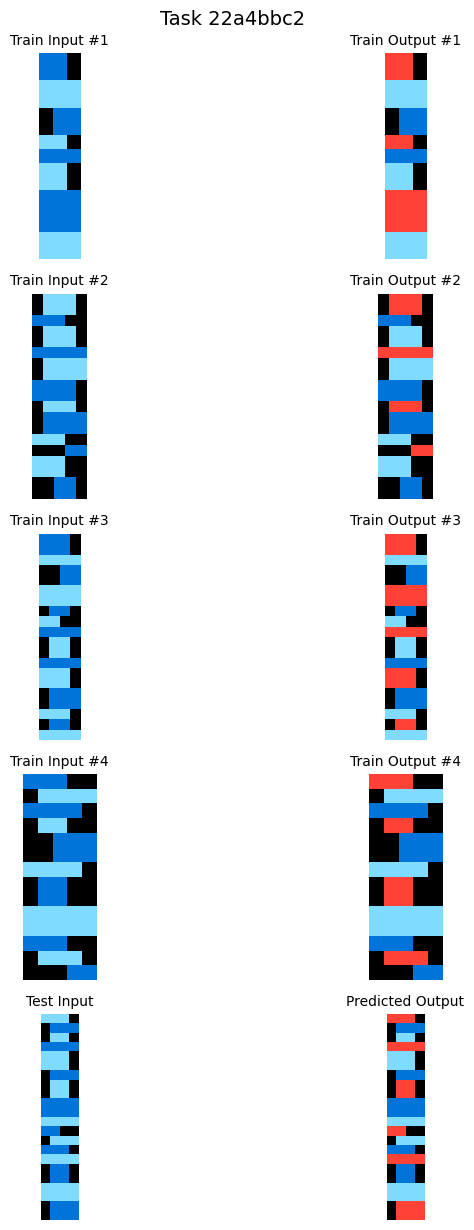

[✔] Displayed Task 22a4bbc2
[✘] Skipped Task 25094a63 (invalid output)


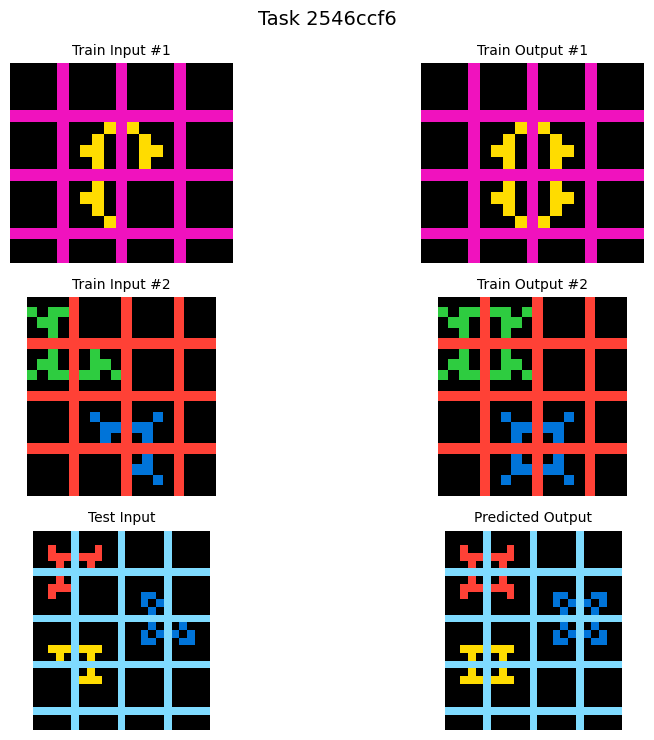

[✔] Displayed Task 2546ccf6
[✘] Skipped Task 256b0a75 (invalid output)


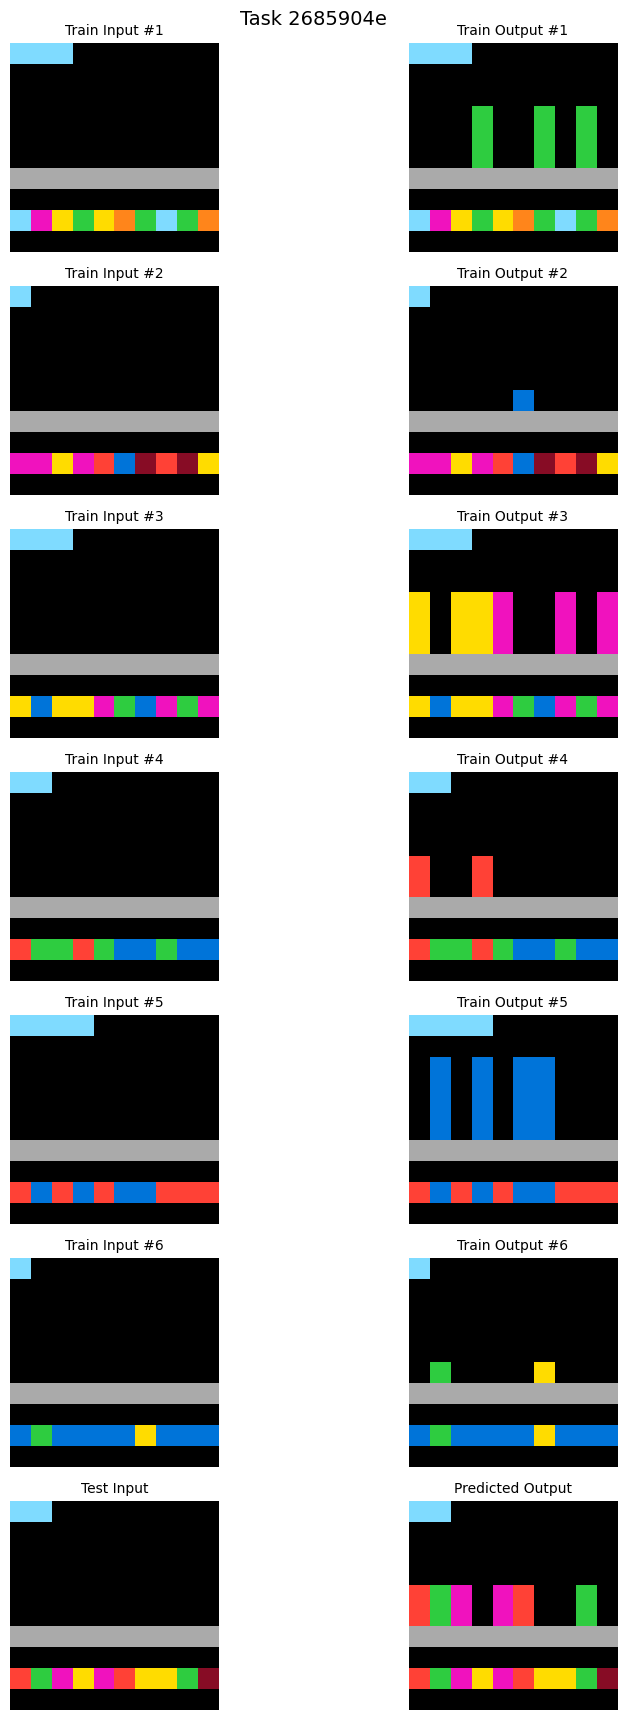

[✔] Displayed Task 2685904e


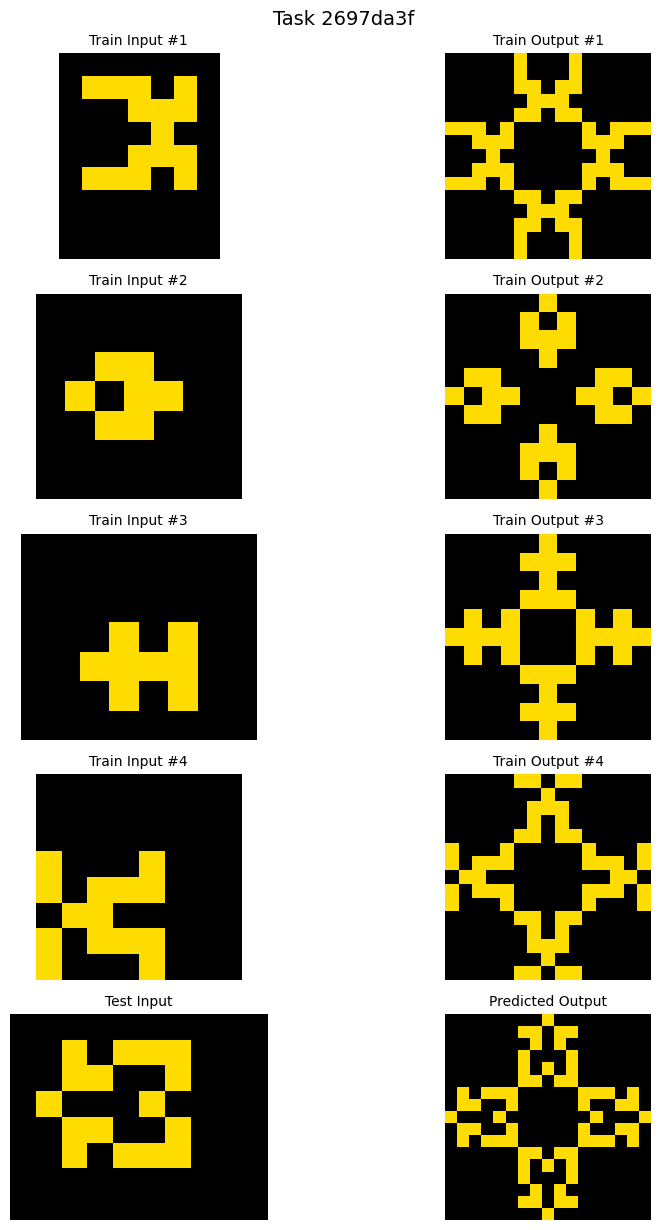

[✔] Displayed Task 2697da3f


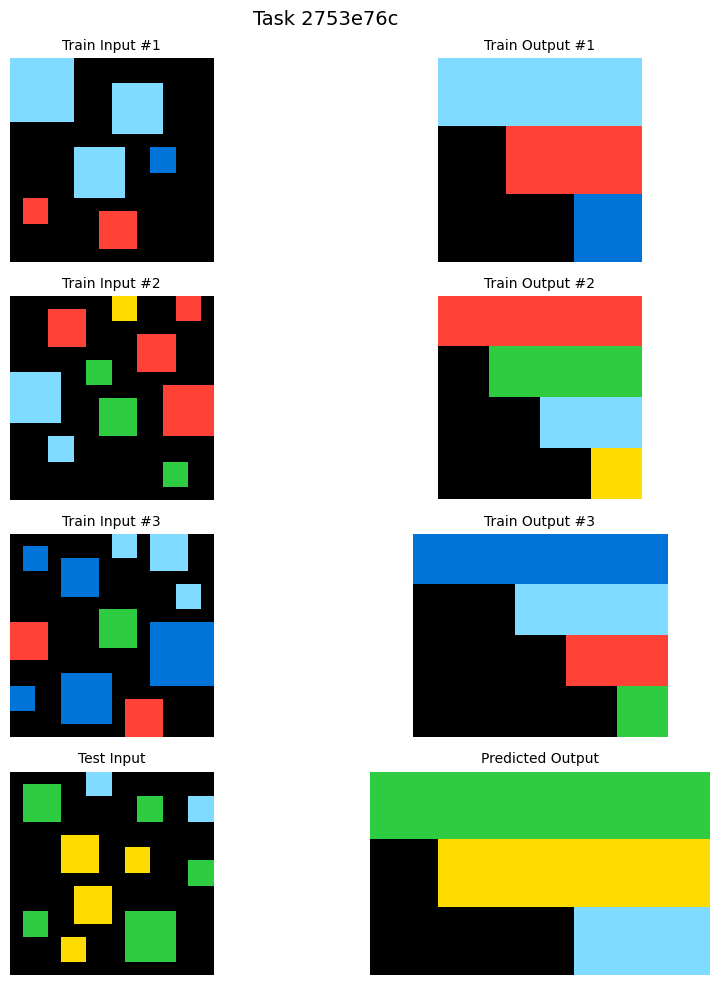

[✔] Displayed Task 2753e76c


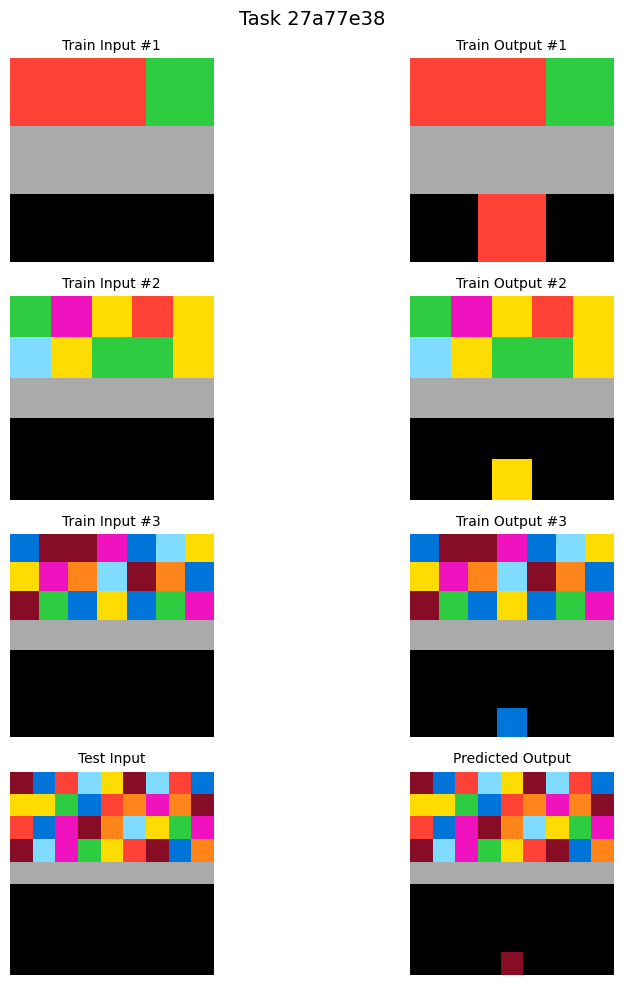

[✔] Displayed Task 27a77e38
[✘] Skipped Task 27f8ce4f (invalid output)


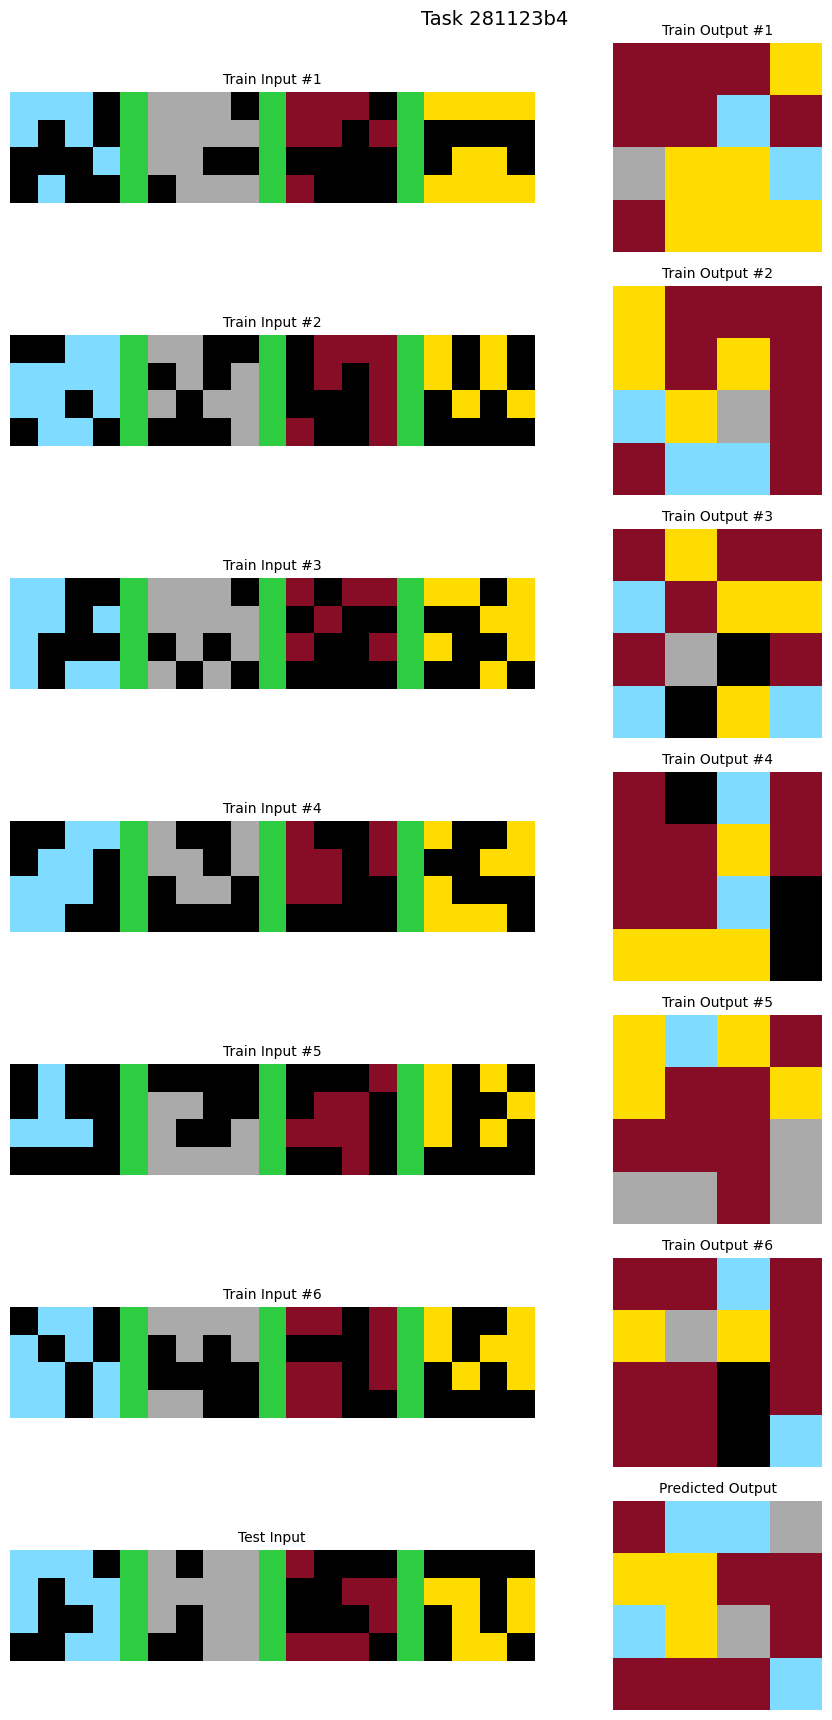

[✔] Displayed Task 281123b4


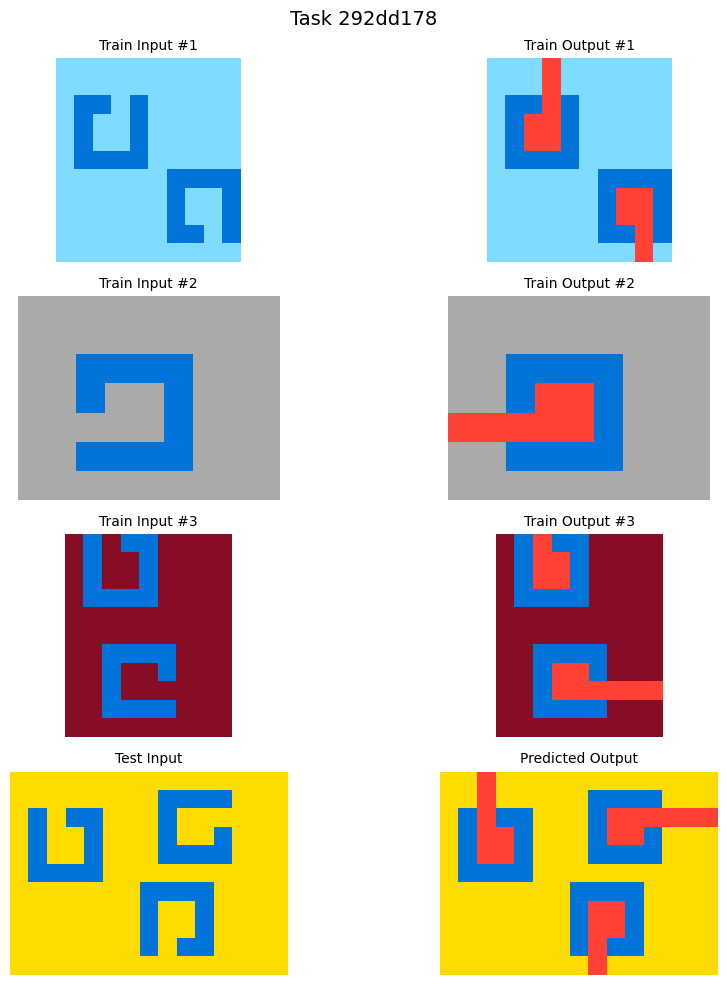

[✔] Displayed Task 292dd178


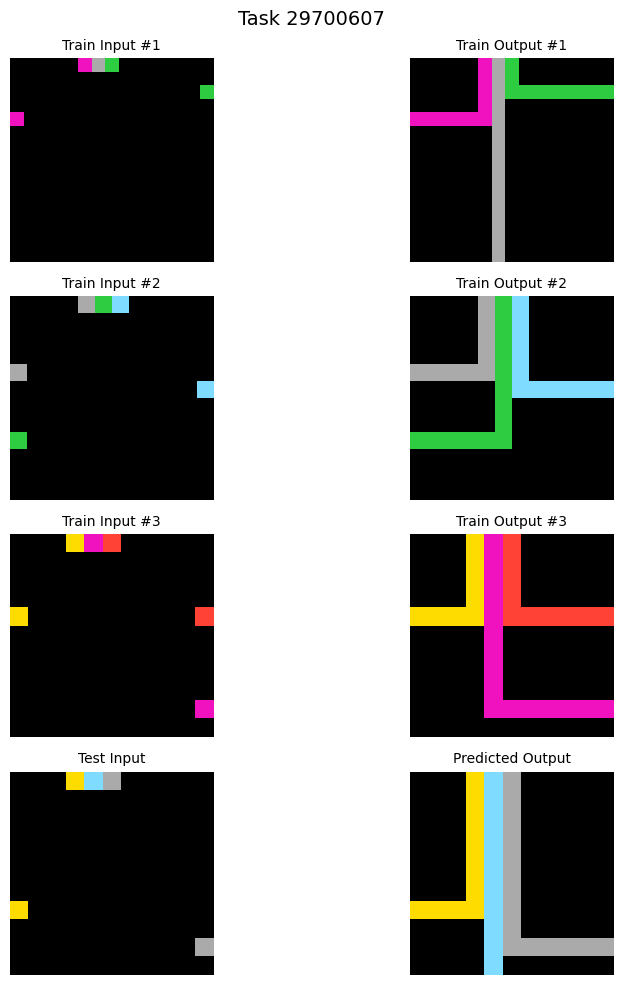

[✔] Displayed Task 29700607


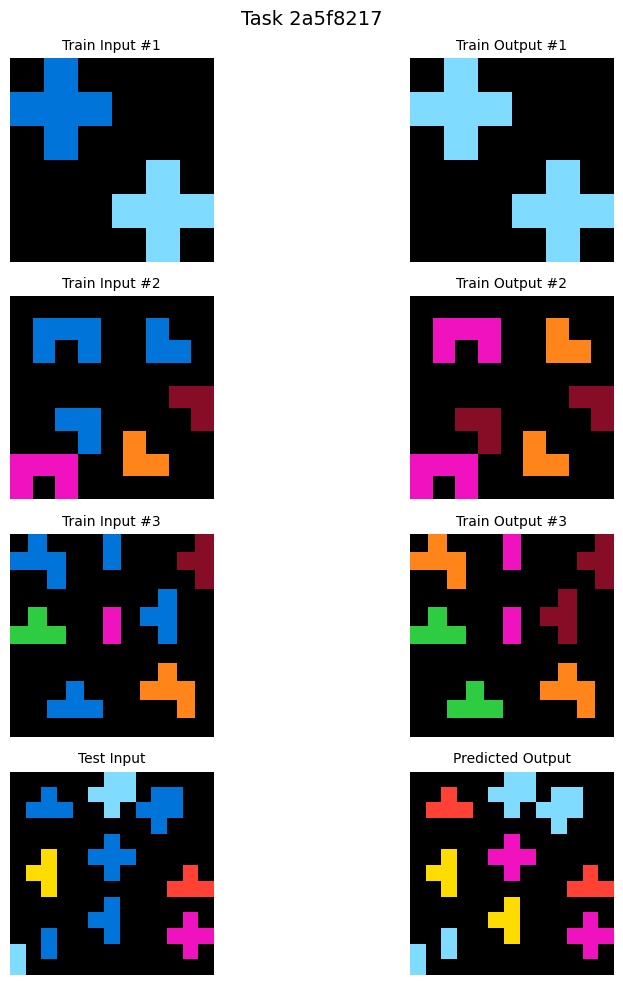

[✔] Displayed Task 2a5f8217
[✘] Skipped Task 2b01abd0 (invalid output)
[✘] Skipped Task 2c0b0aff (invalid output)


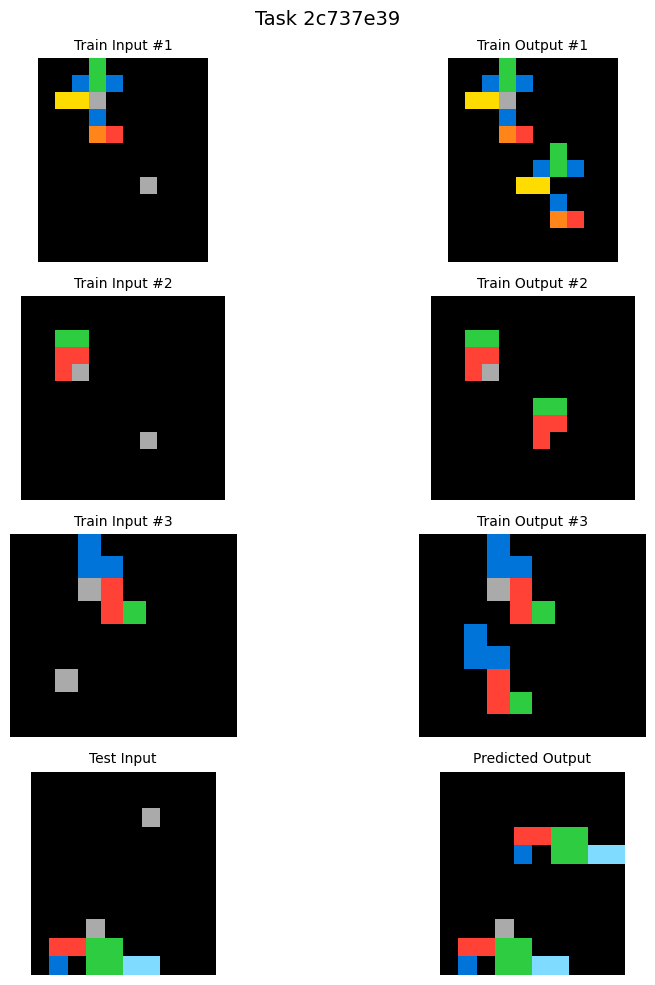

[✔] Displayed Task 2c737e39


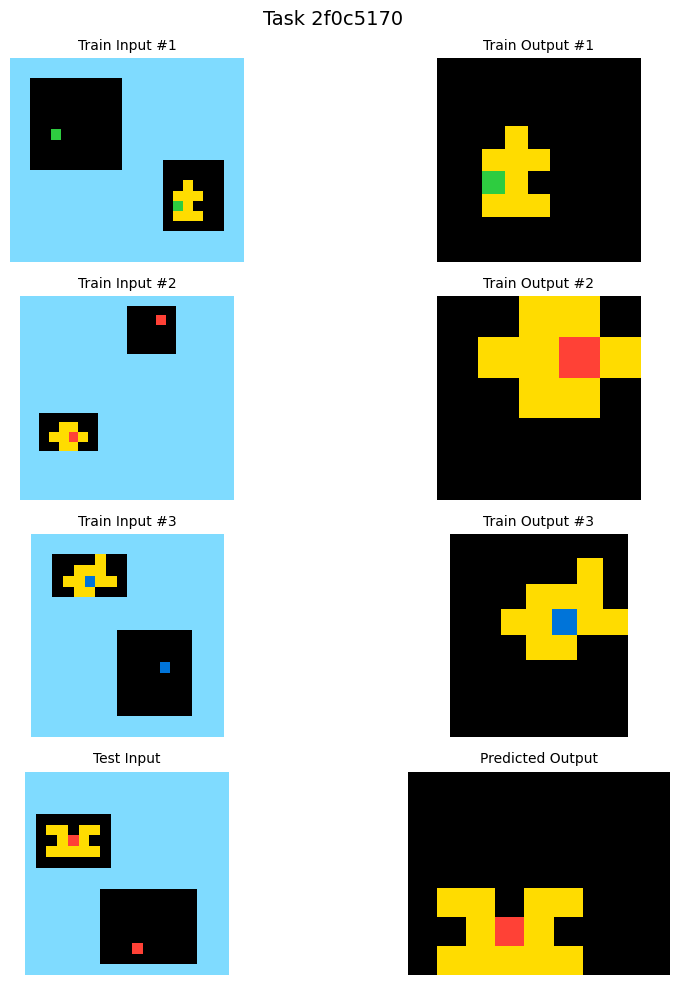

[✔] Displayed Task 2f0c5170


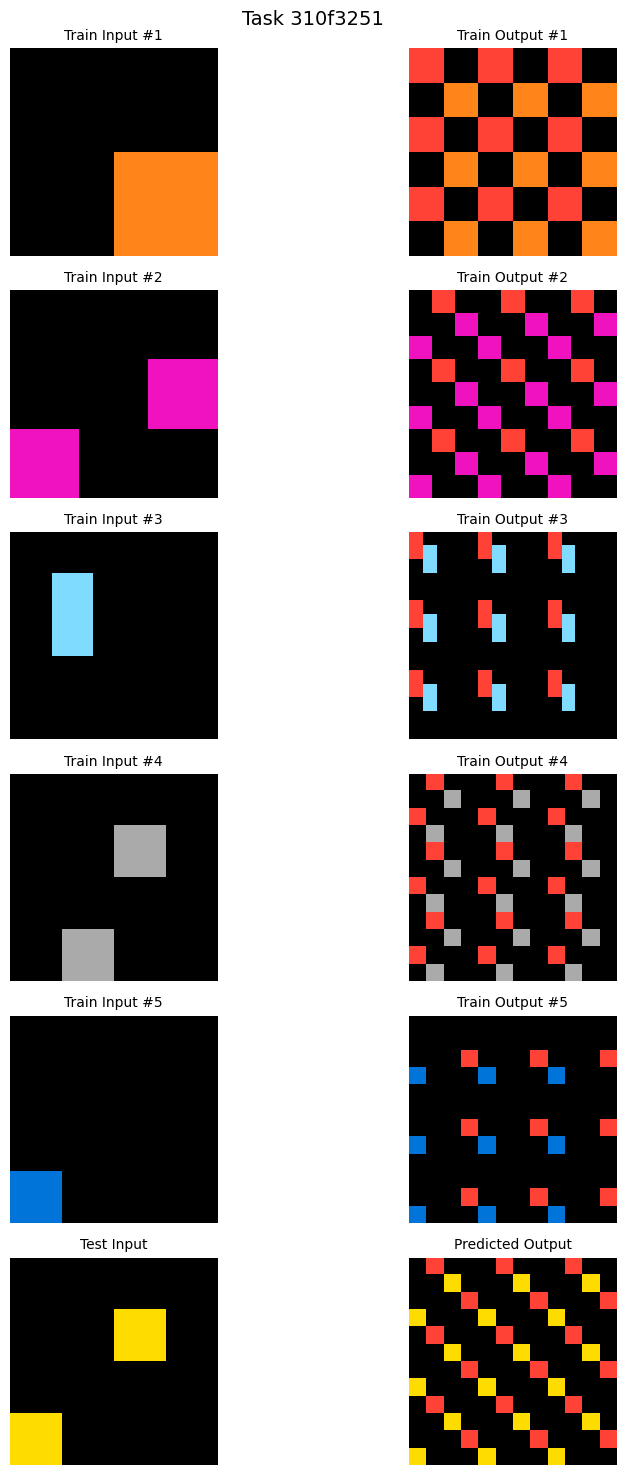

[✔] Displayed Task 310f3251


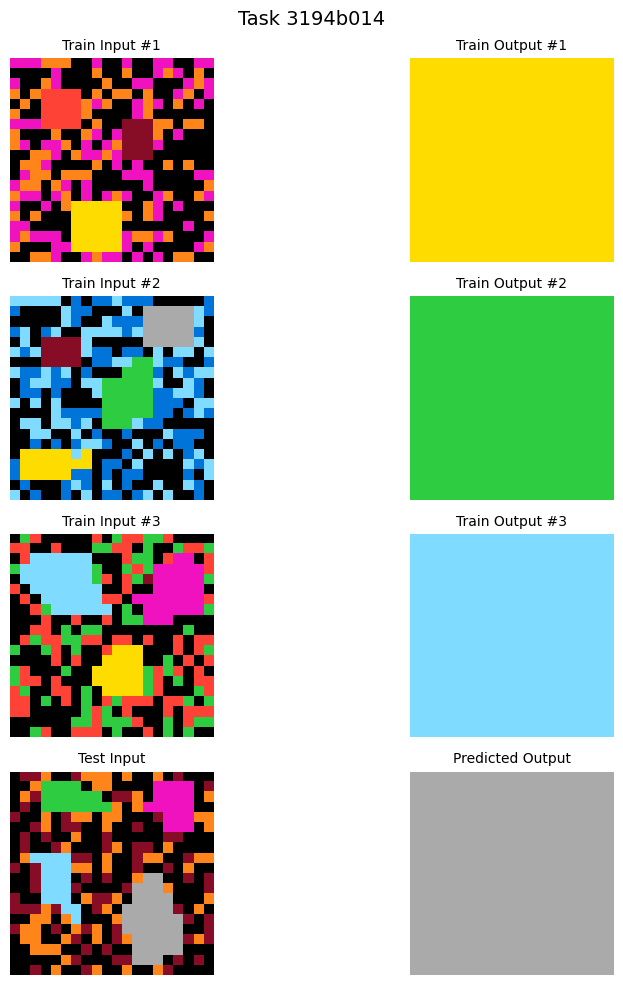

[✔] Displayed Task 3194b014


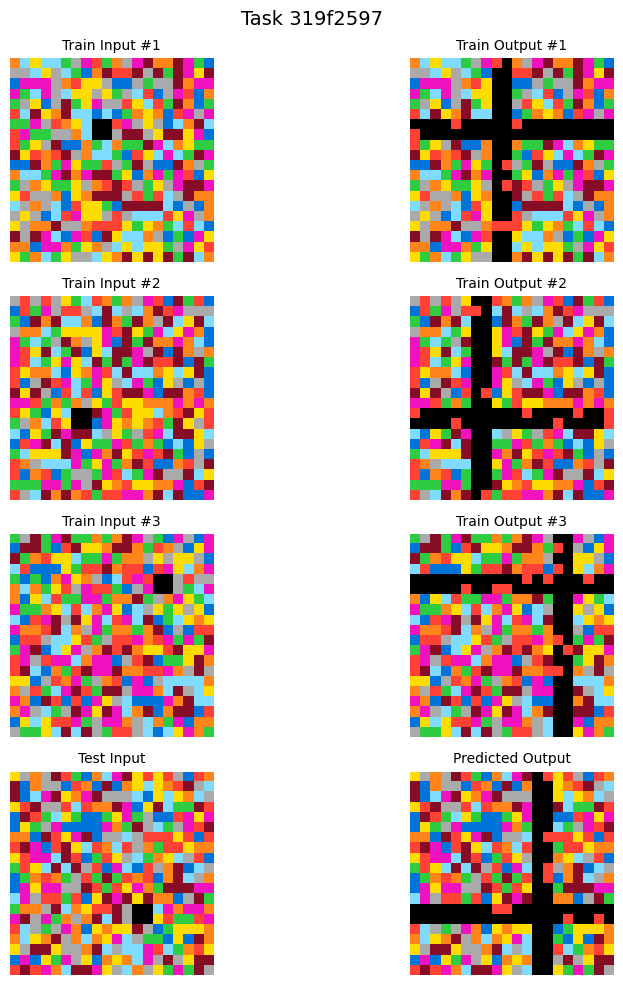

[✔] Displayed Task 319f2597
[✘] Skipped Task 31adaf00 (invalid output)
[✘] Skipped Task 31d5ba1a (predicted output is not 2D: shape (2, 3, 5))
[✘] Skipped Task 31d5ba1a (missing data)
[✘] Skipped Task 32e9702f (invalid output)


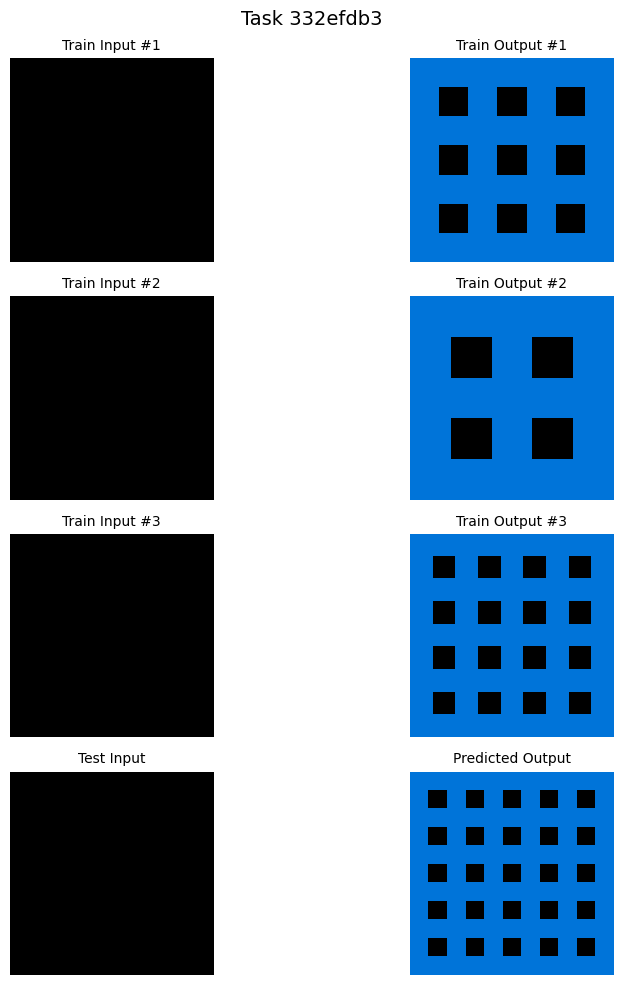

[✔] Displayed Task 332efdb3


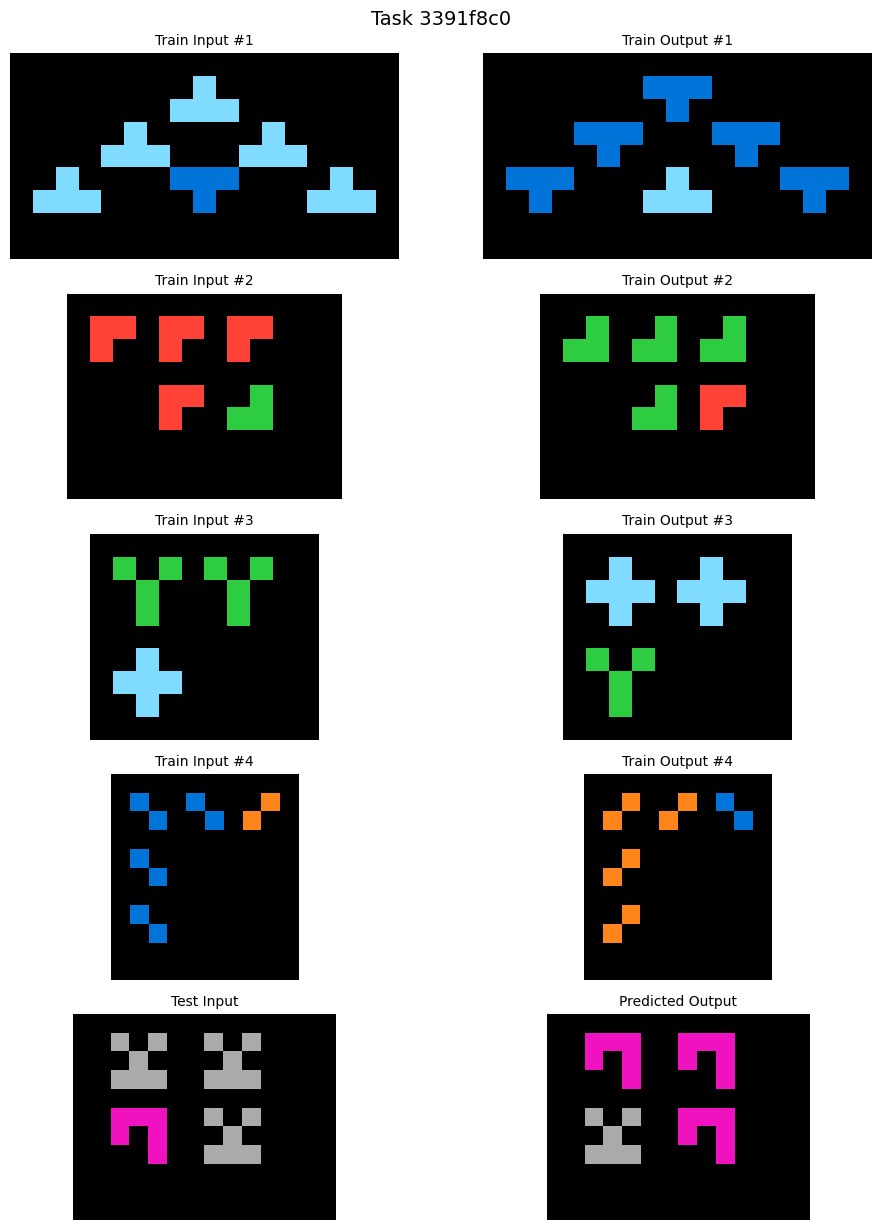

[✔] Displayed Task 3391f8c0
[✘] Skipped Task 33b52de3 (invalid output)


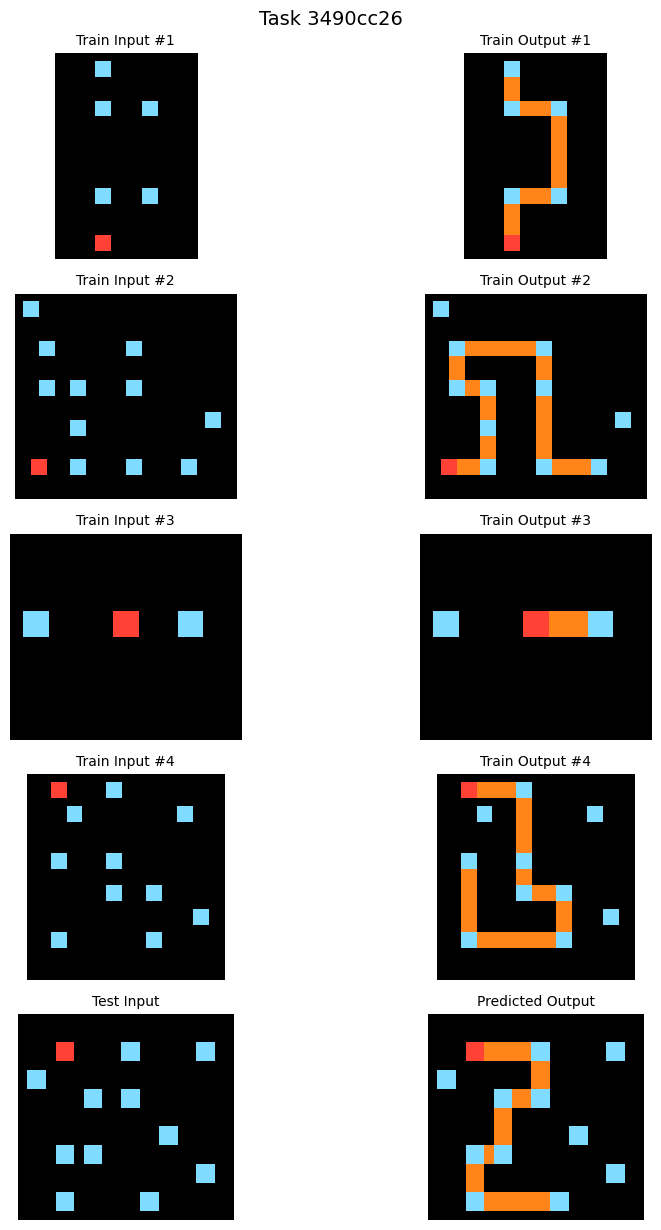

[✔] Displayed Task 3490cc26


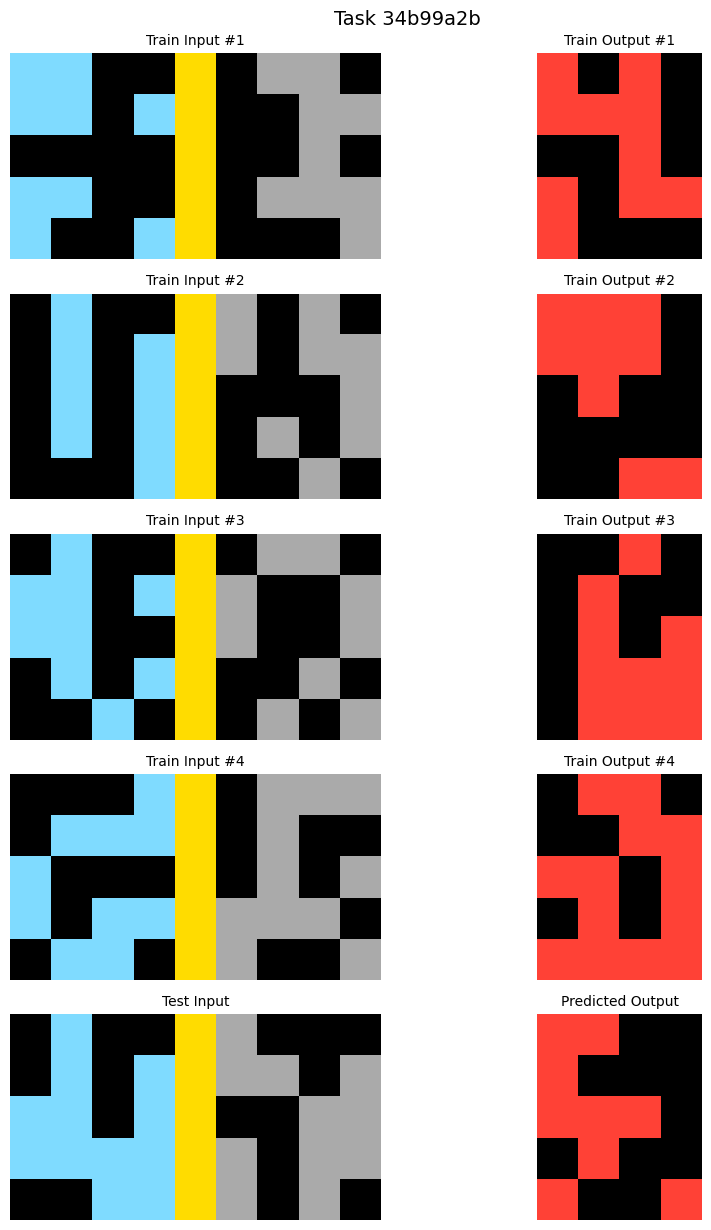

[✔] Displayed Task 34b99a2b


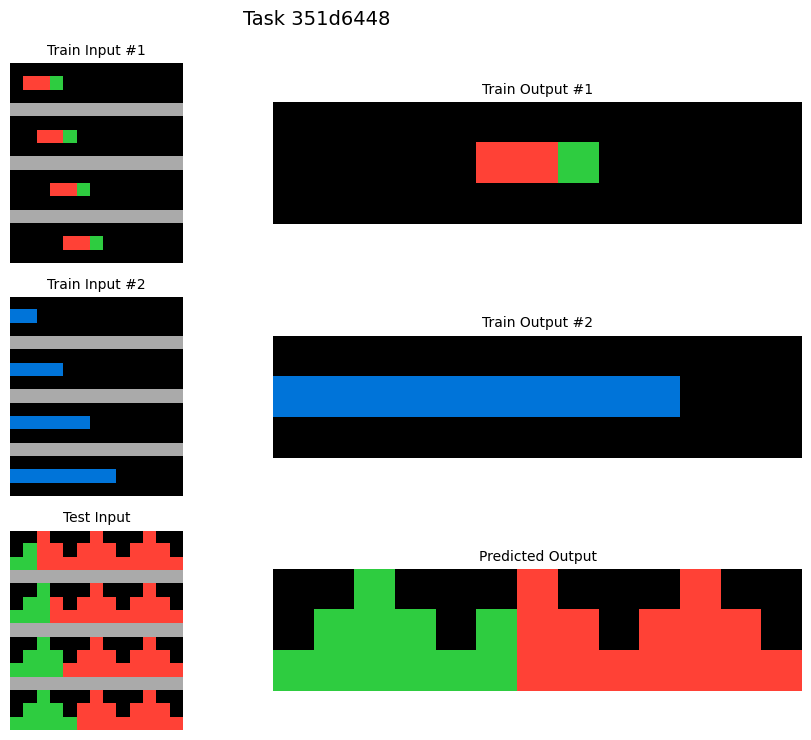

[✔] Displayed Task 351d6448


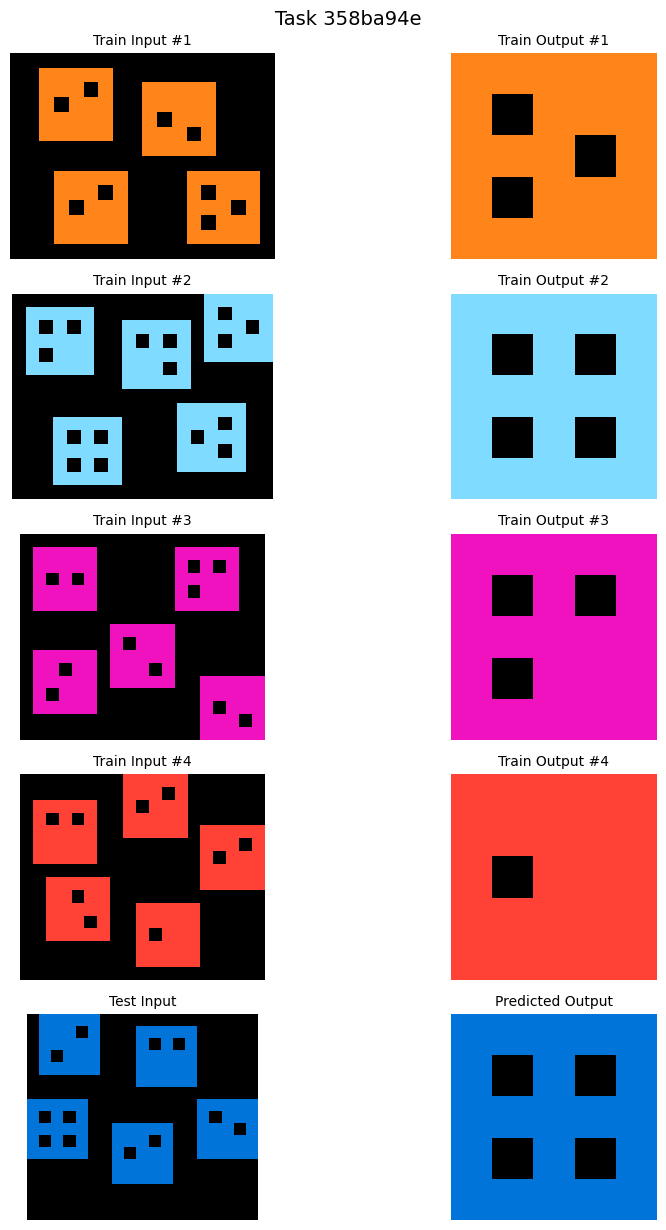

[✔] Displayed Task 358ba94e
[✘] Skipped Task 37d3e8b2 (invalid output)


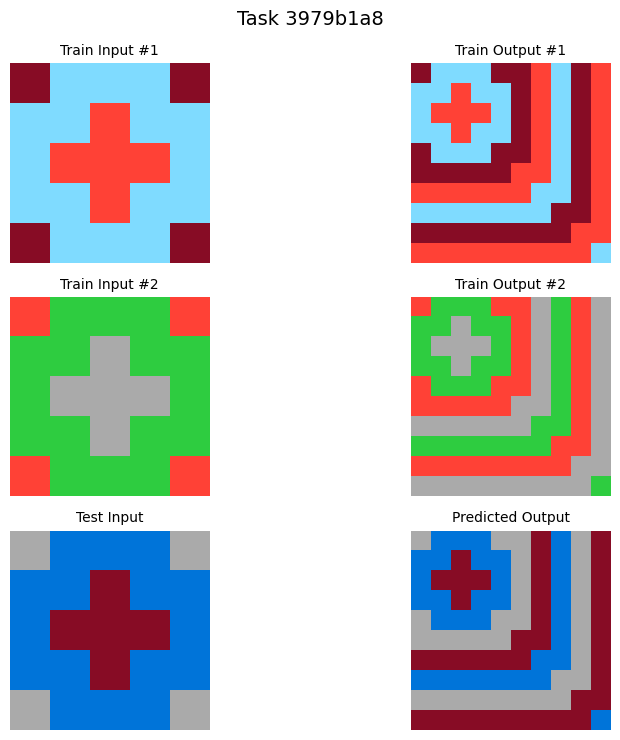

[✔] Displayed Task 3979b1a8
[✘] Skipped Task 3a301edc (invalid output)
[✘] Skipped Task 3b4c2228 (predicted output is not 2D: shape (2, 3, 3))
[✘] Skipped Task 3b4c2228 (missing data)


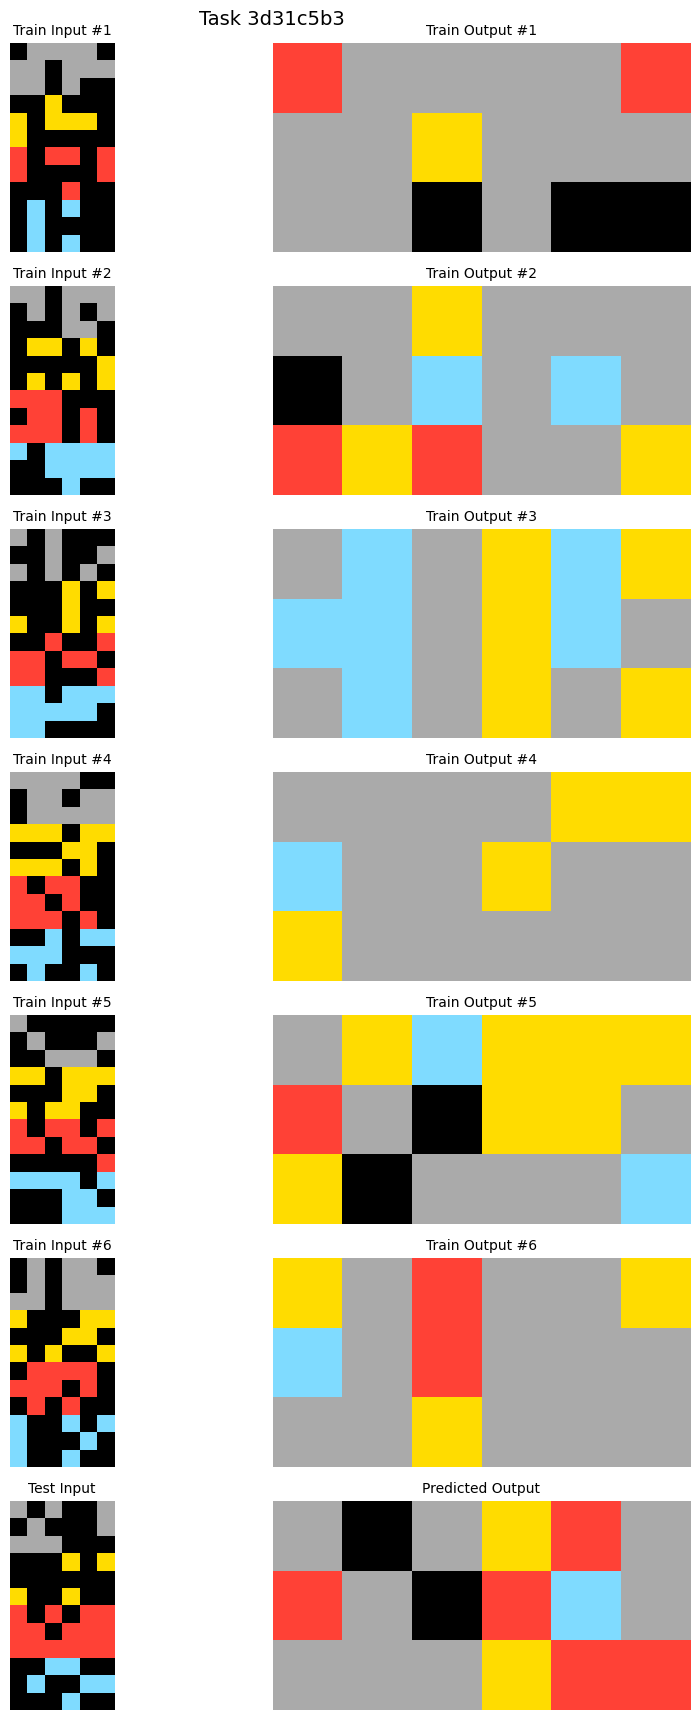

[✔] Displayed Task 3d31c5b3
[✘] Skipped Task 3ed85e70 (invalid output)


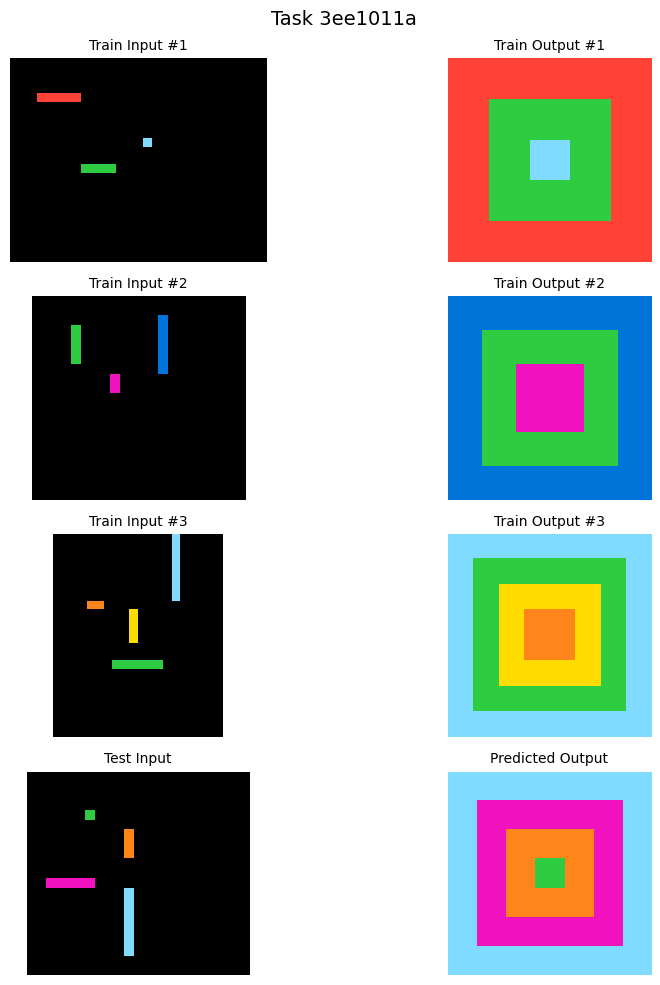

[✔] Displayed Task 3ee1011a


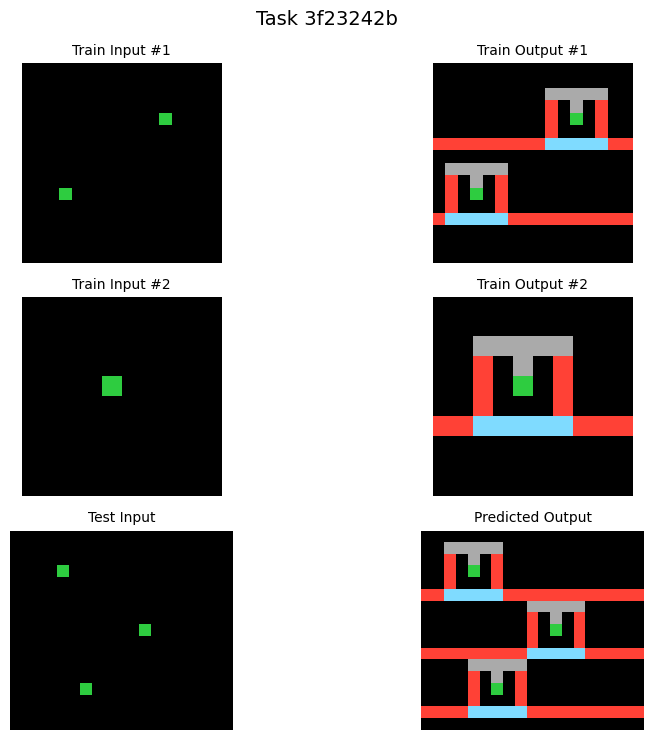

[✔] Displayed Task 3f23242b
[✘] Skipped Task 40f6cd08 (invalid output)
[✘] Skipped Task 414297c0 (invalid output)


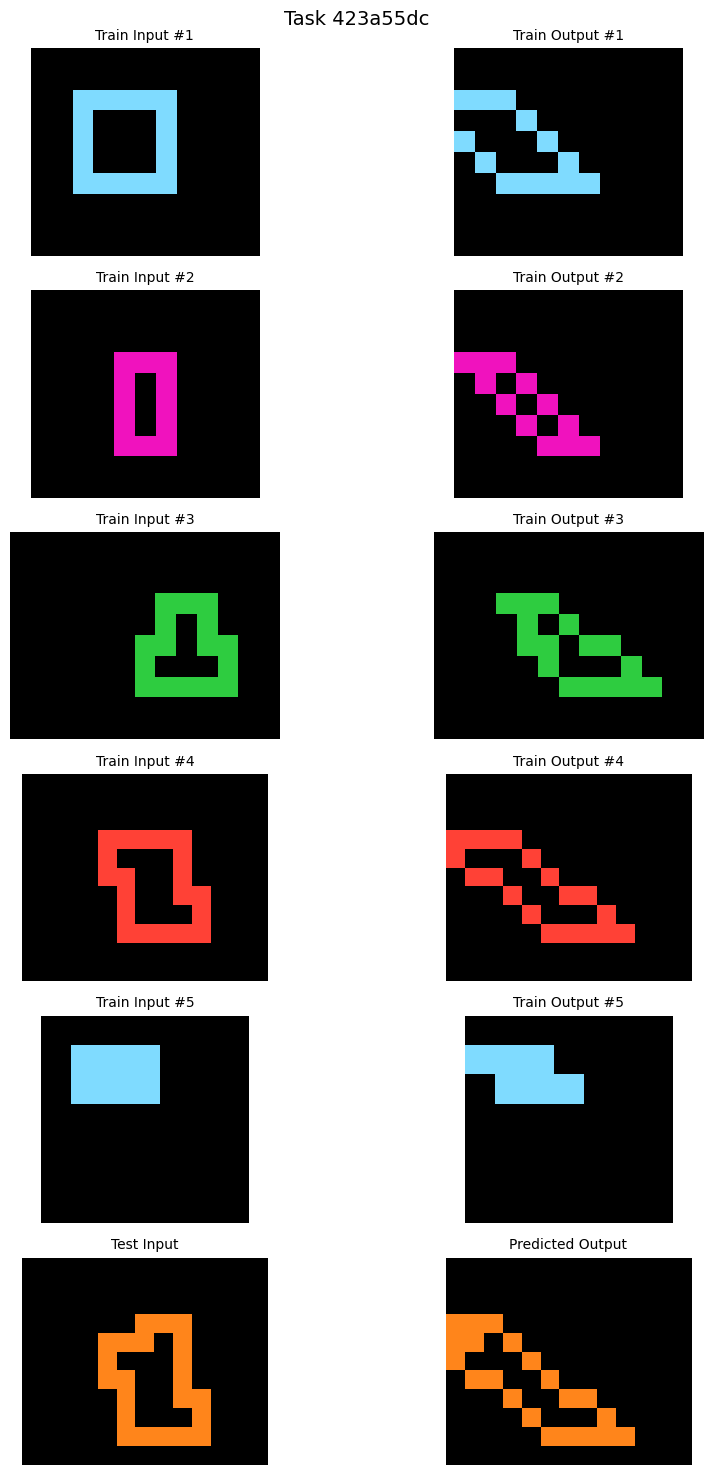

[✔] Displayed Task 423a55dc


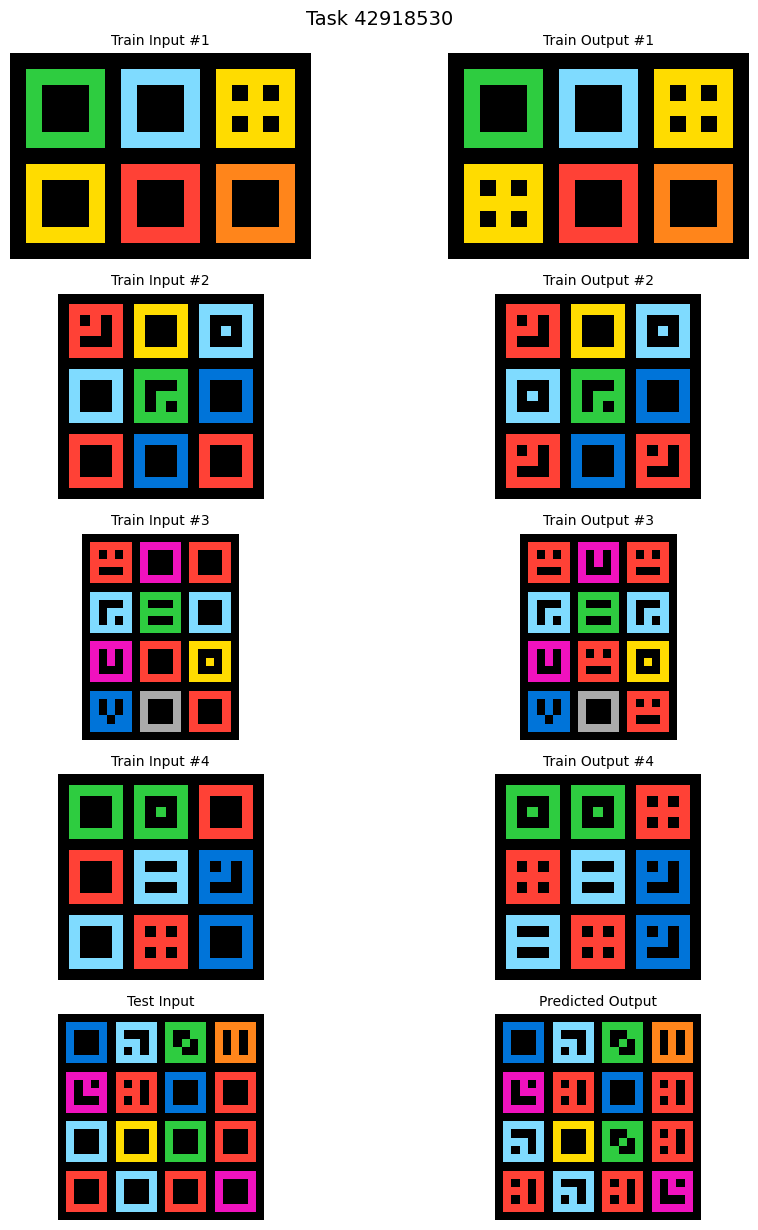

[✔] Displayed Task 42918530

===== Summary =====
Total Entries: 100
Displayed Tasks:          64
Skipped Tasks:            37


In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap

# ARC color palette
arc_color_palette = [
    '#000000',  # 0: black
    '#0074D9',  # 1: blue
    '#FF4136',  # 2: red
    '#2ECC40',  # 3: green
    '#FFDC00',  # 4: yellow
    '#AAAAAA',  # 5: grey
    '#F012BE',  # 6: fuschia
    '#FF851B',  # 7: orange
    '#7FDBFF',  # 8: teal
    '#870C25',  # 9: brown
]
arc_cmap = ListedColormap(arc_color_palette)

def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

def plot_grid(ax, grid, title):
    if grid is None:
        ax.text(0.5, 0.5, '—', ha='center', va='center', fontsize=14)
        ax.axis('off')
    else:
        ax.imshow(grid, cmap=arc_cmap, vmin=0, vmax=9)
        ax.set_title(title, fontsize=10)
        ax.axis('off')

def is_valid_output(output):
    """Check if output is valid (not [[0]] or 0)."""
    if isinstance(output, int):
        return False
    if isinstance(output, list):
        if output == [[0]]:
            return False
        if isinstance(output[0], list) and len(output[0]) == 1 and output[0][0] == 0:
            return False
    return True

def extract_valid_output(output_data):
    """
    Recursively finds and returns the first valid 2D grid from a possibly nested list.
    Returns None if no valid 2D grid found.
    """
    def is_valid_grid(grid):
        return (
            isinstance(grid, list) and
            all(isinstance(row, list) for row in grid) and
            len(grid) > 0 and
            all(len(row) == len(grid[0]) for row in grid)  # All rows same length
        )
    
    # Base case: found valid 2D grid
    if is_valid_grid(output_data):
        return output_data
    
    # If it's a list of possibilities, scan deeper
    if isinstance(output_data, list):
        for item in output_data:
            result = extract_valid_output(item)
            if result is not None:
                return result

    return None

def visualize_task(task_id, challenge, submission_output):
    train_examples = challenge.get("train", [])
    test_examples = challenge.get("test", [])
    if not train_examples or not test_examples:
        return False

    test_input = np.array(test_examples[0]['input'])

    if not is_valid_output(submission_output):
        return False

    predicted_output_raw = extract_valid_output(submission_output)
    if predicted_output_raw is None:
        return False  # Skip if still invalid

    predicted_output = np.squeeze(np.array(predicted_output_raw))

    if predicted_output.ndim != 2:
        print(f"[✘] Skipped Task {task_id} (predicted output is not 2D: shape {predicted_output.shape})")
        return False

    num_train = len(train_examples)
    fig, axes = plt.subplots(num_train + 1, 2, figsize=(10, (num_train + 1) * 2.5))
    fig.suptitle(f"Task {task_id}", fontsize=14)

    for i in range(num_train):
        train_input = np.array(train_examples[i]['input'])
        train_output = np.array(train_examples[i]['output'])
        plot_grid(axes[i][0], train_input, f"Train Input #{i+1}")
        plot_grid(axes[i][1], train_output, f"Train Output #{i+1}")

    plot_grid(axes[num_train][0], test_input, "Test Input")
    plot_grid(axes[num_train][1], predicted_output, "Predicted Output")

    plt.tight_layout()
    plt.show()
    return True


if __name__ == "__main__":
    challenge_file = "/kaggle/input/arc-agi/arc-agi-test-challenges.json"
    submission_file = "/kaggle/input/arc-agi/final_results.json"

    if not os.path.exists(challenge_file) or not os.path.exists(submission_file):
        print("Missing required files.")
        exit()

    challenges = load_json(challenge_file)
    submissions = load_json(submission_file)

    total_tasks = 0
    displayed_tasks = 0
    skipped_tasks = []

    for task_id, submission_output in submissions.items():
        total_tasks += 1

        if task_id not in challenges:
            print(f"[✘] Skipped Task {task_id} (no challenge data)")
            skipped_tasks.append(task_id)
            continue

        if not is_valid_output(submission_output):
            print(f"[✘] Skipped Task {task_id} (invalid output)")
            skipped_tasks.append(task_id)
            continue

        success = visualize_task(task_id, challenges[task_id], submission_output)
        if success:
            print(f"[✔] Displayed Task {task_id}")
            displayed_tasks += 1
        else:
            print(f"[✘] Skipped Task {task_id} (missing data)")
            skipped_tasks.append(task_id)

    print("\n===== Summary =====")
    print(f"Total Entries: 100")
    print(f"Displayed Tasks:          {displayed_tasks}")
    print(f"Skipped Tasks:            {len(skipped_tasks)}")